In [1]:
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

KeyboardInterrupt: 

**automatic result export**

In [ ]:
#still have to work on static link
#for now check automatic resuts export notebook 

In [ ]:
#df = pd.read_csv('Espacenet_search_result.csv', delimiter=';' )

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException

class EspacenetScraper:
    def __init__(self, search_keywords, headless=True):
        """Initialize the scraper with configurable options and search keywords."""
        self.search_keywords = search_keywords
        options = uc.ChromeOptions()
        if headless:
            options.add_argument('--headless')  # Run in headless mode

        options.add_argument('--disable-blink-features=AutomationControlled')
        self.driver = uc.Chrome(options=options)
        self.driver.set_page_load_timeout(30)
        self.driver.set_window_size(1600, 1300)

    def construct_search_url(self):
        """Construct the search URL based on the provided keywords and their search fields."""
        base_url = 'https://worldwide.espacenet.com/patent/search?q='
        
        # Mapping of search fields to Espacenet query parameters
        field_mapping = {
            'title': 'ti',
            'abstract': 'ab',
            'claims': 'cl',
            'title,abstract or claims': 'ctxt' ,
            'all text fields' : 'ftxt',
            'title or abstract' : 'ta',
            'description' : 'desc',
            'all text fields or names' : 'nftxt',
            'title , abstract or names' : 'ntxt'
              # Full text search
        }
        
        query_parts = []
        for keyword, field in self.search_keywords.items():
            field_param = field_mapping.get(field, 'ctxt')  # Default to 'ctxt' if field is unknown
            query_parts.append(f'{field_param} = "{keyword}"')
        
        query = ' AND '.join(query_parts)
        query += '&queryLang=en%3Ade%3Afr'
        
        return base_url + query

    def add_random_delay(self, min_seconds=1, max_seconds=3):
        """Add a random delay to mimic human behavior."""
        time.sleep(random.uniform(min_seconds, max_seconds))

    def get_page_html(self, retries=3):
        """
        Navigate to the constructed URL and return the page HTML.
        Retry the operation if a timeout occurs.

        Args:
            retries (int): Number of retry attempts.

        Returns:
            str: The page HTML, or None if all retries fail.
        """
        url = self.construct_search_url()
        for attempt in range(retries):
            try:
                print(f"Navigating to: {url} (Attempt {attempt + 1})")
                self.driver.get(url)
                WebDriverWait(self.driver, 30).until(
                    EC.presence_of_element_located((By.TAG_NAME, "body"))
                )

                # Add a random delay to mimic human behavior
                self.add_random_delay(3, 5)

                # Return the page HTML
                return self.driver.page_source

            except TimeoutException:
                print(f"Timed out waiting for the page to load. Retrying ({attempt + 1}/{retries})...")
                if attempt == retries - 1:
                    print("Max retries reached. Unable to load the page.")
                    return None
            except Exception as e:
                print(f"An error occurred: {e}")
                return None

    def download_csv(self, retries=3, max_results=500):
        """
        Complete the sequence of clicking:
        1. More Options button
        2. Download dropdown
        3. List (CSV) option
        4. Handle download dialog by:
           - Setting the "To" value to max_results (e.g., 500)
           - Clicking the Download button
        
        Args:
            retries (int): Number of retry attempts for the entire sequence.
            max_results (int): Maximum number of results to download (1-500).

        Returns:
            bool: True if the download sequence was successful, False otherwise.
        """
        for attempt in range(retries):
            try:
                print(f"Attempting download sequence (Attempt {attempt + 1})...")
                
                # Step 1: Click "More Options" button
                print("Looking for More Options button...")
                more_options_selector = "#more-options-selector--publication-list-header"
                more_options_button = WebDriverWait(self.driver, 30).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, more_options_selector))
                )
                
                # Try to click, but handle intercepted clicks
                try:
                    print("More Options button found. Clicking...")
                    more_options_button.click()
                except ElementClickInterceptedException:
                    print("Click intercepted, trying JavaScript click...")
                    self.driver.execute_script('document.querySelector("#more-options-selector--publication-list-header").click()', more_options_button)
                    
                self.add_random_delay(2, 3)
                print('More Options clicked successfully')
                
                # Step 2: Click "Download" section in the dropdown
                print("Looking for Download section...")
                # Use a more general selector to find the Download section
                # This uses contains() to match the text rather than a fixed CSS path
                download_section_xpath = "/html/body/div[2]/div[3]/ul/section[1]"
                download_section = WebDriverWait(self.driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, download_section_xpath))
                )
                
                try:
                    print("Download section found. Clicking...")
                    download_section.click()
                except ElementClickInterceptedException:
                    print("Click intercepted, trying JavaScript click...")
                    self.driver.execute_script('document.querySelector("#simple-dropdown > div.prod-jss1034.prod-jss966.prod-jss969.prod-jss1045 > ul > section:nth-child(1)").click()', download_section)
                    
                self.add_random_delay(1, 2)
                print('Download section clicked successfully')
                
                # Step 3: Click "List (CSV)" option
                print("Looking for List (CSV) option...")
                # Use contains() with the XPATH to find the CSV option based on text
                csv_option_xpath = "/html/body/div[2]/div[3]/ul/li[2]"
                csv_option = WebDriverWait(self.driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, csv_option_xpath))
                )
                
                try:
                    print("List (CSV) option found. Clicking...")
                    csv_option.click()
                except ElementClickInterceptedException:
                    print("Click intercepted, trying JavaScript click...")
                    self.driver.execute_script('document.querySelector("#simple-dropdown > div.prod-jss1034.prod-jss966.prod-jss969.prod-jss1045 > ul > li:nth-child(3)").click()', csv_option)
                    
                self.add_random_delay(2, 3)
                print('List (CSV) option clicked successfully')
                
                # Step 4: Handle the download dialog
                print("Waiting for download dialog to appear...")
                
                # Wait for the dialog to appear
                download_dialog_xpath = "/html/body/div[2]/div[3]/div/div"
                WebDriverWait(self.driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, download_dialog_xpath))
                )
                print("Download dialog appeared")
                
                # Find the "To" input field
                to_input_xpath = "/html/body/div[2]/div[3]/div/div/div/div[1]/input[2]"
                to_input = WebDriverWait(self.driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, to_input_xpath))
                )
                
                # Clear the input and set it to max_results
                print(f"Setting maximum results to {max_results}...")
                to_input.clear()
                to_input.send_keys(str(max_results))
                self.add_random_delay(1, 2)
                
                # Click the Download button in the dialog
                download_button_xpath = "/html/body/div[2]/div[3]/div/div/div/button"
                download_button = WebDriverWait(self.driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, download_button_xpath))
                )
                
                try:
                    print("Download button found. Clicking...")
                    download_button.click()
                except ElementClickInterceptedException:
                    print("Click intercepted, trying JavaScript click...")
                    self.driver.execute_script('document.querySelector("body > div.prod-jss12 > div.prod-jss15.prod-jss13 > div > div > div > button").click()', download_button)
                
                print("Download button clicked")
                
                # Wait for a moment to ensure the download starts
                self.add_random_delay(3, 5)
                
                # Check if there are any error messages
                try:
                    error_message = self.driver.find_element(By.XPATH, "//div[contains(@class, 'download-modal__validation')]//span")
                    if error_message.is_displayed() and error_message.text.strip():
                        print(f"Error in download dialog: {error_message.text}")
                        return False
                except:
                    # No error message found, continue
                    pass
                
                print("Download sequence completed successfully")
                return True
                
            except TimeoutException as e:
                print(f"Timeout during download sequence: {e}")
                if attempt == retries - 1:
                    print("Max retries reached. Download sequence failed.")
                    return False
            except Exception as e:
                print(f"Error during download sequence: {e}")
                if attempt == retries - 1:
                    print("Max retries reached. Download sequence failed.")
                    return False
                
            # If we reach here, there was an error and we need to try again
            # Refresh the page before the next attempt
            try:
                self.driver.refresh()
                WebDriverWait(self.driver, 30).until(
                    EC.presence_of_element_located((By.TAG_NAME, "body"))
                )
                self.add_random_delay(3, 5)
            except Exception as e:
                print(f"Error refreshing page: {e}")

        return False

    def close(self):
        """Close the browser when done."""
        if self.driver:
            self.driver.quit()




|'title'
|'abstract'
|'claims'
|'title,abstract or claims'
|'all text fields'
|'title or abstract'
|'description'
|'all text fields or names' 
|'title , abstract or names' 

In [ ]:
if __name__ == '__main__':
    # Define the search keywords with their search fields
    search_keywords = {
        "Silicon": "title,abstract or claims",
        "crystal": "title,abstract or claims",
        "lattice": "title,abstract or claims"
        
        
    }

    # Initialize the scraper with the search keywords
    scraper = EspacenetScraper(search_keywords, headless=False)  # Set headless to False to see the browser in action

    try:
        # Construct and print the search URL
        search_url = scraper.construct_search_url()
        print("Constructed Search URL:", search_url)
        
        # Get the page HTML
        html = scraper.get_page_html(retries=3)
        if html:
            print("Page HTML retrieved successfully.")

            # Perform the download sequence with max 500 results
            if scraper.download_csv(retries=3, max_results=500):
                print("CSV download initiated successfully.")
                # Wait a bit to ensure the download starts
                time.sleep(10)
                print("Download should be complete or in progress.")
            else:
                print("Failed to download CSV.")

    finally:
        # Close the browser
        scraper.close()
        print("Scraper closed.")


Constructed Search URL: https://worldwide.espacenet.com/patent/search?q=ctxt = "Silicon" AND ctxt = "crystal" AND ctxt = "lattice"&queryLang=en%3Ade%3Afr
Navigating to: https://worldwide.espacenet.com/patent/search?q=ctxt = "Silicon" AND ctxt = "crystal" AND ctxt = "lattice"&queryLang=en%3Ade%3Afr (Attempt 1)
Page HTML retrieved successfully.
Attempting download sequence (Attempt 1)...
Looking for More Options button...
More Options button found. Clicking...
More Options clicked successfully
Looking for Download section...
Download section found. Clicking...
Download section clicked successfully
Looking for List (CSV) option...
List (CSV) option found. Clicking...
List (CSV) option clicked successfully
Waiting for download dialog to appear...
Download dialog appeared
Setting maximum results to 500...
Download button found. Clicking...
Download button clicked
Download sequence completed successfully
CSV download initiated successfully.
Download should be complete or in progress.
Scraper

In [ ]:
import os
import glob

# Get the Downloads folder path
downloads_folder = os.path.expanduser("~/Downloads")

# Get all CSV files in the Downloads folder
list_of_files = glob.glob(os.path.join(downloads_folder, "*.csv"))

if list_of_files:  # Ensure there are CSV files
    latest_file = max(list_of_files, key=os.path.getmtime)
    print("Latest downloaded file:", latest_file)

    # Read the latest CSV file into a DataFrame
    import pandas as pd
    df = pd.read_csv(latest_file,delimiter=';', skiprows=7)
    df.head()
else:
    print("No CSV files found in Downloads.")


Latest downloaded file: C:\Users\tasni/Downloads\Résultat_de_la_recherche_dans_Espacenet_20250430_1655.csv


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
df.rename(columns={
    'Titre': 'Title',
    'Inventeurs': 'Inventors',
    'Demandeurs': 'Applicants',
    'Numéro de publication': 'Publication number',
    'Priorité la plus ancienne': 'Earliest priority',
    'CIB': 'IPC',
    'CPC': 'CPC',
    'Date de publication': 'Publication date',
    'Publication la plus ancienne': 'Earliest publication',
    'Numéro de famille': 'Family number'
}, inplace=True)


In [ ]:

df[['first publication date','second publication date']] = df['Publication date'].str.split(' ' , n=1 , expand= True)
df['second publication date'] = df['second publication date'].str.strip('\n')
df['second publication date'] = df['second publication date'].str.strip('\r')
df['second publication date'] = df['second publication date'].str.strip('\n')


In [ ]:
# df['second publication date'] = pd.to_datetime(
#     df['second publication date'].str.strip(), 
#     format='mixed'
# )

df['first publication date'] = pd.to_datetime(
    df['first publication date'].str.strip(), 
    format='mixed'
)

In [ ]:
#first filing country 
df[['first publication number', 'second publication number']] = df['Publication number'].str.split(' ' , n=1 , expand=True)



In [ ]:
df['second publication number']=df['second publication number'].str.strip('\n')
df['first publication country'] = df['first publication number'].str[:2]
df['second publication country'] = df['second publication number'].str[:2]


In [ ]:
if 'Unnamed: 11' in df.columns:
    df = df.drop('Unnamed: 11', axis=1)

In [ ]:

df['first filing year'] = df['first publication date'].dt.year

In [ ]:

df['Earliest priority'] = pd.to_datetime(df['Earliest priority'])
df['earliest priority year'] = df['Earliest priority'].dt.year

In [ ]:
df['applicant country'] = df['Applicants'].str.extract(r'\[([A-Z]{2})\]')

In [ ]:
df = df.dropna(subset=['Inventors'])

first filing analysis 


In [ ]:

df['Applicants'] = df['Applicants'].fillna(df['Inventors'])

In [ ]:
df = df.reset_index(drop=True)


In [ ]:
df = df.dropna(subset=['Inventors','Applicants','IPC'])

In [ ]:
#filling missing CPC values 
df['CPC'] = df['CPC'].fillna('unkown')
df.isnull().sum()

No                              0
Title                           0
Inventors                       0
Applicants                      0
Publication number              0
Earliest priority               0
IPC                             0
CPC                             0
Publication date                0
Earliest publication            0
Family number                   0
first publication date          0
second publication date       240
first publication number        0
second publication number     240
first publication country       0
second publication country    240
first filing year               0
earliest priority year          0
applicant country             230
dtype: int64

In [ ]:
df['IPC'] = df['IPC'].str.split(r'\s+')



In [ ]:
import re

def split_cpc(classification):
    # Split only at ") " but keep the ")"
    parts = re.split(r'\)\s+', classification)  
    return [p + ')' if not p.endswith(')') else p for p in parts]  # Ensure each part ends with ')'


df['CPC'] = df['CPC'].apply(split_cpc)



In [ ]:
len(df)

496

research retrieve

In [ ]:
import requests
import pandas as pd
import time
query= 'Silicon crystal lattice'

# Basic search parameters
url = "https://api.semanticscholar.org/graph/v1/paper/search/bulk"
params = {
    'query': query,
    'fields': 'title,authors,venue,publicationVenue,year,publicationDate,citationCount,abstract,influentialCitationCount,fieldsOfStudy,publicationTypes',
    'limit': 500
}

# Optional: Include your API key if you have one
# headers = {
#     'x-api-key': 'YOUR_API_KEY'
# }

max_retries = 5  # Maximum number of retries
retry_delay = 60  # Delay in seconds before retrying

for attempt in range(max_retries):
    response = requests.get(url, params=params)  # Add headers=headers if using an API key
    if response.status_code == 200:
        data = response.json()
        print(data)
        break  # Exit the loop if the request was successful
    elif response.status_code == 429:
        print(f"Too many requests. Waiting for {retry_delay} seconds before retrying...")
        time.sleep(retry_delay)  # Wait before retrying
    else:
        print(f"Request failed with status code: {response.status_code}")
        break  # Exit the loop on other errors

# Debug print to check keys for the first paper
if data.get('data'):
    print("Available keys in first paper:", data['data'][0].keys())

papers = data.get('data', [])
rows = []
for paper in papers:
    # Safely handle the possibility of publicationVenue being None
    pub_venue = paper.get('publicationVenue') or {}
    pub_venue_name = pub_venue.get('name') if isinstance(pub_venue, dict) else paper.get('venue')
    pub_venue_type = pub_venue.get('type') if isinstance(pub_venue, dict) else 'unknown'
    
    # Get publication date with a fallback value (if missing, use 'Unknown')
    pub_date = paper.get('publicationDate', 'Unknown')
    
    # Extract author names
    authors = paper.get('authors', [])
    author_names = [author.get('name', '') for author in authors]
    
    # Build row dictionary
    row = {
        'Title': paper.get('title', ''),
        'Abstract': paper.get('abstract', ''),
        'PublicationVenueName': pub_venue_name or paper.get('venue'),
        'PublicationVenueType': pub_venue_type,
        'Year': paper.get('year', None),
        'ReferenceCount': paper.get('referenceCount', None),
        'CitationCount': paper.get('citationCount', None),
        'InfluentialCitationCount': paper.get('influentialCitationCount', None),
        'FieldsOfStudy': paper.get('fieldsOfStudy', []),
        'PublicationTypes': paper.get('publicationTypes', []),
        'PublicationDate': pub_date,
        'Authors': ', '.join(author_names) if author_names else None
    }
    rows.append(row)

# Create DataFrame and display the first few rows
df_papers = pd.DataFrame(rows)
df_papers['year'] = pd.to_datetime(df_papers['PublicationDate'], errors='coerce').dt.year
    
    # Convert to integer (NaN becomes <NA> which is better for visualization)
df_papers['year'] = df_papers['year'].astype('Int64')

{'total': 5456, 'token': 'PCOKWVSKJJGM4TWNJNI3EUSQJIWVNUSRKBFEYK2JFUBHFI4VRRJEYTAMFQW43E2SKLGAZU6SFQG5GEUNZSG43DOTCJGUYDMNJQG42DCMKOAJJKKSNQWQB3F4CORQ', 'data': [{'paperId': '0006c2521e589ad20b2e70c735e5fad7d5bcf77b', 'publicationVenue': {'id': '32f1d789-f086-4958-a5df-a308e27678fb', 'name': 'Progress In Electromagnetics Research Letters', 'type': 'journal', 'alternate_names': ['Prog Electromagn Res Lett', 'Progress in Electromagnetics Research Letters'], 'issn': '1937-6480', 'url': 'http://go.galegroup.com/ps/i.do?issn=1937-6480&it=JIourl&p=AONE&sw=w&u=loc_main&v=2.1', 'alternate_urls': ['http://www.jpier.org/PIERL/']}, 'title': 'HIGH SENSITIVITY TEMPERATURE SENSOR BASED ON PHOTONIC CRYSTAL RESONANT CAVITY', 'abstract': 'In this paper we investigate a new design of high sensitivity photonic crystal temperature sensor (PCTS). A square lattice of silicon (Si) rods immersed in air matrix is used as a basic structure. The designed sensor consists of two inline quasi-waveguides which are c

**retrieve family members**

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# ———— 1. Publication Trend ————
# Group by the existing df_papers['year'] and name the count column "publications"
pub_trend = (
    df_papers
    .groupby('year')
    .size()
    .reset_index(name='publications')
)
# Now pub_trend.columns == ['year', 'publications']

# ———— 2. Patent Trend ————
# Ensure we have a numeric “first filing year” column, then group the same way
if 'first filing year' in df.columns:
    patent_trend = (
        df
        .groupby('first filing year')
        .size()
        .reset_index(name='patents')
        .rename(columns={'first filing year':'year'})
    )
elif 'first filing date' in df.columns:
    df['first filing year'] = pd.to_datetime(df['first filing date'], errors='coerce').dt.year
    patent_trend = (
        df
        .groupby('first filing year')
        .size()
        .reset_index(name='patents')
        .rename(columns={'first filing year':'year'})
    )
else:
    raise KeyError("Need either 'first filing year' or 'first filing date' in your patent DataFrame")

# ———— 3. Build the Combined Figure ————
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Publications on left axis
fig.add_trace(
    go.Scatter(
        x=pub_trend['year'],
        y=pub_trend['publications'],
        mode='lines+markers',
        name='Publications',
        line=dict(color='#1f77b4', width=2),
        hovertemplate='Year: %{x}<br>Publications: %{y}<extra></extra>'
    ),
    secondary_y=False
)

# Patents on right axis
fig.add_trace(
    go.Scatter(
        x=patent_trend['year'],
        y=patent_trend['patents'],
        mode='lines+markers',
        name='Patents',
        line=dict(color='#9467bd', width=2, dash='dot'),
        hovertemplate='Year: %{x}<br>Patents: %{y}<extra></extra>'
    ),
    secondary_y=True
)

# ———— 4. Layout & Range Controls ————
fig.update_layout(
    title_text='Research Publications vs Patent Filings',
    title_x=0.5,
    title_font_size=24,
    xaxis_title='Year',
    yaxis_title='Publications Count',
    yaxis2_title='Patents Count',
    hovermode='x unified',
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.1, xanchor="center", x=0.5),
    margin=dict(t=100),
    height=600
)

fig.update_xaxes(
    title_text=f"Year<br><sub><i><b>{query}</b></i></sub>",
    title_font=dict(size=16),
    title_standoff=25,
    
    rangeslider_visible=True,
    dtick=2,
    rangeselector=dict(
        buttons=[
            dict(count=5,  label="5y",  step="year", stepmode="backward"),
            dict(count=10, label="10y", step="year", stepmode="backward"),
            dict(step="all")
        ]
    )
)
legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.5,  # ← This is how high above the plot area the legend sits
    xanchor="center",
    x=0.5
)
margin=dict(t=120)  # or 130 for more space


fig.show()


In [ ]:
import os
import requests
import time
from urllib.parse import quote
import pandas as pd
from dotenv import load_dotenv

# Global token cache
TOKEN = None
TOKEN_EXPIRY = 0

# Constants for API endpoints
TOKEN_URL = "https://ops.epo.org/3.2/auth/accesstoken"
BASE_URL = "https://ops.epo.org/3.2/rest-services"

# Load credentials from .env file
load_dotenv()
CONSUMER_KEY = os.getenv("CONSUMER_KEY").strip()
CONSUMER_SECRET = os.getenv("CONSUMER_SECRET").strip()

def get_access_token() -> str:
    """Get or refresh the OAuth access token."""
    global TOKEN, TOKEN_EXPIRY
    if TOKEN and time.time() < TOKEN_EXPIRY:
        return TOKEN
    data = {
        "grant_type": "client_credentials",
        "client_id": CONSUMER_KEY,
        "client_secret": CONSUMER_SECRET
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(TOKEN_URL, data=data, headers=headers, timeout=15)
    response.raise_for_status()
    TOKEN = response.json()["access_token"]
    TOKEN_EXPIRY = time.time() + 3500  # approximately 58 minutes
    return TOKEN

def validate_patent_number(patent: str) -> bool:
    """Perform a basic validation for the patent number format."""
    if not patent or len(patent.strip()) < 4:
        return False
    return True

def extract_jurisdictions_and_members(data: dict) -> dict:
    """
    Extract jurisdictions (as a sorted list) and family member publication numbers
    (formatted as country+doc-number+kind) from the JSON response.
    """
    try:
        jurisdictions = set()
        family_members = []
        world_data = data.get('ops:world-patent-data', {})
        patent_family = world_data.get('ops:patent-family', {})
        members = patent_family.get('ops:family-member', [])
        if isinstance(members, dict):
            members = [members]

        for member in members:
            pub_ref = member.get('publication-reference', {})
            docs = pub_ref.get('document-id', [])
            if isinstance(docs, dict):
                docs = [docs]

            for doc in docs:
                if doc.get('@document-id-type') == 'docdb':
                    country = doc.get('country')
                    if isinstance(country, dict):
                        country = country.get('$')
                    doc_number = doc.get('doc-number')
                    if isinstance(doc_number, dict):
                        doc_number = doc_number.get('$')
                    kind = doc.get('kind')
                    if isinstance(kind, dict):
                        kind = kind.get('$')

                    if country and doc_number and kind:
                        jurisdictions.add(country)
                        family_members.append(f"{country}{doc_number}{kind}")

        return {
            'jurisdictions': sorted(jurisdictions),
            'family_members': sorted(set(family_members))
        }

    except Exception as e:
        print(f"Error parsing response: {e}")
        return {'jurisdictions': None, 'family_members': None}

def process_patent(patent: str) -> dict:
    """
    Process a single patent by sending a request to the patent family endpoint,
    then extract family jurisdictions and family member publication numbers.
    Returns a dict with two keys: 'jurisdictions' and 'family_members'.
    """
    if not validate_patent_number(patent):
        print(f"Invalid patent number: {patent}")
        return {'jurisdictions': None, 'family_members': None}
    try:
        token = get_access_token()
        url = f"{BASE_URL}/family/publication/docdb/{quote(patent)}"
        headers = {
            "Authorization": f"Bearer {token}",
            "Accept": "application/json"
        }
        response = requests.get(url, headers=headers, timeout=15)
        if response.status_code == 403:
            print(f"Access forbidden for patent {patent}")
            return {'jurisdictions': None, 'family_members': None}
        if response.status_code == 404:
            print(f"Patent {patent} not found")
            return {'jurisdictions': None, 'family_members': None}
        response.raise_for_status()
        data = response.json()
        return extract_jurisdictions_and_members(data)
    except Exception as e:
        print(f"Error processing patent {patent}: {e}")
        return {'jurisdictions': None, 'family_members': None}

def process_dataframe(df: pd.DataFrame, patent_col: str) -> pd.DataFrame:
    """
    For a DataFrame containing a column of patent numbers,
    process each patent (in batches) and add two new columns:
      - 'family_jurisdictions': sorted list of jurisdictions for the patent's family
      - 'family_members': sorted list of publication numbers for family members
    """
    if patent_col not in df.columns:
        raise ValueError(f"Column '{patent_col}' not found in DataFrame")
    result_df = df.copy()
    patents = result_df[patent_col].tolist()
    total = len(patents)
    batch_size = 100
    request_delay = 1.2  # seconds delay between requests
    results = {}

    for i in range(0, total, batch_size):
        batch = patents[i:i + batch_size]
        print(f"\nProcessing batch {i//batch_size + 1}/{(total - 1)//batch_size + 1}")
        for patent in batch:
            results[patent] = process_patent(patent)
            time.sleep(request_delay)
        if i + batch_size < total:
            print("Pausing between batches...")
            time.sleep(1)
            
    # Map the processed results to new DataFrame columns
    result_df['family_jurisdictions'] = result_df[patent_col].map(
        lambda p: results.get(p, {}).get('jurisdictions')
    )
    result_df['family_members'] = result_df[patent_col].map(
        lambda p: results.get(p, {}).get('family_members')
    )
    return result_df

# ======= USAGE EXAMPLE =======
if __name__ == "__main__":

    try:
        processed_df = process_dataframe(df, 'first publication number')
        print("\nFinal Results:")
        print(processed_df[['first publication number', 'family_jurisdictions', 'family_members']])
        # Optionally, export the results to CSV
        #processed_df.to_csv('patent_jurisdictions.csv', index=False)
    except Exception as e:
        print(f"Processing failed: {e}")



Processing batch 1/5
Error processing patent JPS58140112A: ('Connection aborted.', ConnectionResetError(10054, 'Une connexion existante a dû être fermée par l’hôte distant', None, 10054, None))


KeyboardInterrupt: 

In [ ]:
df=processed_df

NameError: name 'processed_df' is not defined

In [ ]:
len(processed_df)

493

extracting abstract 

In [ ]:
# import os
# import requests
# from urllib.parse import quote
# from dotenv import load_dotenv
# import json
# import pandas as pd
# import time


# load_dotenv()
# CONSUMER_KEY = os.getenv("CONSUMER_KEY").strip()
# CONSUMER_SECRET = os.getenv("CONSUMER_SECRET").strip()

# TOKEN_URL = "https://ops.epo.org/3.2/auth/accesstoken"
# BASE_URL = "https://ops.epo.org/3.2/rest-services"

# # === Functions ===

# def get_access_token() -> str:
#     """
#     Obtain an OAuth access token from OPS.
#     """
#     data = {
#         "grant_type": "client_credentials",
#         "client_id": CONSUMER_KEY,
#         "client_secret": CONSUMER_SECRET
#     }
#     headers = {"Content-Type": "application/x-www-form-urlencoded"}
#     response = requests.post(TOKEN_URL, data=data, headers=headers, timeout=15)
#     response.raise_for_status()
#     return response.json()["access_token"]

# def get_abstract_json(publication_number: str) -> dict:
#     """
#     Retrieve the abstract for a given publication number as JSON.
    
#     For example, for publication_number = 'KR102511398B1', the endpoint URL becomes:
#       https://ops.epo.org/3.2/rest-services/published-data/publication/docdb/KR102511398B1/abstract
#     """
#     token = get_access_token()
#     url = f"{BASE_URL}/published-data/publication/docdb/{quote(publication_number)}/abstract"
#     headers = {
#         "Authorization": f"Bearer {token}",
#         "Accept": "application/json"
#     }
#     response = requests.get(url, headers=headers, timeout=15)
#     print(f"Fetching {publication_number} - Status code: {response.status_code}")
#     response.raise_for_status()
#     return response.json()

# def extract_english_abstract_from_json(json_data: dict) -> str:
#     """
#     Given the JSON response from the OPS abstract endpoint, extract and return the English abstract text.
#     Returns the abstract text as a string or None if not found.
#     """
#     try:
#         world_data = json_data.get("ops:world-patent-data", {})
#         exch_docs = world_data.get("exchange-documents", {})
#         doc = exch_docs.get("exchange-document", {})
#         abstract_section = doc.get("abstract", [])
#         # If abstract is a dict (only one present), convert it to a list
#         if isinstance(abstract_section, dict):
#             abstract_section = [abstract_section]
#         for abstract in abstract_section:
#             if abstract.get("@lang") == "en":
#                 # The abstract text is in the "p" field as a dict with key "$"
#                 p = abstract.get("p")
#                 if isinstance(p, dict):
#                     return p.get("$", "").strip()
#                 elif isinstance(p, list):
#                     # In case of multiple paragraphs
#                     return " ".join(item.get("$", "").strip() for item in p if isinstance(item, dict))
#                 elif isinstance(p, str):
#                     return p.strip()
#         return None
#     except Exception as e:
#         print("Error extracting English abstract:", e)
#         return None

# def add_abstracts_to_dataframe(df: pd.DataFrame, patent_col: str) -> pd.DataFrame:
#     """
#     Enrich the DataFrame by adding an 'english_abstract' column.
#     For each patent number in the patent_col, this function:
#       1. Retrieves the abstract JSON from the OPS API.
#       2. Extracts the English abstract using extract_english_abstract_from_json().
#       3. Stores the result in a new column.
      
#     A delay is added between requests to comply with rate limits.
#     """
#     if patent_col not in df.columns:
#         raise ValueError(f"Column '{patent_col}' not found in DataFrame")
    
#     abstracts = []
#     total = len(df)
#     for idx, pub_number in enumerate(df[patent_col]):
#         print(f"Processing {idx+1}/{total}: {pub_number}")
#         try:
#             json_data = get_abstract_json(pub_number)
#             abstract_text = extract_english_abstract_from_json(json_data)
#         except Exception as e:
#             print(f"Error processing {pub_number}: {e}")
#             abstract_text = None
#         abstracts.append(abstract_text)
       
#         time.sleep(1.2)
#     df = df.copy()
#     df["abstract"] = abstracts
#     return df


# if __name__ == "__main__":

#     enriched_df = add_abstracts_to_dataframe(df, "first publication number")
    

#     print(enriched_df[["first publication number", "abstract"]])



Processing 1/493: EP3648416A1
Fetching EP3648416A1 - Status code: 200
Processing 2/493: US11405415B2
Fetching US11405415B2 - Status code: 200
Processing 3/493: US2014250500A1
Fetching US2014250500A1 - Status code: 200
Processing 4/493: US2014126723A1
Fetching US2014126723A1 - Status code: 200
Processing 5/493: US10958679B2
Fetching US10958679B2 - Status code: 200
Processing 6/493: US2013066940A1
Fetching US2013066940A1 - Status code: 200
Processing 7/493: US11902329B2
Fetching US11902329B2 - Status code: 200
Processing 8/493: US11546360B2
Fetching US11546360B2 - Status code: 200
Processing 9/493: US9300660B1
Fetching US9300660B1 - Status code: 200
Processing 10/493: WO2019006637A1
Fetching WO2019006637A1 - Status code: 200
Processing 11/493: US10142346B2
Fetching US10142346B2 - Status code: 200
Processing 12/493: EP3240232A1
Fetching EP3240232A1 - Status code: 200
Processing 13/493: US2015100357A1
Fetching US2015100357A1 - Status code: 200
Processing 14/493: US2020320853A1
Fetching US2

In [ ]:
enriched_df.head()

No                                              Title  \
0   1  APPAREIL D'AUTOMATISATION À ANALYSE DE RÉSEAU ...   
1   2  SYSTEM AND METHOD FOR SELECTION OF CLOUD SERVI...   
2   3  SECURITY-ENHANCED CLOUD SYSTEM AND SECURITY MA...   
3   4  METHOD, APPARATUS, AND SYSTEM FOR PROTECTING C...   
4   5  TECHNIQUES FOR CLOUD SECURITY MONITORING AND T...   

                                           Inventors  \
0                          HILSCHER HANS-JÜRGEN [DE]   
1  RAMAMURTHY ARUN [IN] \r\nGHAROTE MANGESH SHARA...   
2                                LEE CHUNG JONG [KR]   
3           ZHANG JINGBIN [CN] \r\nHE CHENGDONG [CN]   
4  KIRTI GANESH [US] \r\nGUPTA ROHIT [US] \r\nBIS...   

                                          Applicants  \
0  HILSCHER GES FUER SYSTEMAUTOMATION MBH [DE] \r...   
1                 TATA CONSULTANCY SERVICES LTD [IN]   
2                                LEE CHUNG JONG [KR]   
3                            HUAWEI TECH CO LTD [CN]   
4                               ORACLE INT CORP [US]   

                Publication number Earliest priority  \
0      EP3648416A1 \r\nEP3648416B1        2018-11-05   
1  US11405415B2 \r\nUS2021176266A1        2019-12-06   
2   US2014250500A1 \r\nUS9124579B2        2011-09-29   
3   US2014126723A1 \r\nUS9203614B2        2011-11-09   
4  US10958679B2 \r\nUS2017295199A1        2013-12-13   

                                                 IPC  \
0                            [H04L12/40, H04L12/413]   
1  [H04L29/06, H04L29/08, G06F9/455, G06F11/36, G...   
2  [H04L29/06, G06F21/32, G06K9/00, H04L29/08, H0...   
3                    [H04L9/08, H04L29/06, H04L9/14]   
4                                        [H04L29/06]   

                                                 CPC  \
0  [H04L12/40032 (EP), H04L12/413 (EP), H04L2012/...   
1  [G06F9/45558 (US), G06F9/5072 (EP,US), G06F9/5...   
2  [G06F15/16 (KR), G06F21/30 (KR), G06F21/32 (EP...   
3  [H04L9/0822 (EP,US), H04L9/0825 (EP,US), H04L9...   
4  [H04L63/1416 (EP,US), H04L63/1425 (US), H04L63...   

            Publication date Earliest publication  ...  \
0  2020-05-06 \r\n2023-08-16           2020-05-06  ...   
1  2021-06-10 \r\n2022-08-02           2021-06-09  ...   
2  2014-09-04 \r\n2015-09-01           2013-04-04  ...   
3  2014-05-08 \r\n2015-12-01           2012-12-06  ...   
4  2017-10-12 \r\n2021-03-23           2015-06-18  ...   

   first publication number second publication number  \
0               EP3648416A1           \r\nEP3648416B1   
1              US11405415B2        \r\nUS2021176266A1   
2            US2014250500A1           \r\nUS9124579B2   
3            US2014126723A1           \r\nUS9203614B2   
4              US10958679B2        \r\nUS2017295199A1   

  first publication country second publication country first filing year  \
0                        EP                       \r\n              2020   
1                        US                       \r\n              2021   
2                        US                       \r\n              2014   
3                        US                       \r\n              2014   
4                        US                       \r\n              2017   

  earliest priority year applicant country      family_jurisdictions  \
0                   2018                DE                  [DE, EP]   
1                   2019                IN                  [EP, US]   
2                   2011                KR  [CN, EP, JP, KR, US, WO]   
3                   2011                CN          [CN, EP, US, WO]   
4                   2013                US              [EP, US, WO]   

                                      family_members  \
0       [DE102018008674A1, EP3648416A1, EP3648416B1]   
1  [EP3832464A1, EP3832464B1, EP3832464C0, US1140...   
2  [CN103842985A, CN103842985B, EP2763048A2, EP27...   
3  [CN103262491A, EP2704389A1, EP2704389A4, EP270...   
4  [EP3080741A2, EP3080741A4, EP3080741B1, US1006...   

                                      

keyword analysis

In [ ]:
# keyword_df = enriched_df[['first publication number','Title','abstract','first filing year']].head(100)

In [ ]:
df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country'],
      dtype='object')

In [ ]:
keyword_df = df[['first publication number','Title','first filing year']]


In [ ]:
keyword_df = keyword_df.dropna(subset=['Title'])

In [ ]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

#preprocessing : lowercase and remove puctuation , remove stop words and perform stemming an lemmatization 
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def preprocess_text(text: str,use_stemming: bool = True) -> str:
    # Lowercase and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

# Example usage:
keyword_df['Title'] = keyword_df['Title'].apply(preprocess_text)

keyword_df['Title'].head()


0    dispositif spintroniqu conten de dopant spintr...
1                                silicon singl crystal
2    method improv silicon surfac lattic shine mult...
3    silicon carbid singl crystal method produc sil...
4    method prepar high electron mobil hydrogen nan...
Name: Title, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


abstracts = [
    preprocess_text(abst) for abst in keyword_df['Title'].tolist()
]

vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(abstracts) #learns the vocabulary and inverse document frequency from the abstaracts and transforms the abstracts into a TF-IDF matrix

feature_names = vectorizer.get_feature_names_out() #retrieves the feature names from the vectorizer 
print("Top 10 keywords overall:")

avg_scores = tfidf_matrix.mean(axis=0).tolist()[0]  # Compute average TF-IDF scores for each term

keywords = sorted(zip(feature_names, avg_scores), key=lambda x: x[1], reverse=True)  # Combine term with score and sort
keywords[:10]


Top 10 keywords overall:


[('silicon', 0.05793790027883719),
 ('crystal', 0.05737505818115475),
 ('method', 0.053845198650329065),
 ('semiconductor', 0.03712605774472737),
 ('substrat', 0.03340474410282368),
 ('devic', 0.033329705593221036),
 ('photon', 0.030370205464837794),
 ('singl', 0.03015882417614171),
 ('singl crystal', 0.02936891503611504),
 ('photon crystal', 0.02916653248941459)]

In [ ]:
from itertools import combinations
import pandas as pd
import networkx as nx

# Split preprocessed abstracts into lists of words (keywords)
keyword_df['keywords'] = keyword_df['Title'].apply(lambda x: x.split())

# Build co-occurrence edges (pairs of keywords that appear in the same abstract)
edges = []
for keyword_list in keyword_df['keywords']:
    pairs = list(combinations(set(keyword_list), 2)) 
    edges.extend(pairs)

# Count edge frequencies
edge_df = pd.DataFrame(edges, columns=["source", "target"])
edge_weights = edge_df.value_counts().reset_index(name='weight')


In [ ]:
from neo4j import GraphDatabase

#MATCH (a:Keyword)-[r:CO_OCCURS_WITH]->(b:Keyword)
#RETURN a, r, b
uri = "bolt://localhost:7687"
username = "neo4j"
password = "tasnim4719"

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

def create_keyword_network(tx, source, target, weight):
    # Create nodes and relationships (MERGE avoids duplicates)
    tx.run("""
        MERGE (a:Keyword {name: $source})
        MERGE (b:Keyword {name: $target})
        MERGE (a)-[r:CO_OCCURS_WITH]->(b)
        ON CREATE SET r.weight = $weight
        ON MATCH SET r.weight = r.weight + $weight
    """, source=source, target=target, weight=weight)

# Write edges to Neo4j
with driver.session() as session:
    for _, row in edge_weights.iterrows():
        session.write_transaction(create_keyword_network, row["source"], row["target"], int(row["weight"]))


C:\Users\tasni\AppData\Local\Temp\ipykernel_4736\943754677.py:25: DeprecationWarning:

write_transaction has been renamed to execute_write

Transaction failed and will be retried in 0.8781451838743514s (Couldn't connect to localhost:7687 (resolved to ()):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée)
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée))
Transaction failed and will be retried in 2.2090526596194215s (Couldn't connect to localhost:7687 (resolved to ()):
Failed to establish connection to ResolvedIPv6Address(('::1', 7687, 0, 0)) (reason [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée)
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7

KeyboardInterrupt: 

In [ ]:
import networkx as nx
from itertools import combinations
from collections import Counter, defaultdict

def build_cooccurrence_network(abstracts, top_keywords=None, window_size=5):
    
    G = nx.Graph()
    token_lists = [abstract.split() for abstract in abstracts]
    
    cooccurrence = defaultdict(int)
    
    for tokens in token_lists:
        # You may choose to filter tokens if top_keywords is not None:
        if top_keywords:
            tokens = [token for token in tokens if token in top_keywords]
        # Using combinations of tokens in the entire document (or use sliding window)
        # For a sliding window, you can iterate through indices.
        for token_pair in combinations(set(tokens), 2):
            cooccurrence[tuple(sorted(token_pair))] += 1
    
    # Build graph from co-occurrence dictionary
    for (w1, w2), weight in cooccurrence.items():
        if weight > 1:  # include only stronger connections if you wish
            G.add_edge(w1, w2, weight=weight)
    return G

# Build a network from your abstracts
G = build_cooccurrence_network(abstracts)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())




Number of nodes: 373
Number of edges: 2073


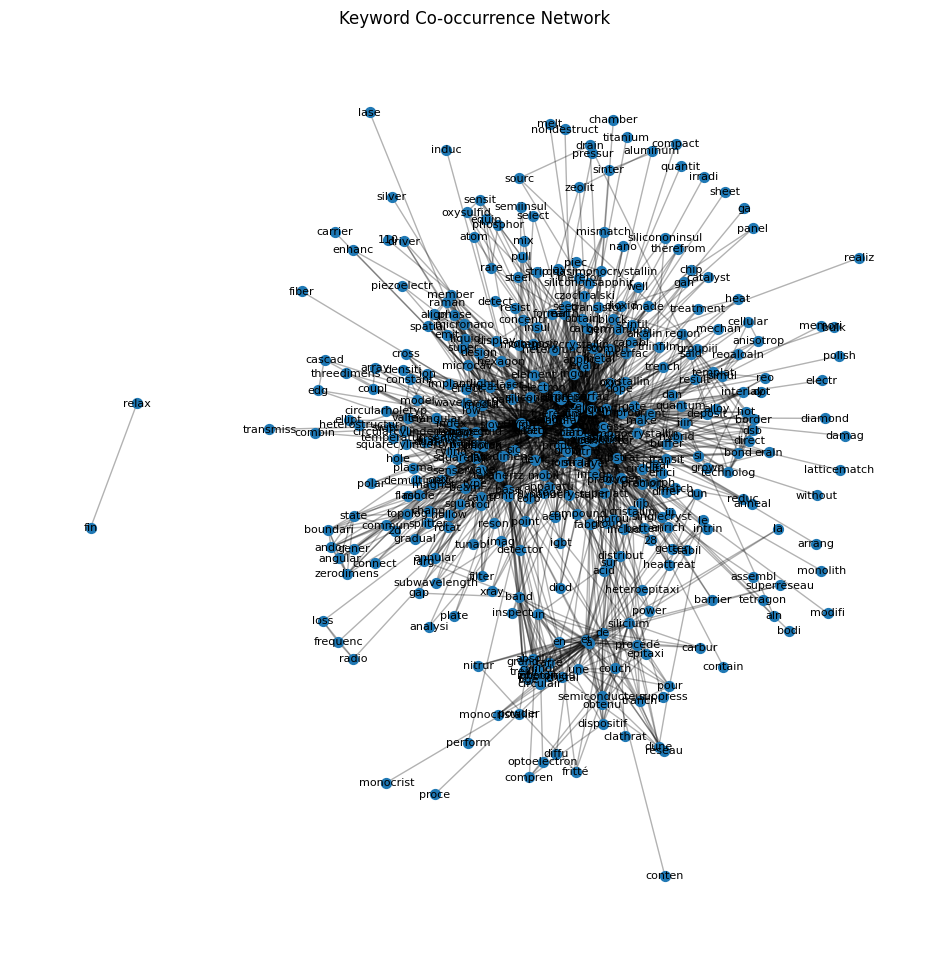

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, k=0.15, iterations=20)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Keyword Co-occurrence Network")
plt.axis("off")
plt.show()


In [ ]:
#calculate the degree centrality of nodes in tha graph 
#degree centrality is a measure of the number of direct connnections a node has 
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 keywords by degree centrality:")
print(top_degree)


Top 10 keywords by degree centrality:
[('crystal', 0.5322580645161291), ('silicon', 0.46505376344086025), ('method', 0.4274193548387097), ('photon', 0.26075268817204306), ('base', 0.2231182795698925), ('substrat', 0.217741935483871), ('devic', 0.217741935483871), ('lattic', 0.21236559139784947), ('singl', 0.16666666666666669), ('structur', 0.16397849462365593)]


dynamic term clustering

In [ ]:
#combine abstracts by year 
grouped = keyword_df.groupby("first filing year")["Title"].apply(lambda texts: " ".join(texts)).reset_index()


In [ ]:
#frequency analysis with TF
# from sklearn.feature_extraction.text import TfidfVectorizer

# # vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1,3))
# # tfidf_matrix = vectorizer.fit_transform(grouped["abstract"])
# feature_names = vectorizer.get_feature_names_out()


In [ ]:
from itertools import combinations
from collections import defaultdict

def build_cooccurrence(text: str, window_size: int = 5) -> dict:
    """
    Build a co-occurrence dictionary using a sliding window.
    
    Each window of 'window_size' tokens yields co-occurring pairs.
    """
    tokens = text.split()
    cooccurrences = defaultdict(int)
    
    # Iterate over all tokens with sliding window
    for i in range(len(tokens)):
        window = tokens[i:i + window_size]
        # Generate all combinations (order doesn't matter) from the current window
        for pair in combinations(window, 2):
            # Sort the pair to keep the ordering consistent (so ('a','b') is the same as ('b','a'))
            cooccurrences[tuple(sorted(pair))] += 1
    
    return cooccurrences

# Example usage:
# Assuming 'grouped' is your DataFrame and it contains a non-empty "abstract" column.
sample_text = grouped.loc[0, "Title"]  # Replace with your actual text if needed.
cooc = build_cooccurrence(sample_text, window_size=5)
print("Co-occurrence dictionary:")
print(dict(cooc))
print("Number of edges (unique pairs):", len(cooc))


Co-occurrence dictionary:
{('heteroepitaxi', 'structur'): 1}
Number of edges (unique pairs): 1


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
#identify clusters of similar documents based on the terms they contain 
# Suppose we use TF-IDF of a given time window
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Map terms to cluster centers can be done via:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_terms = {}
for i in range(num_clusters):
    cluster_terms[i] = [feature_names[ind] for ind in order_centroids[i, :10]]
    print("Cluster %d:" % i, cluster_terms[i])


Cluster 0: ['substrat', 'carbid', 'silicon carbid', 'silicon', 'silicon substrat', 'iiin', 'method', 'manufactur', 'reo', 'grown']
Cluster 1: ['semiconductor', 'semiconductor devic', 'devic', 'manufactur', 'method', 'method manufactur', 'semiconductor substrat', 'devic method', 'substrat', 'semiconductor devic method']
Cluster 2: ['crystal', 'photon', 'photon crystal', 'lattic', 'method', 'de', 'structur', 'base', 'crystal lattic', 'silicon']
Cluster 3: ['silicon', 'singl crystal', 'singl', 'crystal', 'wafer', 'method', 'silicon wafer', 'silicon singl crystal', 'silicon singl', 'film']
Cluster 4: ['epitaxi', 'growth', 'singl crystal', 'singl', 'substrat', 'crystal', 'epitaxi growth', 'crystal substrat', 'singl crystal substrat', 'silicon']


In [ ]:
import networkx as nx
from networkx.algorithms import community
#identify groups of terms that frequently co-occur 
# Build graph from aggregated co-occurrence (for a single time window)
G = nx.Graph()
for (term1, term2), weight in cooc.items():
    if weight > 1:
        G.add_edge(term1, term2, weight=weight)

# Detect communities using a greedy modularity algorithm
communities = community.greedy_modularity_communities(G)
print("Communities:")
for idx, comm in enumerate(communities, start=1):
    print(f"Cluster {idx}:", sorted(comm))


Communities:


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
#analyze abstracts over periods to find topics using LDA method 
# LDA is a method used to discover topics in a collection of documents by analyzing word patterns 
window_size = 10  # Years
cooc_networks = defaultdict(dict)

# Fit vectorizer on FULL dataset first to maintain consistent vocabulary
full_vectorizer = TfidfVectorizer(
    max_df=0.85, 
    min_df=2, 
    ngram_range=(1, 4),
    stop_words='english'
)
full_matrix = full_vectorizer.fit_transform(abstracts)

for center_year in range(keyword_df['first filing year'].min(), keyword_df['first filing year'].max()-window_size+1):
    window_data = keyword_df[keyword_df['first filing year'].between(center_year, center_year+window_size)]
    
    # Skip empty windows
    if len(window_data) == 0:
        print(f"Skipping empty window: {center_year}-{center_year+window_size}")
        continue
        
    # Use SAME vectorizer to maintain feature space
    try:
        window_matrix = full_vectorizer.transform(window_data['Title'])
        
        # Validate matrix has non-zero entries
        if window_matrix.sum() == 0:
            print(f"Empty features in window {center_year}-{center_year+window_size}")
            continue
            
        # Train LDA
        lda = LatentDirichletAllocation(n_components=2, random_state=42)
        lda.fit(window_matrix)
        
        # Extract and display topics with year window
        feature_names = full_vectorizer.get_feature_names_out()  # Get the feature names (words)
        print(f"Year Window: {center_year}-{center_year + window_size}")
        for topic_idx, topic in enumerate(lda.components_):
            print(f"Topic {topic_idx + 1}:")
            # Get the top 10 words for each topic
            top_words_indices = topic.argsort()[-10:][::-1]  # Get indices of the top 10 words
            top_words = [feature_names[i] for i in top_words_indices]  # Get the actual words
            print(" ".join(top_words))  # Print the top words for the topic
        print("\n")  # Add a newline for better readability
        
    except ValueError as e:
        print(f"Error in {center_year}: {str(e)}")
        continue

Year Window: 1973-1983
Topic 1:
singl crystal singl crystal silicon singl crystal silicon singl materi arsenid singl gallium arsenid singl arsenid singl crystal gallium arsenid singl crystal
Topic 2:
heteroepitaxi display high silicon silicon steel high silicon steel strip steel strip high silicon steel strip steel silicon steel strip


Year Window: 1974-1984
Topic 1:
singl crystal singl crystal silicon singl crystal silicon singl materi arsenid singl gallium arsenid singl arsenid singl crystal gallium arsenid singl crystal
Topic 2:
display heteroepitaxi high silicon silicon steel high silicon steel strip steel strip high silicon steel strip steel silicon steel strip


Year Window: 1975-1985
Topic 1:
singl crystal singl crystal silicon singl crystal silicon singl silicon materi arsenid singl gallium arsenid singl arsenid singl crystal
Topic 2:
display high silicon silicon steel high silicon steel strip steel strip high silicon steel strip steel silicon steel strip high


Year Window: 1

In [ ]:
# from sklearn.decomposition import LatentDirichletAllocation 
# from sklearn.feature_extraction.text import TfidfVectorizer
# from collections import defaultdict
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud
# import numpy as np

# # Assuming 'abstracts' is a list or series of document texts and 
# # 'keyword_df' is a DataFrame containing the 'first filing year' column and 'abstract' texts.

# # Parameters and container for storing results
# window_size = 10  # Years
# results = []      # Will store tuples: (start_year, [topic1_dict, topic2_dict, ...])

# # Fit vectorizer on the FULL dataset to maintain a consistent vocabulary
# full_vectorizer = TfidfVectorizer(
#     max_df=0.85, 
#     min_df=2, 
#     ngram_range=(1, 4),
#     stop_words='english'
# )
# full_matrix = full_vectorizer.fit_transform(abstracts)

# # Iterate through time windows
# for center_year in range(keyword_df['first filing year'].min(), 
#                          keyword_df['first filing year'].max()-window_size+1):
#     window_data = keyword_df[keyword_df['first filing year'].between(center_year, center_year+window_size)]
    
#     # Skip empty windows
#     if window_data.empty:
#         print(f"Skipping empty window: {center_year}-{center_year+window_size}")
#         continue
        
#     try:
#         # Use the same vectorizer to maintain the feature space
#         window_matrix = full_vectorizer.transform(window_data['abstract'])
        
#         # Check if the window has any non-zero features
#         if window_matrix.sum() == 0:
#             print(f"Empty features in window {center_year}-{center_year+window_size}")
#             continue

#         # Train LDA for 2 topics
#         lda = LatentDirichletAllocation(n_components=2, random_state=42)
#         lda.fit(window_matrix)
        
#         # For visualization, we will build dictionaries for each topic's top words
#         feature_names = full_vectorizer.get_feature_names_out()
#         topic_dicts = []
#         for topic_idx, topic in enumerate(lda.components_):
#             # Select the top 10 words and their weights
#             top_indices = topic.argsort()[-10:][::-1]
#             topic_words = {feature_names[i]: topic[i] for i in top_indices}
#             topic_dicts.append(topic_words)
            
#             # You can also print to the console for debugging:
#             print(f"Year Window: {center_year}-{center_year+window_size}, Topic {topic_idx+1}:")
#             print(" ".join([feature_names[i] for i in top_indices]))
#             print("\n")
        
#         # Store the results for this time window (use center year as a label)
#         results.append((center_year, topic_dicts))
        
#     except ValueError as e:
#         print(f"Error in {center_year}: {str(e)}")
#         continue

# # Visualizing the topics as word clouds

# # Determine the grid size for the subplots.
# num_windows = len(results)
# num_topics = 2  # As per our LDA setting

# # Create the subplots: adjust the figure size accordingly.
# fig, axs = plt.subplots(num_windows, num_topics, figsize=(num_topics*6, num_windows*4))

# # If only one window is available, ensure axs is iterable
# if num_windows == 1:
#     axs = np.expand_dims(axs, axis=0)

# # Loop over windows and topics, and create a word cloud for each topic.
# for i, (start_year, topic_dicts) in enumerate(results):
#     for j, topic in enumerate(topic_dicts):
#         # Create a word cloud from the topic dictionary
#         wordcloud = WordCloud(width=400, height=300, background_color='white')
#         wordcloud.generate_from_frequencies(topic)
        
#         # Select the proper axes (if only one row, axs might be 1D)
#         ax = axs[i, j] if num_windows > 1 else axs[j]
#         ax.imshow(wordcloud, interpolation='bilinear')
#         ax.set_title(f"Window {start_year}-{start_year + window_size}\nTopic {j+1}")
#         ax.axis('off')

# plt.tight_layout()
# plt.show()


In [ ]:
keyword_df.head()

first publication number                                              Title  \
0              CA2646325A1  dispositif spintroniqu conten de dopant spintr...   
1             JPS58140112A                              silicon singl crystal   
2             CN105762223A  method improv silicon surfac lattic shine mult...   
3            JP2011111372A  silicon carbid singl crystal method produc sil...   
4             CN100442443C  method prepar high electron mobil hydrogen nan...   

   first filing year                                           keywords  
0               2007  [dispositif, spintroniqu, conten, de, dopant, ...  
1               1983                          [silicon, singl, crystal]  
2               2016  [method, improv, silicon, surfac, lattic, shin...  
3               2011  [silicon, carbid, singl, crystal, method, prod...  
4               2006  [method, prepar, high, electron, mobil, hydrog...

analyzing the evolution of topics in patent abstracts over time using adaptive window detection and LDA topic modeling

In [ ]:
df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country'],
      dtype='object')

In [ ]:
df_papers.columns

Index(['Title', 'Abstract', 'PublicationVenueName', 'PublicationVenueType',
       'Year', 'ReferenceCount', 'CitationCount', 'InfluentialCitationCount',
       'FieldsOfStudy', 'PublicationTypes', 'PublicationDate', 'Authors',
       'year'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.stats import entropy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import seaborn as sns

# ======================
# CONFIGURATION
# ======================
config = {
    'min_year': 2000,
    'min_docs_per_year': 2,       # lowered threshold for testing
    'global_min_df': 1,           # allow sparse terms for debugging
    'global_max_df': 0.9,
    'divergence_percentile': 80,
    'max_topics': 5,
    'top_words_per_topic': 10,
    'min_window_span': 1          # allow single-year windows for testing
}

# ======================
# UTILITY FUNCTIONS
# ======================
def jensen_shannon(p, q): #computes a symmetric divergence between two probability distibutions
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))
#measure how different two distributions are in symmetric bounded way 
#KL(kullbac-leibler) divegence : entropy(p,m) measures how one probability distribution diverges from a second  

def safe_divide(a, b): #divides element-wise but returns 0 where the denominator is 0
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

# ======================
# DATA PREPARATION
# ======================
keyword_df = keyword_df[keyword_df['first filing year'] >= config['min_year']]
keyword_df = keyword_df.sort_values('first filing year')

# Debug: print basic info about data
print("DataFrame shape:", keyword_df.shape)
print("Years range:", keyword_df['first filing year'].min(), "-", keyword_df['first filing year'].max())

docs = keyword_df['Title'].str.lower().str.replace(r'[^\w\s-]', '', regex=True).tolist()
years = keyword_df['first filing year'].astype(int).values

# ======================
# GLOBAL VOCABULARY
# ======================
global_vectorizer = CountVectorizer( #builds a single bag-of-words across all documents
    min_df=config['global_min_df'],
    max_df=config['global_max_df'],
    ngram_range=(1, 2),
    stop_words='english'
)
global_vocab = global_vectorizer.fit(docs)
print("Global vocab size:", len(global_vectorizer.vocabulary_))

# ======================
# ADAPTIVE WINDOW DETECTION
# ======================
yearly_counts = []
valid_years = []

unique_years = np.unique(years)
print("Unique years in data:", unique_years)
for year in unique_years: #for each year with more than 2 docs ,get its term-frequency vector 
    year_mask = years == year
    num_docs = sum(year_mask)
    if num_docs >= config['min_docs_per_year']:
        try:
            counts = global_vectorizer.transform(np.array(docs)[year_mask]).sum(axis=0).A1
            yearly_counts.append((year, counts))
            valid_years.append(year)
        except Exception as e:
            print(f"Skipping {year} due to error: {str(e)}")
            continue

print("Valid years detected for windowing:", valid_years)

if len(yearly_counts) < 2:
    raise ValueError(f"Only {len(yearly_counts)} valid years found. Need at least 2.")

divergences = []
for i in range(1, len(yearly_counts)): #Normalize counts into distributions and compute jensen-shannon divergence year to year
    prev = yearly_counts[i-1][1] + 1e-12 #smoothing to avoid zero probablities 
    curr = yearly_counts[i][1] + 1e-12
    prev = safe_divide(prev, prev.sum()) #for each year-vector , divide by its total word-count 
    curr = safe_divide(curr, curr.sum())
    div = jensen_shannon(prev, curr)
    divergences.append(div)

print("Calculated divergences:", divergences)
threshold = np.percentile(divergences, config['divergence_percentile']) if divergences else 0
print("Divergence threshold (", config['divergence_percentile'], "percentile):", threshold)

change_points = [0] + [i for i, d in enumerate(divergences) if d > threshold] + [len(yearly_counts)]
change_points = sorted(list(set(change_points)))
print("Change points indices:", change_points)
#any year to year jump with divergence above 85% of all the year to year divergence values marks a boundary
windows = [] #each window is a consecutive block of years between change points filtered by minimum span 
for i in range(1, len(change_points)):
    start_idx = change_points[i-1]
    end_idx = change_points[i]
    window_years = [yearly_counts[j][0] for j in range(start_idx, end_idx)]
    if not window_years:
        continue
    try:
        window_start = min(window_years)
        window_end = max(window_years)
        if (window_end - window_start) < config['min_window_span']:
            continue
    except ValueError:
        continue
    windows.append({
        'start': window_start,
        'end': window_end,
        'years': window_years
    })
    
print("Detected windows:")
for w in windows:
    print(w)

if not windows:
    raise ValueError("No valid time windows detected. Try adjusting parameters.")

# ======================
# TOPIC MODELING
# ======================
tfidf_vectorizer = TfidfVectorizer(
    vocabulary=global_vectorizer.vocabulary_,
    ngram_range=(1, 2)
)
full_matrix = tfidf_vectorizer.fit_transform(docs)
feature_names = tfidf_vectorizer.get_feature_names_out()

topic_evolution = []

for window in windows: # for each detected window choose a number of topics based on window size and fit an LDA model to extract top words per topic and save them 
    window_mask = keyword_df['first filing year'].isin(window['years'])
    window_matrix = full_matrix[window_mask]
    
    if window_matrix.shape[0] == 0:
        continue
        
    n_topics = max(1, min(config['max_topics'], window_matrix.shape[0] // 50))
    print(f"Window {window['start']}-{window['end']} with {window_matrix.shape[0]} docs. Using {n_topics} topics.")
    
    try:
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=42,
            learning_method='online'
        )
        lda.fit(window_matrix)
        
        for topic_idx, topic in enumerate(lda.components_):
            top_indices = topic.argsort()[-config['top_words_per_topic']:][::-1]
            top_words = [feature_names[i] for i in top_indices]
            topic_evolution.append({
                'start': window['start'],
                'end': window['end'],
                'topic_id': f"{window['start']}-{topic_idx+1}",
                'words': top_words,
                'weights': topic[top_indices]
            })
            print(f"Topic {window['start']}-{topic_idx+1}: {top_words}")
    except Exception as e:
        print(f"Failed modeling {window['start']}-{window['end']}: {str(e)}")
        continue




DataFrame shape: (411, 4)
Years range: 2000 - 2025
Global vocab size: 2684
Unique years in data: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025]
Valid years detected for windowing: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Calculated divergences: [np.float64(0.492235753438035), np.float64(0.4376215711950891), np.float64(0.4651581224930795), np.float64(0.3804637865094247), np.float64(0.35738475796111224), np.float64(0.41907027490905374), np.float64(0.42545424472397886), np.float64(0.431948866172607), np.float64(0.5159252392196506), np.

In [ ]:
import plotly.express as px
import pandas as pd

# Prepare divergence data in a DataFrame
div_df = pd.DataFrame({
    'Year': valid_years[1:],  # Divergences correspond to year changes starting from the second valid year
    'Divergence': divergences
})

# Create a line plot for term distribution divergences over years with markers
fig = px.line(div_df, x='Year', y='Divergence',
              title='Automatic Topic Shift Detection',
              markers=True)

# Add a horizontal line for the divergence threshold
fig.add_hline(y=threshold, line_dash="dash", line_color="red",
              annotation_text="Change Threshold", annotation_position="bottom right")

# Create vertical spans for each detected window using layout shapes
shapes = []
for window in windows:
    shapes.append({
        'type': 'rect',
        'xref': 'x',
        'yref': 'paper',
        'x0': window['start'],
        'x1': window['end'],
        'y0': 0,
        'y1': 1,
        'fillcolor': 'gray',
        'opacity': 0.2,
        'layer': 'below',
        'line': {'width': 0},
    })

fig.update_layout(
    shapes=shapes,
    xaxis_title='Year',
    yaxis_title='Jensen-Shannon Divergence'
)

fig.show()


In [ ]:
import pandas as pd
import plotly.express as px
#each cell in the heatmap is a raw count of how many times a given term showed up amont the top words of all topics in that window
# ----------------------
# Build the Term Matrix
# ----------------------
all_terms = list(set([word for t in topic_evolution for word in t['words']]))
term_matrix = pd.DataFrame(index=all_terms)

for window in windows:
    # Collect all terms for this window
    window_terms = [word for t in topic_evolution 
                    if t['start'] == window['start'] 
                    for word in t['words']]
    term_counts = pd.Series(window_terms).value_counts()
    term_matrix[window['start']] = term_counts

# Fill missing values and sort by window year (the DataFrame rows)
term_matrix = term_matrix.fillna(0).T.sort_index()

# Debug print: Check available columns (terms)
print("Term matrix columns:", term_matrix.columns.tolist())

# ----------------------
# Plotting with Plotly Express
# ----------------------
if not term_matrix.empty and not term_matrix.sum().nlargest(1).empty:
    # Select the top 25 terms across windows based on total counts
    top_terms = term_matrix.sum().nlargest(25).index
    selected_terms = [term for term in top_terms if term in term_matrix.columns]
    
    if selected_terms:
        # Prepare the heatmap data: subset and transpose to have Terms as rows
        heat_data = term_matrix[selected_terms].T
        
        # Create the interactive heatmap
        fig = px.imshow(heat_data,
                        text_auto=".1f",
                        color_continuous_scale='YlOrBr',
                        aspect="auto",
                        labels={"x": "Time Window Start Year", "y": "Term", "color": "Count"},
                        title="Top Terms Across Time Windows")
        fig.update_layout(title_x=0.5)
        fig.show()
    else:
        print("⚠️ No common top terms found across windows to plot heatmap.")
else:
    print("⚠️ Term matrix is empty — skipping heatmap plot.")


Term matrix columns: ['structur', 'manufactur', 'silicon carbid', 'iiin', 'materi', 'photon', 'carbid', 'templat', 'silicium', 'method', 'substrat', 'base', 'silicon', 'devic', 'cell', 'semiconductor devic', 'devic method', 'solar', 'process', 'reo', 'photon crystal', 'singl', 'silicon singl', 'crystal', 'silicon wafer', 'semiconductor', 'refract', 'manufactur semiconductor', 'semiconductor structur', 'si', 'singl crystal', 'rod', 'squarelattic', 'method manufactur', 'lattic', 'solar cell', 'wafer', 'squarelattic photon']


In [ ]:
import plotly.express as px
from wordcloud import WordCloud

# 3. Evolving Word Clouds with Plotly Express
for window in windows:
    # Collect terms for the current window
    terms = [word for t in topic_evolution 
             if t['start'] == window['start'] 
             for word in t['words']]
    
    if not terms:
        continue
    
    # Generate the word cloud image using the WordCloud library
    wordcloud = WordCloud(width=1200, height=800, 
                          background_color='white',
                          colormap='tab10').generate(' '.join(terms))
    
    # Convert the word cloud to a NumPy array (RGB image)
    wc_array = wordcloud.to_array()
    
    # Use Plotly Express to display the word cloud image interactively
    fig = px.imshow(wc_array)
    fig.update_layout(
        title_text=f"{window['start']}-{window['end']} Key Concepts",
        title_x=0.5,
        xaxis={'visible': False},
        yaxis={'visible': False}
    )
    fig.show()


extract the topic of each patent 

In [ ]:
classifications_df = pd.read_csv('classification_df.csv', sep=';')

In [ ]:

def get_ipc_meaning(ipc_list, classification_df):
    """
    Extract the first three characters from the first IPC code in the list and
    return the corresponding Meaning from classification_df.
    
    Parameters:
      ipc_list: list of IPC code strings.
      classification_df: DataFrame with columns 'IPC_Code' and 'Meaning'.
    """
    if not ipc_list:
        return None

    # Extract the first three characters, e.g., "B60" from "B60L3/00"
    code_extracted = ipc_list[0][:3]

    # Look for a row in classification_df where the IPC_Code starts with the extracted code.
    match = classification_df[classification_df['CPC Symbol'].str.startswith(code_extracted)]
    if not match.empty:
        return match.iloc[0]['Classification Title']
    else:
        # Fallback option: try to get the general meaning based on the section letter.
        section_letter = code_extracted[0]
        match_section = classification_df[classification_df['CPC Symbol'] == section_letter]
        if not match_section.empty:
            return match_section.iloc[0]['Classification Title']
    return None

# Create a new column in the patents DataFrame with the IPC meaning
df['IPC_Meaning'] = df['IPC'].apply(lambda ipc_list: get_ipc_meaning(ipc_list, classifications_df))

df.head()


No                                              Title  \
0   1  DISPOSITIFS SPINTRONIQUES CONTENANT DES DOPANT...   
1   2                             SILICON SINGLE CRYSTAL   
2   3  Method for improving silicon surface lattice s...   
3   4  SILICON CARBIDE SINGLE CRYSTAL, METHOD FOR PRO...   
4   5  Method for preparing high electron mobility hy...   

                                           Inventors  \
0  DUKOVSKI ILIJA [US] \r\nMEARS ROBERT J [US] \r...   
1                                       ADACHI SADAO   
2                                           LI XIANG   
3                     KOYANAGI NAOKI \r\nKOKOI HISAO   
4  SHEN WENZHONG CHEN [CN] \r\nWENZHONG SHEN [CN]...   

                       Applicants             Publication number  \
0     MEARS TECHNOLOGIES INC [US]                    CA2646325A1   
1    NIPPON TELEGRAPH & TELEPHONE                   JPS58140112A   
2  ZHEJIANG FORTUNE ENERGY CO LTD                   CN105762223A   
3                  SHOWA DENKO KK  JP2011111372A \r\nJP5398492B2   
4     UNIV SHANGHAI JIAOTONG [CN]    CN100442443C \r\nCN1737999A   

  Earliest priority                                                IPC  \
0        2006-03-17                  [H01L29/15, H01L29/66, H10N50/10]   
1        1982-02-16  [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...   
2        2014-12-17                             [C30B33/10, H01L31/18]   
3        2009-11-27                                        [C30B29/36]   
4        2005-09-08                 [C23C16/24, C23C16/44, H01L21/205]   

                                                 CPC  \
0  [B82Y10/00 (EP), B82Y25/00 (EP), B82Y40/00 (EP...   
1              [H01L21/0242 (EP), H01L21/02532 (EP)]   
2                                   [Y02P70/50 (EP)]   
3                                          [unkown)]   
4                                          [unkown)]   

            Publication date Earliest publication  ...  \
0                 2007-09-27           2007-09-27  ...   
1                 1983-08-19           1983-08-19  ...   
2                 2016-07-13           2016-07-13  ...   
3  2011-06-09 \r\n2014-01-29           2011-06-09  ...   
4  2006-02-22 \r\n2008-12-10           2006-02-22  ...   

   first publication date second publication date first publication number  \
0              2007-09-27                    None              CA2646325A1   
1              1983-08-19                    None             JPS58140112A   
2              2016-07-13                    None             CN105762223A   
3              2011-06-09              2014-01-29            JP2011111372A   
4              2006-02-22              2008-12-10             CN100442443C   

  second publication number first publication country  \
0                      None                        CA   
1                      None                        JP   
2                      None                        CN   
3           \r\nJP5398492B2                        JP   
4            \r\nCN1737999A                        CN   

  second publication country first filing year  earliest priority year  \
0                       None              2007                    2006   
1                       None              1983                    1982   
2                       None              2016                    2014   
3                       \r\n              2011                    2009   
4                       \r\n              2006                    2005   

   applicant country                                        IPC_Meaning  
0                 US                                  ELECTRIC ELEMENTS  
1                NaN                                  ELECTRIC ELEMENTS  
2                NaN                                     CRYSTAL GROWTH  
3                NaN                                     CRYSTAL GROWTH  
4                 CN  COATING METALLIC MATERIAL COATING MATERIAL WIT...  

[5 rows x 21 columns]

In [ ]:
fieldOfStudy_df = pd.read_csv('IPC_to_fieldOfStudy.csv')

In [ ]:
import ast

# 1) If you still have strings, first convert them:
fieldOfStudy_df['fields'] = fieldOfStudy_df['fields'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 2) Define a small helper to normalize any sub‐field containing “engineering”
def normalize_engineering(field_list):
    seen = set()
    out = []
    for f in field_list:
        if 'engineering' in f.lower():
            norm = 'Engineering'
        else:
            norm = f
        # preserve order & drop duplicates
        if norm not in seen:
            seen.add(norm)
            out.append(norm)
    return out

# 3) Apply it:
fieldOfStudy_df['fields'] = fieldOfStudy_df['fields'].apply(normalize_engineering)


In [ ]:
fieldOfStudy_df.head()

Unnamed: 0  IPC                                        description  \
0           0  A01  Agriculture, Forestry, Animal Husbandry, Hunti...   
1           1  A21                              Baking, Edible Doughs   
2           2  A22  Butchering, Meat Treatment, Processing Poultry...   
3           3  A23  Foods or Foodstuffs, Treatment Not Covered by ...   
4           4  A24  Tobacco, Cigars, Cigarettes, Simulated Smoking...   

                                          fields  
0  [Environmental Science, Biology, Engineering]  
1         [Food Science, Engineering, Chemistry]  
2           [Food Science, Biology, Engineering]  
3             [Food Science, Chemistry, Biology]  
4         [Medicine, Public Health, Engineering]

In [ ]:
import pandas as pd
import ast


# Ensure IPC codes are 3 characters and uppercase
fieldOfStudy_df['IPC'] = fieldOfStudy_df['IPC'].str[:3].str.strip().str.upper()
ipc_mapping = fieldOfStudy_df.set_index('IPC')['fields'].to_dict()


def get_patent_fields(ipc_list):
    try:
        if not isinstance(ipc_list, list) or len(ipc_list) == 0:
            return ['Unclassified']
        
        # Get first IPC code and clean it
        first_code = str(ipc_list[0]).strip().upper()
        ipc_prefix = first_code[:3]
        
        return ipc_mapping.get(ipc_prefix, ['General Technology'])
        
    except Exception as e:
        print(f"Error processing: {ipc_list} - {str(e)}")
        return ['Unclassified']

# Convert string representations to actual lists if needed
if isinstance(df['IPC'].iloc[0], str):
    df['IPC'] = df['IPC'].apply(ast.literal_eval)

df['fields'] = df['IPC'].apply(get_patent_fields)


print("\nFirst 5 Patent Classifications:")
df[['IPC', 'fields']].head()


First 5 Patent Classifications:


IPC  \
0                  [H01L29/15, H01L29/66, H10N50/10]   
1  [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...   
2                             [C30B33/10, H01L31/18]   
3                                        [C30B29/36]   
4                 [C23C16/24, C23C16/44, H01L21/205]   

                                          fields  
0               [Engineering, Materials Science]  
1               [Engineering, Materials Science]  
2  [Crystallography, Materials Science, Physics]  
3  [Crystallography, Materials Science, Physics]  
4               [Engineering, Materials Science]

In [ ]:
df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields'],
      dtype='object')

In [ ]:
import ast

df['fields'] = df['fields'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
df['fields'].iloc[0]

['Engineering', 'Materials Science']

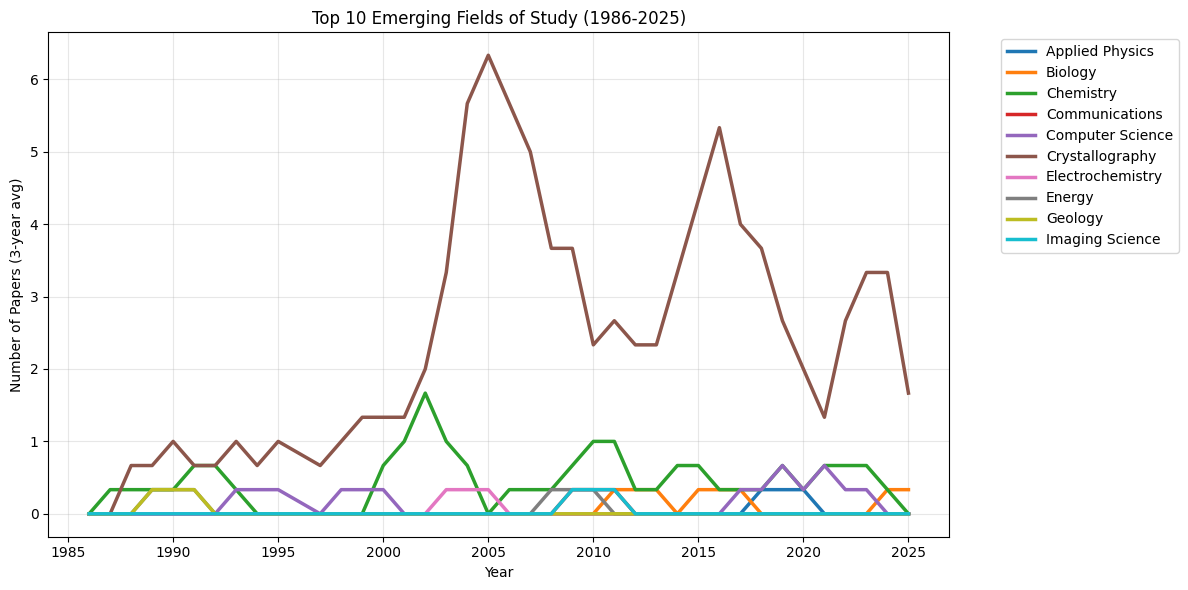

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

def plot_field_trends(sem_df, start_year=None, end_year=None, window_size=3, top_n=5):
    """
    Visualize top trending fields of study with customizable year window.
    
    Args:
        sem_df (pd.DataFrame): DataFrame containing 'Year' and 'FieldsOfStudy' columns
        start_year (int): First year to display (None for auto)
        end_year (int): Last year to display (None for auto)
        window_size (int): Years for rolling average (smoothing)
        top_n (int): Number of top fields to show
    """
    # Explode fields and count papers per year/field
    df_exploded = sem_df.explode('fields')
    field_counts = (
        df_exploded
        .groupby(['first filing year', 'fields'])
        .size()
        .reset_index(name='PaperCount')
    )
    
    # Pivot and smooth with rolling average
    field_pivot = field_counts.pivot(index='first filing year', columns='fields', values='PaperCount').fillna(0)
    field_pivot_smooth = field_pivot.rolling(window=window_size, min_periods=1).mean()
    
    # Filter by year window
    if start_year is None:
        start_year = field_pivot_smooth.index.min()
    if end_year is None:
        end_year = field_pivot_smooth.index.max()
    
    filtered = field_pivot_smooth.loc[start_year:end_year]
    
    # Calculate growth rates in the selected window
    growth = filtered.pct_change().mean()
    top_fields = growth.sort_values(ascending=False).head(top_n).index
    
    # Plotting
    plt.figure(figsize=(12, 6))
    for field in top_fields:
        plt.plot(filtered.index, filtered[field], label=field, linewidth=2.5)
    
    plt.title(f'Top {top_n} Emerging Fields of Study ({start_year}-{end_year})')
    plt.xlabel('Year')
    plt.ylabel(f'Number of Papers ({window_size}-year avg)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def interactive_field_trends(sem_df):
    """Create interactive widget for exploring trends"""
    years = sem_df['Year'].dropna().astype(int).unique()
    min_year, max_year = min(years), max(years)
    
    interact(
        plot_field_trends,
        sem_df=pd.DataFrame(sem_df),  # Fixed value
        start_year=IntSlider(min=min_year, max=max_year, value=min_year, step=1, description='Start Year'),
        end_year=IntSlider(min=min_year, max=max_year, value=max_year, step=1, description='End Year'),
        window_size=IntSlider(min=1, max=5, value=3, step=1, description='Smoothing'),
        top_n=IntSlider(min=3, max=10, value=5, step=1, description='Top N Fields')
    )

# Usage:
# For static plot with custom window:
plot_field_trends(df, start_year=1986, end_year=2025, window_size=3, top_n=10)

# For interactive exploration in Jupyter:
# interactive_field_trends(sem_df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def plot_field_trends(sem_df, fields_to_plot=None, smoothing_window=3, figsize=(12, 6)):
    """
    Plot trends of specified fields of study over time, or top growing fields if none specified.
    
    Parameters:
    - sem_df: Input DataFrame containing 'Year' and 'FieldsOfStudy' columns
    - fields_to_plot: List of specific fields to plot (if None, plots top 5 growing fields)
    - smoothing_window: Number of years for rolling average smoothing
    - figsize: Size of the output figure
    """
    # Explode FieldsOfStudy so each field gets its own row
    df_exploded = sem_df.explode('fields')
    
    # Group by Year and Field, then count papers
    field_counts = (
        df_exploded
        .groupby(['first filing year', 'fields'])
        .size()
        .reset_index(name='PaperCount')
    )
    
    # Pivot for heatmap-style analysis or trend lines
    field_pivot = field_counts.pivot(index='first filing year', columns='fields', values='PaperCount').fillna(0)
    
    # Smooth with rolling average
    field_pivot_smooth = field_pivot.rolling(window=smoothing_window, min_periods=1).mean()
    
    # Determine which fields to plot
    if fields_to_plot is None:
        # Calculate top growing fields if none specified
        recent_years = field_pivot_smooth.index[-3:]  # Last 3 years
        growth = field_pivot_smooth.loc[recent_years].pct_change().mean()
        fields_to_plot = growth.sort_values(ascending=False).head(5).index
        plot_title = 'Top 5 Emerging Fields of Study'
    else:
        # Use specified fields, filtering to only those available in data
        available_fields = [f for f in fields_to_plot if f in field_pivot_smooth.columns]
        if not available_fields:
            raise ValueError("None of the specified fields were found in the data")
        fields_to_plot = available_fields
        plot_title = 'Trends for Selected patent fields'
    
    # Plot trends
    plt.figure(figsize=figsize)
    for field in fields_to_plot:
        plt.plot(field_pivot_smooth.index, field_pivot_smooth[field], label=field)
    
    plt.title(plot_title)
    plt.xlabel('Year')
    plt.ylabel(f'Number of Papers (Smoothed, {smoothing_window}-year avg)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# To plot specific fields:
# plot_field_trends(sem_df, fields_to_plot=['Machine Learning', 'Neuroscience', 'Physics'])

# To plot top growing fields:
# plot_field_trends(sem_df)

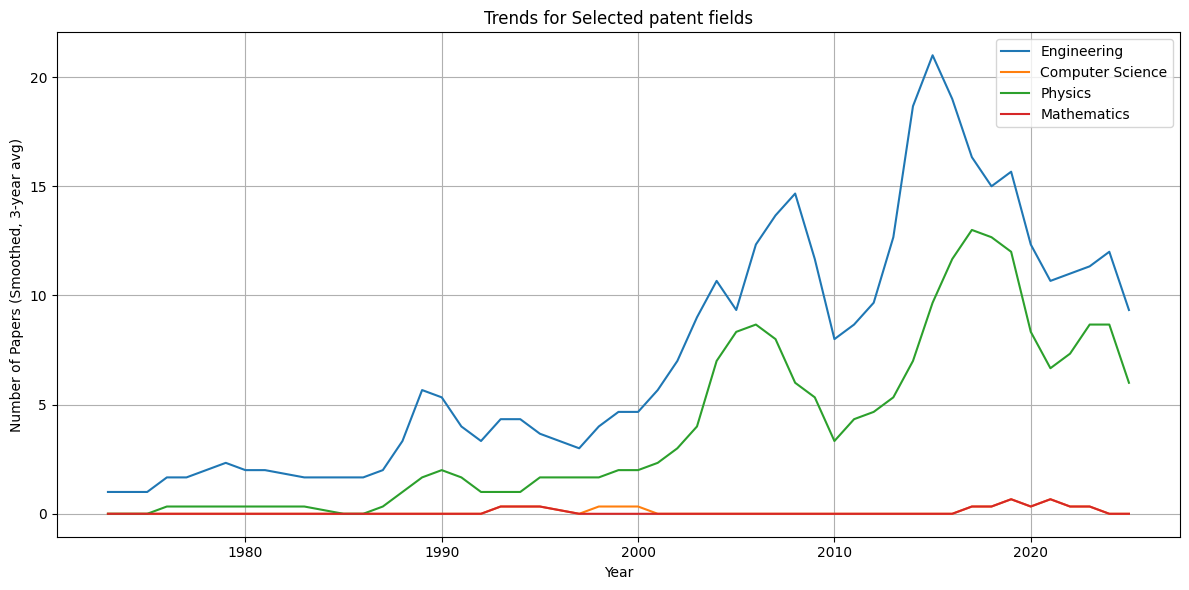

In [ ]:
plot_field_trends(df, fields_to_plot=['Engineering', 'Computer Science','Physics','Mathematics'])

In [ ]:
# Check year distribution
print("Year stats:")
print(keyword_df['first filing year'].describe())

# Check example parsed years
print("\nSample years:", keyword_df['first filing year'].head(3))

Year stats:
count     411.000000
mean     2012.630170
std         6.854193
min      2000.000000
25%      2007.000000
50%      2014.000000
75%      2018.000000
max      2025.000000
Name: first filing year, dtype: float64

Sample years: 179    2000
306    2000
488    2000
Name: first filing year, dtype: int32


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import linregress

# Convert years to integers and filter recent decades
keyword_df['year'] = keyword_df['first filing year'].astype(int)
keyword_df = keyword_df[keyword_df['year'] >= 2000]  # Focus on modern era

# Create 3-year bins for better signal
keyword_df['period'] = ((keyword_df['year'] - 2000) // 3).apply(
    lambda x: f"{(2000 + x*3)}-{(2002 + x*3)}"
)

# Create document count matrix using same vocabulary
count_vectorizer = CountVectorizer(
    vocabulary=vectorizer.get_feature_names_out(),  # Use existing TF-IDF features
    binary=False  # Get actual counts
)
count_matrix = count_vectorizer.fit_transform(keyword_df['Title'])

# Create period-term matrix with normalized frequencies
term_freq = pd.DataFrame(
    count_matrix.A,
    columns=count_vectorizer.get_feature_names_out(),
    index=keyword_df['period']
)
period_counts = term_freq.groupby(level=0).sum()
doc_counts = keyword_df['period'].value_counts()
normalized_freq = period_counts.div(doc_counts, axis=0)

In [ ]:
term_lifecycles = {}
for term in normalized_freq.columns:
    y = normalized_freq[term].values
    x = np.arange(len(y))
    
    if len(y) < 4 or y.sum() < 10:  # Minimum 4 periods & 10 total mentions
        continue
        
    slope, _, _, p_value, _ = linregress(x, y)
    term_lifecycles[term] = {
        'slope': slope,
        'p_value': p_value,
        'mean_freq': y.mean(),
        'trend_strength': np.corrcoef(x, y)[0,1]**2  # R²
    }

# Filter with adaptive thresholds
emerging_terms = [
    (term, data) for term, data in term_lifecycles.items()
    if (data['slope'] > 0) & 
       (data['p_value'] < 0.2) & 
       (data['trend_strength'] > 0.4) &
       (data['mean_freq'] > 0.001)
]

declining_terms = [
    (term, data) for term, data in term_lifecycles.items()
    if (data['slope'] < 0) & 
       (data['p_value'] < 0.2) & 
       (data['trend_strength'] > 0.4) &
       (data['mean_freq'] > 0.001)
]

In [ ]:
keyword_df.columns

Index(['first publication number', 'Title', 'first filing year', 'keywords',
       'year', 'period'],
      dtype='object')

In [ ]:
def plot_top_emerging_terms(top_n=5):
    if not emerging_terms:
        print("No emerging terms found")
        return
    
    # Get top N terms by slope
    top_terms = sorted(emerging_terms, key=lambda x: x[1]['slope'], reverse=True)[:top_n]
    
    plt.figure(figsize=(15, 10))
    from numpy.polynomial.polynomial import Polynomial

    for idx, (term, data) in enumerate(top_terms, 1):
        plt.subplot(3, 2, idx)  # 3 rows, 2 columns (adjust for top_n)
        normalized_freq[term].plot(
            marker='o', 
            color='green',
            linestyle='--',
            title=f"#{idx}: {term}\n(Slope: {data['slope']:.3f}, p={data['p_value']:.3f})"
        )

        plt.xlabel("Time Period")
        plt.ylabel("Normalized Frequency")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Generate visualization
plot_top_emerging_terms(5)

No emerging terms found


slope : direction/magnitude of trend a positive slope is emerging , negative is declining 
p_value : confidence in the trend , lower = more significant 
trend_strength : how well the trend fits the data R**2

In [ ]:
df.head()

No                                              Title  \
0   1  DISPOSITIFS SPINTRONIQUES CONTENANT DES DOPANT...   
1   2                             SILICON SINGLE CRYSTAL   
2   3  Method for improving silicon surface lattice s...   
3   4  SILICON CARBIDE SINGLE CRYSTAL, METHOD FOR PRO...   
4   5  Method for preparing high electron mobility hy...   

                                           Inventors  \
0  DUKOVSKI ILIJA [US] \r\nMEARS ROBERT J [US] \r...   
1                                       ADACHI SADAO   
2                                           LI XIANG   
3                     KOYANAGI NAOKI \r\nKOKOI HISAO   
4  SHEN WENZHONG CHEN [CN] \r\nWENZHONG SHEN [CN]...   

                       Applicants             Publication number  \
0     MEARS TECHNOLOGIES INC [US]                    CA2646325A1   
1    NIPPON TELEGRAPH & TELEPHONE                   JPS58140112A   
2  ZHEJIANG FORTUNE ENERGY CO LTD                   CN105762223A   
3                  SHOWA DENKO KK  JP2011111372A \r\nJP5398492B2   
4     UNIV SHANGHAI JIAOTONG [CN]    CN100442443C \r\nCN1737999A   

  Earliest priority                                                IPC  \
0        2006-03-17                  [H01L29/15, H01L29/66, H10N50/10]   
1        1982-02-16  [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...   
2        2014-12-17                             [C30B33/10, H01L31/18]   
3        2009-11-27                                        [C30B29/36]   
4        2005-09-08                 [C23C16/24, C23C16/44, H01L21/205]   

                                                 CPC  \
0  [B82Y10/00 (EP), B82Y25/00 (EP), B82Y40/00 (EP...   
1              [H01L21/0242 (EP), H01L21/02532 (EP)]   
2                                   [Y02P70/50 (EP)]   
3                                          [unkown)]   
4                                          [unkown)]   

            Publication date Earliest publication  ...  \
0                 2007-09-27           2007-09-27  ...   
1                 1983-08-19           1983-08-19  ...   
2                 2016-07-13           2016-07-13  ...   
3  2011-06-09 \r\n2014-01-29           2011-06-09  ...   
4  2006-02-22 \r\n2008-12-10           2006-02-22  ...   

   second publication date first publication number second publication number  \
0                     None              CA2646325A1                      None   
1                     None             JPS58140112A                      None   
2                     None             CN105762223A                      None   
3               2014-01-29            JP2011111372A           \r\nJP5398492B2   
4               2008-12-10             CN100442443C            \r\nCN1737999A   

  first publication country second publication country first filing year  \
0                        CA                       None              2007   
1                        JP                       None              1983   
2                        CN                       None              2016   
3                        JP                       \r\n              2011   
4                        CN                       \r\n              2006   

  earliest priority year  applicant country  \
0                   2006                 US   
1                   1982                NaN   
2                   2014                NaN   
3                   2009                NaN   
4                   2005                 CN   

                                         IPC_Meaning  \
0                                  ELECTRIC ELEMENTS   
1                                  ELECTRIC ELEMENTS   
2                                     CRYSTAL GROWTH   
3                                     CRYSTAL GROWTH   
4  COATING METALLIC MATERIAL COATING MATERIAL WIT...   

                                          fields  
0               [Engineering, Materials Science]  
1               [Engineering, Materials Science]  
2  [Crystallography, Materials Science, Physics]

In [ ]:
import pandas as pd
from collections import defaultdict
from scipy.stats import linregress

def track_cooccurrence_trends(df: pd.DataFrame, 
                             time_col: str = 'year',
                             text_col: str = 'abstract',
                             window_size: int = 5,
                             min_count: int = 5) -> pd.DataFrame:
    """
    Track co-occurrence trends over time with statistical significance
    
    Args:
        df: DataFrame containing temporal text data
        time_col: Column name for time periods (years)
        text_col: Column name containing text to analyze
        window_size: Window size for co-occurrence detection
        min_count: Minimum total occurrences to consider
        
    Returns:
        DataFrame with co-occurrence pairs and trend metrics
    """
    # Group documents by time period
    time_groups = df.groupby(time_col)[text_col].agg(list)
    
    # Store co-occurrence frequencies by year
    temporal_counts = defaultdict(lambda: defaultdict(int))
    
    # Process each time period
    for year, documents in time_groups.items():
        year_cooc = defaultdict(int)
        
        # Process each document in the time period
        for doc in documents:
            pairs = build_cooccurrence(doc, window_size)
            for pair, count in pairs.items():
                year_cooc[pair] += count
                
        # Store annual counts
        for pair, count in year_cooc.items():
            temporal_counts[pair][year] = count
    
    # Convert to DataFrame and calculate trends
    cooc_df = pd.DataFrame.from_dict(temporal_counts, orient='index')
    
    # Calculate trend metrics
    trend_data = []
    for pair, counts in cooc_df.iterrows():
        years = counts.dropna().index.astype(int)
        freqs = counts.dropna().values
        
        if len(years) < 3 or sum(freqs) < min_count:
            continue  # Skip sparse pairs
            
        # Calculate linear regression
        slope, _, _, p_value, _ = linregress(years, freqs)
        
        trend_data.append({
            'term1': pair[0],
            'term2': pair[1],
            'slope': slope,
            'p_value': p_value,
            'total_count': sum(freqs),
            'first_year': years.min(),
            'last_year': years.max(),
            'frequency_history': list(zip(years, freqs))
        })
    
    return pd.DataFrame(trend_data)

# Example usage:
cooc_trends = track_cooccurrence_trends(
    grouped,
    time_col='first filing year',
    text_col='Title',
    window_size=5,
    min_count=10
)

# Get top emerging combinations
emerging_tech = cooc_trends[
    (cooc_trends.slope > 0) &
    (cooc_trends.p_value < 0.05)
].sort_values('slope', ascending=False)

print("Top emerging technology combinations:")
print(emerging_tech[['term1', 'term2', 'slope', 'total_count']].head(5))

Top emerging technology combinations:
             term1          term2     slope  total_count
287             et              à  1.153846         13.0
81            grow  semiconductor  1.000000         16.0
128  semiconductor          singl  0.384858         32.0
274         lattic         photon  0.315616         44.0
229         carbid        crystal  0.284183         75.0


In [ ]:
# Select top term pairs for visualization
top_terms = emerging_tech.head(5)  # Adjust the number as needed

# Prepare data for plotting
plot_data = []
for _, row in top_terms.iterrows():
    for year, freq in row['frequency_history']:
        plot_data.append({
            'year': year,
            'frequency': freq,
            'term_pair': f"{row['term1']} & {row['term2']}"
        })

plot_df = pd.DataFrame(plot_data)

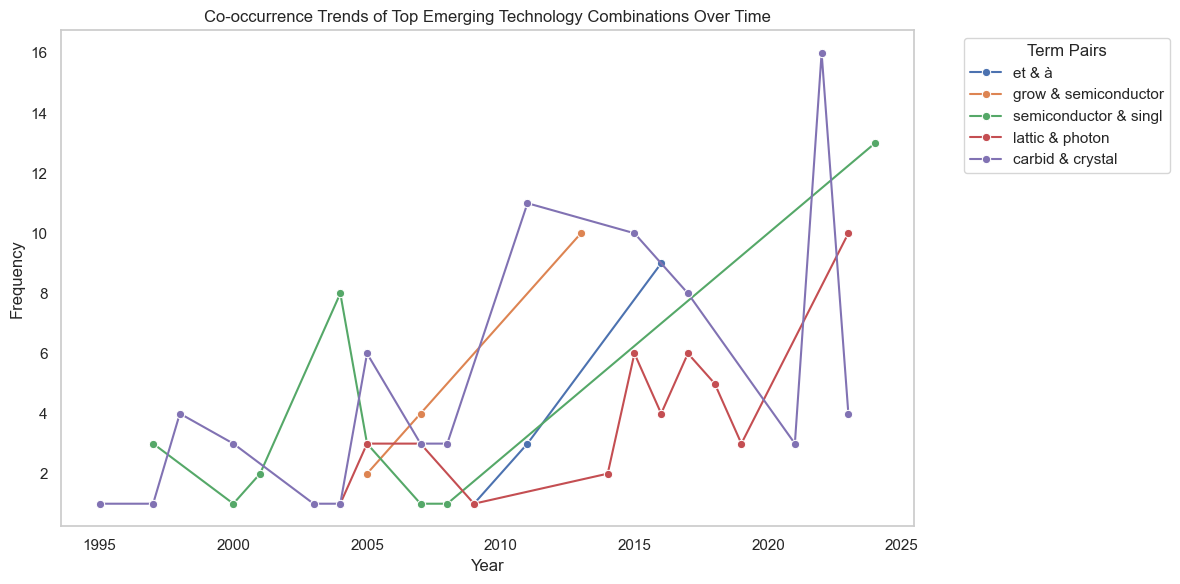

In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=plot_df, x='year', y='frequency', hue='term_pair', marker='o')
plt.title('Co-occurrence Trends of Top Emerging Technology Combinations Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Term Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [ ]:
declining_tech = cooc_trends[
    (cooc_trends.slope < 0) &
    (cooc_trends.p_value < 0.05)
].sort_values('slope')

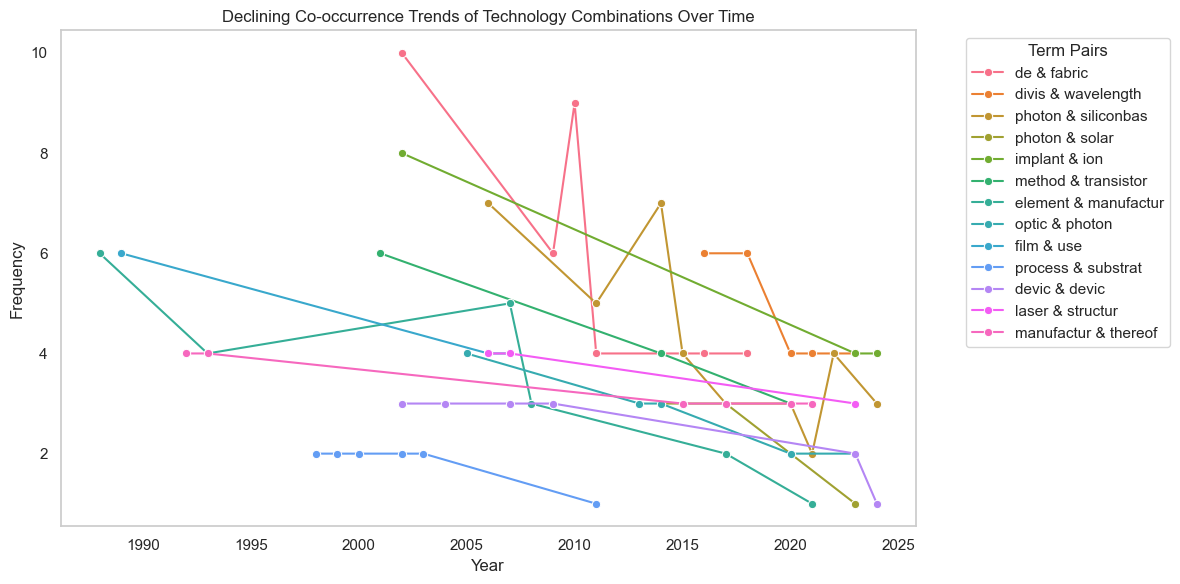

In [ ]:
# Prepare data for visualization of declining trends
decline_plot_data = []
for _, row in declining_tech.iterrows():
    for year, freq in row['frequency_history']:
        decline_plot_data.append({
            'year': year,
            'frequency': freq,
            'term_pair': f"{row['term1']} & {row['term2']}"
        })

decline_plot_df = pd.DataFrame(decline_plot_data)

# Create the line plot for declining trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=decline_plot_df, x='year', y='frequency', hue='term_pair', marker='o')
plt.title('Declining Co-occurrence Trends of Technology Combinations Over Time')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Term Pairs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

word trend for scientific papers

In [ ]:
df_papers = df_papers.dropna(subset=['Title'])
df_papers = df_papers.dropna(subset=['year'])

df_papers_copy = df_papers.copy()
df_papers_copy['Title'] = df_papers_copy['Title'].fillna('')
df_papers_copy['year'] = df_papers_copy['year'].astype(int)


In [ ]:
import re
from collections import Counter
from nltk.corpus import stopwords

# make sure you’ve run: nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def build_cooccurrence(text: str, window_size: int = 5, min_token_len: int = 3):
    """
    Build co-occurrence pairs from cleaned tokens.
    """
    # 1) Lowercase & remove non-word characters
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text.lower())
    # 2) Tokenize
    tokens = text.split()
    # 3) Filter out stopwords & short tokens & purely numeric tokens
    tokens = [
        t for t in tokens
        if len(t) >= min_token_len
        and t not in STOPWORDS
        and not t.isdigit()
    ]
    # 4) Build pairs within window
    pairs = Counter()
    for i, t in enumerate(tokens):
        for j in range(i+1, min(i + window_size, len(tokens))):
            pair = tuple(sorted((t, tokens[j])))
            pairs[pair] += 1
    return pairs




In [ ]:
import re
import pandas as pd
from collections import defaultdict, Counter
from scipy.stats import linregress



def track_cooccurrence_trends(df: pd.DataFrame,
                             time_col: str = 'Year',
                             text_col: str = 'Title',
                             window_size: int = 5,
                             min_count: int = 5) -> pd.DataFrame:
    """
    Track co-occurrence trends over time for df_papers.

    Args:
        df: DataFrame (df_papers)
        time_col: 'Year' (must be numeric/int)
        text_col: 'Title' (must be str)
        window_size: window for cooc
        min_count: total min occurrences

    Returns:
        DataFrame with: term1, term2, slope, p_value, total_count, first_year, last_year, frequency_history
    """
    # 0. Drop any missing time or text
    df_clean = df.dropna(subset=[time_col, text_col]).copy()

    # 1. Coerce Year to int (if it's datetime, extract .dt.year first)
    if pd.api.types.is_datetime64_any_dtype(df_clean[time_col]):
        df_clean[time_col] = df_clean[time_col].dt.year
    df_clean[time_col] = df_clean[time_col].astype(int)

    # 2. Group abstracts by year
    time_groups = df_clean.groupby(time_col)[text_col].agg(list)

    # 3. Count cooc by year
    temporal_counts = defaultdict(lambda: defaultdict(int))
    for year, docs in time_groups.items():
        year_counter = defaultdict(int)
        for doc in docs:
            for pair, cnt in build_cooccurrence(doc, window_size).items():
                year_counter[pair] += cnt
        for pair, cnt in year_counter.items():
            temporal_counts[pair][year] = cnt

    # 4. Build DataFrame of yearly frequencies
    cooc_df = pd.DataFrame.from_dict(temporal_counts, orient='index').fillna(0)

    # 5. Compute trends
    trend_rows = []
    for pair, row in cooc_df.iterrows():
        years = row[row > 0].index.astype(int)
        freqs = row[row > 0].values
        if len(years) < 3 or freqs.sum() < min_count:
            continue
        slope, _, _, pval, _ = linregress(years, freqs)
        trend_rows.append({
            'term1': pair[0],
            'term2': pair[1],
            'slope': slope,
            'p_value': pval,
            'total_count': int(freqs.sum()),
            'first_year': int(years.min()),
            'last_year': int(years.max()),
            'frequency_history': list(zip(years.tolist(), freqs.tolist()))
        })

    return pd.DataFrame(trend_rows)

# === Example usage on df_papers ===

cooc_trends = track_cooccurrence_trends(
    df_papers,
    time_col='Year',
    text_col='Title',
    window_size=5,
    min_count=10
)

emerging = (
    cooc_trends
    .query("slope > 0 and p_value < 0.05")
    .sort_values('slope', ascending=False)
    .head(5)
)

print(emerging[['term1','term2','slope','total_count','first_year','last_year']])


      term1      term2     slope  total_count  first_year  last_year
5   crystal   photonic  0.175889           90        2002       2024
13  crystal  structure  0.031250           15        1980       2010


In [ ]:
import matplotlib.pyplot as plt

# --- 1) Top Emerging Combinations ---

# Select top 5 emerging pairs
top_emerging = emerging.head(5)

# Rewind and build a flat DataFrame for plotting
em_plot_rows = []
for _, row in top_emerging.iterrows():
    label = f"{row['term1']} & {row['term2']}"
    for year, freq in row['frequency_history']:
        em_plot_rows.append((year, freq, label))

# Turn into a DataFrame
em_plot_df = pd.DataFrame(em_plot_rows, columns=['year','frequency','term_pair'])

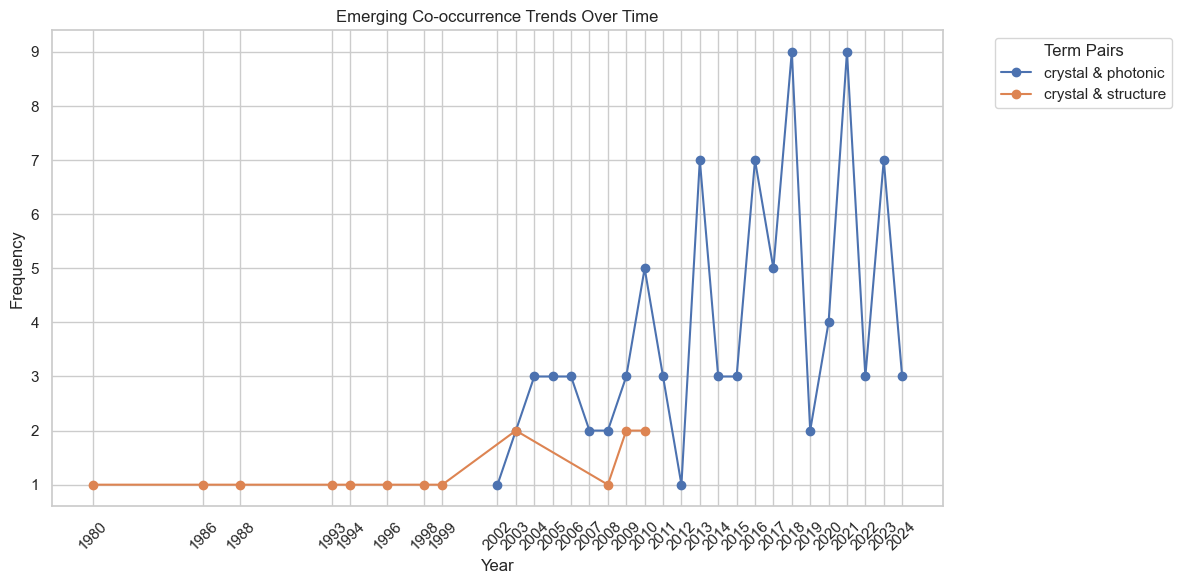

In [ ]:
import matplotlib.pyplot as plt

def plot_trends(trend_df, title, top_n=5):
    # take top_n by slope
    if 'slope' in trend_df:
        # decide sign automatically from title
        ascending = 'Declining' in title
        top = trend_df.sort_values('slope', ascending=ascending).head(top_n)
    else:
        top = trend_df.head(top_n)

    # build long DataFrame
    rows = []
    for _, row in top.iterrows():
        label = f"{row['term1']} & {row['term2']}"
        for yr, freq in row['frequency_history']:
            rows.append((yr, freq, label))
    df_plot = pd.DataFrame(rows, columns=['year','frequency','term_pair'])

    # ensure years are sorted
    years = sorted(df_plot['year'].unique())

    # plot
    fig, ax = plt.subplots(figsize=(12,6))
    for label, grp in df_plot.groupby('term_pair'):
        grp = grp.sort_values('year')
        ax.plot(grp['year'], grp['frequency'], marker='o', label=label)

    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation=45)
    ax.set_xlabel('Year')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend(title='Term Pairs', bbox_to_anchor=(1.05,1), loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Usage:
plot_trends(emerging, 'Emerging Co-occurrence Trends Over Time', top_n=5)



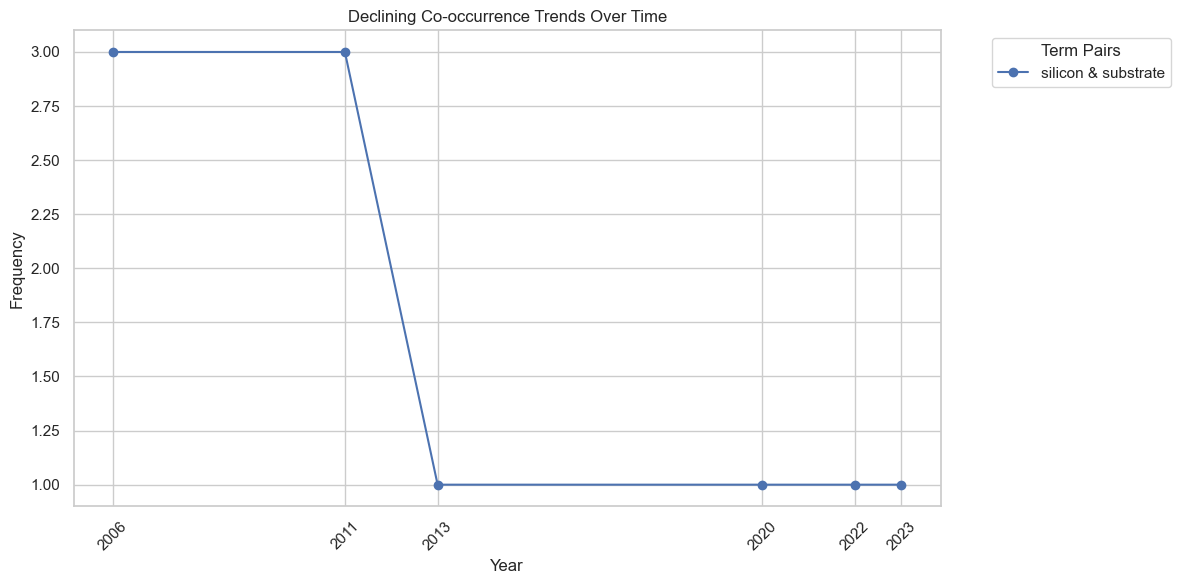

In [ ]:

# --- 2) Declining Combinations ---

# Filter and take top 5 most‐negative‐slope pairs
declining = (
    cooc_trends
    .query("slope < 0 and p_value < 0.05")
    .sort_values('slope')
    .head(5)
)

# Build plot DataFrame
dec_plot_rows = []
for _, row in declining.iterrows():
    label = f"{row['term1']} & {row['term2']}"
    for year, freq in row['frequency_history']:
        dec_plot_rows.append((year, freq, label))

dec_plot_df = pd.DataFrame(dec_plot_rows, columns=['year','frequency','term_pair'])

# Plot
plot_trends(declining, 'Declining Co-occurrence Trends Over Time', top_n=5)


In [ ]:
# import time
# import random
# import undetected_chromedriver as uc
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC
# from selenium.common.exceptions import TimeoutException
# from bs4 import BeautifulSoup
# import pandas as pd

# class PatentsSearch:
#     def __init__(self, headless=True):
#         """Initialize the scraper with enhanced compatibility options."""
        
#         options = uc.ChromeOptions()
        
        
#         if headless:
#             options.add_argument('--headless')
        
        
#         options.add_argument('--no-sandbox')
#         options.add_argument('--disable-dev-shm-usage')
#         options.add_argument('--disable-blink-features=AutomationControlled')
#         options.add_argument('--disable-extensions')
        
#         try:
            
#             self.driver = uc.Chrome(
#                 options=options, 
#                 use_subprocess=True,  
#                 version_main=None,    
#                 suppress_welcome=True,
#                 debug=False
#             )
            
            
#             self.driver.set_page_load_timeout(30)
#             self.driver.set_window_size(1920, 1080)
        
#         except Exception as e:
#             print(f"Failed to initialize ChromeDriver: {e}")
#             print("Trying alternative initialization method...")
            
#             # Alternative initialization method
#             self.driver = uc.Chrome(
#                 options=options,
#                 driver_executable_path=None  
#             )

#     def add_random_delay(self, min_seconds=1, max_seconds=3):
#         """Add a random delay to mimic human behavior."""
#         time.sleep(random.uniform(min_seconds, max_seconds))

#     def get_page_html(self, url):
#         """Navigate to the given URL and return the page HTML."""
#         try:
#             print(f"Navigating to: {url}")
#             self.driver.get(url)

            
#             WebDriverWait(self.driver, 20).until(
#                 EC.presence_of_element_located((By.TAG_NAME, "body"))
#             )

            
#             self.add_random_delay(3, 5)

            
#             return self.driver.page_source

#         except TimeoutException:
#             print("Timed out waiting for the page to load.")
#             return None
#         except Exception as e:
#             print(f"An error occurred: {e}")
#             return None

#     def parse_html(self, html):
#         """Parse the HTML and extract all span elements inside the 'Published as' content."""
#         soup = BeautifulSoup(html, 'html.parser')
        
#         # Look for the element containing "Publié en tant que" or "Published as"
#         published_as_element = soup.find(lambda tag: tag.name == "h5" and ("Publié en tant que" in tag.text or "Published as" in tag.text))
        
#         if published_as_element:
#             # Get the next sibling span that contains the relevant content
#             content_element = published_as_element.find_next_sibling("span")
#             if content_element:
#                 # Extract all span elements within the content
#                 spans = content_element.find_all('span')
#                 return [span.get_text(strip=True) for span in spans]
#         return []

#     def close(self):
#         """Close the browser when done."""
#         if self.driver:
#             self.driver.quit()



# if __name__ == '__main__':
    
#     scraper = PatentsSearch(headless=False)  # Set headless to False to see the browser in action

    
  
    
#     df['family_members'] = None

#     try:
#         for index, row in df.iterrows():
            
#             url = f"https://worldwide.espacenet.com/patent/search/family/{row['Family number']}/publication/{row['first publication number']}?q=hydrogen%20battery"

            
#             html = scraper.get_page_html(url)
#             if html:
#                 print(f"Page HTML retrieved successfully for {row['first publication number']}.")
                
#                 family_members = scraper.parse_html(html)
#                 df.at[index, 'family_members'] = family_members  
#             else:
#                 print(f"Failed to retrieve the page HTML for {row['first publication number']}.")

#     finally:
        
#         scraper.close()
#         print("Scraper closed.")

    
#     df.head()

In [ ]:
#df[['Family number','first publication number','family_members']].iloc[4]

In [ ]:
df[['first applicant', 'second applicant']] = df['Applicants'].str.split('\n' , n=1 , expand=True)

In [ ]:
df[['first applicant', 'second applicant']] 

first applicant second applicant
0       MEARS TECHNOLOGIES INC [US]             None
1      NIPPON TELEGRAPH & TELEPHONE             None
2    ZHEJIANG FORTUNE ENERGY CO LTD             None
3                    SHOWA DENKO KK             None
4       UNIV SHANGHAI JIAOTONG [CN]             None
..                              ...              ...
491                           LI YE             None
492       UNIV CENTRAL FLORIDA [US]             None
493     SAMSUNG CORNING CO LTD [KR]             None
494                     ROHM CO LTD             None
495    OKI ELECTRIC IND CO LTD [JP]             None

[496 rows x 2 columns]

**applicant type classification**


In [ ]:
import pandas as pd

def classify_applicant(applicant, inventors):
    if pd.isna(applicant):
        return "Unknown"
    applicant_lower = applicant.lower()
    
    # Corporations/Companies
    if any(keyword in applicant_lower for keyword in ["corp", "inc", "ltd", "co.", "llc", "ag", "gmbh", "co", "holdings", "ventures"]):
        if ("inc" or "corp" or "holdings" or "ventures")  in applicant_lower or "incorporated" in applicant_lower:
            return "Company - Incorporated/Corporation"
        elif ("ltd" or "llc" or "gmbh" or "kk" or "bv") in applicant_lower or "limited" in applicant_lower:
            return "Company - Limited"
        elif any(keyword in applicant_lower for keyword in ["s.a.", "sociedad anónima", "société anonyme"]):
            return "Company - Anonymous (S.A.)"
        else:
            return "Company - General"
    
    # Automotive manufacturers
    if any(keyword in applicant_lower for keyword in ["automobile", "motor", "vehicle", "auto" , "mobility","motors"]):
        return "Automotive Manufacturer"
    
    # Energy companies
    if any(keyword in applicant_lower for keyword in ["power", "energy", "fuel cell", "hydrogen"]):
        return "Energy Company"
    
    # Technology companies
    if any(keyword in applicant_lower for keyword in ["tech", "technology", "creative", "innovation" , "engineering" , "systems" , "digital" , "solutions"]):
        return "Technology Company"
    
    # Material Science/Nanotechnology companies
    if any(keyword in applicant_lower for keyword in ["nano", "material"]):
        return "Material Science/Nanotechnology Company"
    
    # Environmental protection companies
    if any(keyword in applicant_lower for keyword in ["environmental protection", "green air"]):
        return "Environmental Protection Company"
    
    # Universities/Research Institutions
    if any(keyword in applicant_lower for keyword in ["univ", "university", "college", "polytechnic", "institute", "school", "academia", "laboratory", "research"]):
        return "University/Research Institution"
    
    # Technical Universities
    if any(keyword in applicant_lower for keyword in ["teknik", "technical", "polytechnic"]):
        return "Technical University"
    
    # Research Laboratories
    if any(keyword in applicant_lower for keyword in ["laboratory", "institute"]):
        return "Research Laboratory"
    
    # Government/Public Institutions
    if any(keyword in applicant_lower for keyword in ["national", "government", "ministry", "agency"]):
        return "Government/Public Institution"
    
    # Individual Inventors 
    if applicant in inventors.values:
        return "Individual Inventor"
    if "[" in applicant and "]" in applicant:
        return "Individual Inventor"
    
    return "Individual Inventor"




In [ ]:
df['first applicant type'] = df.apply(lambda row: classify_applicant(row['first applicant'], df['Inventors']), axis=1)
df['second applicant type'] = df.apply(lambda row: classify_applicant(row['second applicant'], df['Inventors']), axis=1)


In [ ]:

first_applicant_type_counts = df['first applicant type'].value_counts()
first_applicant_type_counts

first applicant type
Company - General                          155
Individual Inventor                        148
Company - Limited                           58
University/Research Institution             55
Company - Incorporated/Corporation          33
Technology Company                          29
Material Science/Nanotechnology Company     16
Energy Company                               1
Automotive Manufacturer                      1
Name: count, dtype: int64

In [ ]:
second_applicant_type_counts = df['second applicant type'].value_counts()
second_applicant_type_counts

second applicant type
Unknown                               385
Individual Inventor                    37
Company - General                      30
Company - Incorporated/Corporation     27
Company - Limited                       7
University/Research Institution         7
Technology Company                      3
Name: count, dtype: int64

In [ ]:
df[['first applicant','second applicant']]

first applicant second applicant
0       MEARS TECHNOLOGIES INC [US]             None
1      NIPPON TELEGRAPH & TELEPHONE             None
2    ZHEJIANG FORTUNE ENERGY CO LTD             None
3                    SHOWA DENKO KK             None
4       UNIV SHANGHAI JIAOTONG [CN]             None
..                              ...              ...
491                           LI YE             None
492       UNIV CENTRAL FLORIDA [US]             None
493     SAMSUNG CORNING CO LTD [KR]             None
494                     ROHM CO LTD             None
495    OKI ELECTRIC IND CO LTD [JP]             None

[496 rows x 2 columns]

In [ ]:
df[['first applicant type','second applicant type']] 

first applicant type second applicant type
0    Company - Incorporated/Corporation               Unknown
1                   Individual Inventor               Unknown
2                     Company - Limited               Unknown
3                   Individual Inventor               Unknown
4       University/Research Institution               Unknown
..                                  ...                   ...
491                 Individual Inventor               Unknown
492     University/Research Institution               Unknown
493                   Company - Limited               Unknown
494                   Company - Limited               Unknown
495                   Company - Limited               Unknown

[496 rows x 2 columns]

In [ ]:
df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields',
       'first applicant', 'second applicant', 'first applicant type',
       'second applicant type'],
      dtype='object')

**applicant type percentage**

In [ ]:

applicants = []


for index, row in df.iterrows():
    
    first_applicant = row['first applicant']
    second_applicant = row['second applicant']
    
    
    if pd.notna(first_applicant):
        applicants.append(first_applicant)
    
    
    if pd.notna(second_applicant):
        applicants.append(second_applicant)


applicants_df = pd.DataFrame(applicants, columns=['Applicants'])


applicants_df


Applicants
0       MEARS TECHNOLOGIES INC [US]
1      NIPPON TELEGRAPH & TELEPHONE
2    ZHEJIANG FORTUNE ENERGY CO LTD
3                    SHOWA DENKO KK
4       UNIV SHANGHAI JIAOTONG [CN]
..                              ...
602                           LI YE
603       UNIV CENTRAL FLORIDA [US]
604     SAMSUNG CORNING CO LTD [KR]
605                     ROHM CO LTD
606    OKI ELECTRIC IND CO LTD [JP]

[607 rows x 1 columns]

In [ ]:
applicants_df['Applicant Type'] = applicants_df.apply(lambda row: classify_applicant(row['Applicants'], df['Inventors']), axis=1)

In [ ]:
applicants_df

Applicants                      Applicant Type
0       MEARS TECHNOLOGIES INC [US]  Company - Incorporated/Corporation
1      NIPPON TELEGRAPH & TELEPHONE                 Individual Inventor
2    ZHEJIANG FORTUNE ENERGY CO LTD                   Company - Limited
3                    SHOWA DENKO KK                 Individual Inventor
4       UNIV SHANGHAI JIAOTONG [CN]     University/Research Institution
..                              ...                                 ...
602                           LI YE                 Individual Inventor
603       UNIV CENTRAL FLORIDA [US]     University/Research Institution
604     SAMSUNG CORNING CO LTD [KR]                   Company - Limited
605                     ROHM CO LTD                   Company - Limited
606    OKI ELECTRIC IND CO LTD [JP]                   Company - Limited

[607 rows x 2 columns]

In [ ]:
import pandas as pd


applicant_type_counts = applicants_df['Applicant Type'].value_counts()
applicant_type_percentages = (applicant_type_counts / applicant_type_counts.sum()) * 100


applicant_type_df = applicant_type_percentages.reset_index()
applicant_type_df.columns = ['Applicant Type', 'Percentage']

In [ ]:
applicant_type_df = applicant_type_df.sort_values(by='Percentage', ascending=False)


In [ ]:
applicant_type_df.head()

Applicant Type  Percentage
0                 Individual Inventor   30.477759
1                   Company - General   30.477759
2                   Company - Limited   10.708402
3     University/Research Institution   10.214168
4  Company - Incorporated/Corporation    9.884679

Individual contribution to patent filing : 
  - USPTO : 9% but this share has decreased by 13% over the past five years 
  - CNIPA : 8% down from 20% in the past 5 years
  - EPO : 4% 

In [ ]:
import plotly.express as px
import matplotlib.colors as mcolors

# Convert matplotlib tab20 colors to hex format
tab20_colors = [mcolors.rgb2hex(c) for c in plt.cm.tab20.colors]

fig = px.pie(
    applicant_type_df,
    values='Percentage',
    names='Applicant Type',
    title='<b>Applicant Type Distribution</b>',
    color_discrete_sequence=tab20_colors,
    hole=0,
    labels={'Percentage': 'Percentage'},
    hover_data=['Percentage']
)

# Update traces for styling
fig.update_traces(
    texttemplate='%{label}<br>%{percent:.1%}',
    textposition='inside',
    rotation=140,
    marker=dict(line=dict(color='black', width=0.5)),
    hovertemplate='<b>%{label}</b><br>Percentage: %{value:.1f}%'
)

# Update layout for appearance
fig.update_layout(
    title_x=0.5,
    title_font_size=16,
    width=800,
    height=800,
    margin=dict(t=60, b=20, l=20, r=20),
    showlegend=False,
    uniformtext_minsize=12,
    uniformtext_mode='hide'
)

fig.show()

**top 10% of actors**

In [ ]:

applicant_counts = applicants_df['Applicants'].value_counts()


top_10_applicants_df = applicant_counts.head(10).reset_index()
top_10_applicants_df.columns = ['Applicant', 'Patent Count'] 


#total_patents = top_10_applicants_df['Patent Count'].sum()
total_patents = applicants_df['Applicants'].count()

top_10_applicants_df['Contribution (%)'] = (top_10_applicants_df['Patent Count'] / total_patents) * 100


print("Top 10 Applicants by Number of Patents Filed with Contribution:")
top_10_applicants_df

Top 10 Applicants by Number of Patents Filed with Contribution:


Applicant  Patent Count  Contribution (%)
0                    OUYANG ZHENGBIAO [CN]            12          1.976936
1           MEMC ELECTRONIC MATERIALS [US]            11          1.812191
2            UNIV NANJING POSTS & TELECOMM            11          1.812191
3                      TOSHIBA CERAMICS CO             9          1.482702
4                      ARKUN ERDEM [US] \r             9          1.482702
5                     SHINETSU HANDOTAI KK             8          1.317957
6                     DARGIS RYTIS [US] \r             7          1.153213
7                             UNIV QINGDAO             7          1.153213
8  UNIV NANJING POSTS & TELECOMMUNICATIONS             6          0.988468
9                                 IBM [US]             6          0.988468

In [ ]:

applicant_counts = applicants_df['Applicants'].value_counts()


top_10_applicants_df = applicant_counts.head(10).reset_index()
top_10_applicants_df.columns = ['Applicant', 'Patent Count']  


total_patents = applicants_df['Applicants'].count()


total_top_10_patents = top_10_applicants_df['Patent Count'].sum()


percentage_top_10_contribution = (total_top_10_patents / total_patents) * 100


print(f"Percentage Contribution of Top 10 Applicants: {percentage_top_10_contribution:.2f}%")
innovation_cycle = ""
if percentage_top_10_contribution >=50:
    innovation_cycle = "the innovation cycle is Ending"
elif 30 <= percentage_top_10_contribution < 50:
     innovation_cycle = "the innovation cycle is Slowing"
elif 20 <= percentage_top_10_contribution < 30:
     innovation_cycle = "the innovation cycle is Ongoing"
elif 10 <= percentage_top_10_contribution < 20:
     innovation_cycle = "the innovation cycle is Beginning"
elif percentage_top_10_contribution < 10:
     innovation_cycle = "the innovation cycle is Emmerging"

print(innovation_cycle)

Percentage Contribution of Top 10 Applicants: 14.17%
the innovation cycle is Beginning


In [ ]:
# Co-Applicant Rate
#num_patents_with_multiple_applicants = df['Applicants'].str.contains('\n').sum()
num_patents_with_multiple_applicants = (df['second applicant'].notna()).sum()
total_patents = len(df)
co_applicant_rate = (num_patents_with_multiple_applicants / total_patents) * 100
print(f"Co-Applicant Rate: {co_applicant_rate:.2f}%")

Co-Applicant Rate: 22.38%


**growth rate**

In [ ]:



patent_counts = df.groupby('first filing year').size().reset_index(name='Patent Count')


patent_counts['Cumulative Count'] = patent_counts['Patent Count'].cumsum()


X=patent_counts['Patent Count']
T=patent_counts['Cumulative Count']
patent_counts['GR'] = ((X- X.shift(1)) / ((T+ T.shift(1))/2)).fillna(0)


patent_counts_sorted = patent_counts.sort_values('first filing year', ascending=False)


patent_counts_sorted[['first filing year', 'Patent Count', 'GR']].head(10)


first filing year  Patent Count        GR
47               2025             5 -0.020263
46               2024            15  0.002068
45               2023            14 -0.008529
44               2022            18  0.008830
43               2021            14  0.006865
42               2020            11 -0.007067
41               2019            14 -0.012136
40               2018            19 -0.012642
39               2017            24  0.026738
38               2016            14 -0.030986

In [ ]:
# Filter the DataFrame for the years between 2018 and 2023
df_2018_2023 = patent_counts[(patent_counts['first filing year'] >= 2018) & (patent_counts['first filing year'] <= 2023)]

# Sum the annual growth rates (GR) for the period
growth_rate_2018_2023 = df_2018_2023['GR'].sum()*100

# Print the result
print(f"Growth Rate between 2018 and 2023 (sum of annual GR): {growth_rate_2018_2023:.2f}%")

Growth Rate between 2018 and 2023 (sum of annual GR): -2.47%


In [ ]:
from datetime import date
current_year = date.today().year
start_year = current_year - 2
end_year = start_year - 5


print('current: ' , current_year , 'start : ' , start_year , 'end : ' , end_year)

current:  2025 start :  2023 end :  2018


In [ ]:


df_2018_2023 = patent_counts[(patent_counts['first filing year'] >= end_year) & (patent_counts['first filing year'] <= start_year)]


    

# Sum the annual growth rates (GR) for the period
GR = df_2018_2023['GR'].sum()*100


print(f"\nGrowth Rate from {end_year} to {start_year}: {GR:.2f}%")


if GR >=50:
    print ("the technology is Booming")
elif 20 <= GR < 50:
    print ("the technology is Trending")
elif 10 <= GR < 20:
    print ("the technology is Quite_Trending")
elif 0 <= GR < 10:
    print ("the technology is Steady")
elif GR < 0:
    print ("the technology is Declining")


Growth Rate from 2018 to 2023: -2.47%
the technology is Declining


**market cost**


In [ ]:
cost = pd.read_csv('corrected-patent-cost-data.csv')

In [ ]:
cost

Country  Years 0.0-1.5  Years 2.0-4.5  Years 5.0-9.5  Years 10.0-14.5  \
0       US          10500           6000          11500             5000   
1       WO           5400           4900           4100             1500   
2       EP           7600           8900          12000             9000   
3       KR           4000           5000           7500             8400   
4       JP           4500           5500           6000             6500   
5       ID           1500           4500           4500             5500   
6       VN           1500           4500           3000             4500   
7       BR           1500           4500           3000             5500   
8       CN           6000           5800           5200             4000   
9       RU           1500           4500           2000             4500   
10      NO           1500           4500           2000             4500   
11      TH           1500           4500           2000             4500   
12      TR           1500           4500           2000             4500   
13      TW           1500           4500           3500             4500   
14      DE           5000           7000           3000             5000   
15      AT           2000           4000           2000             4000   
16      CZ           1500           3500           2000             3500   
17      AR           1500           3500           2000             4500   
18      HU           1500           3500           2500             3500   
19      NL           2000           4000           2500             3500   
20      FI           1500           3500           1500             2500   
21      MX           1500           3500           2500             2500   
22      MA           1500           3500           2500             2500   
23      SK           1500           3500           1500             2500   
24      SA           1500           3500           2500             2500   
25      PL           1500           3500           2500             2500   
26      HK           1500           3500           1500             2500   
27      IT           4500           4500           2500             3000   
28      DK           1500           3500           1500             2500   
29      PH           1500           3500           2500             2500   
30      PE           1500           3500           1500             2500   
31      SE           1500           3500           2500             1500   
32      CO           1500           2500           3500             1500   
33      MY           2500           1500           2500             2500   
34      ES           2500           3000           2000             2500   
35      PT           1500           2500           1500             2500   
36      FR           4600           3800           3000             3500   
37      AU           1500           2500           1500             2500   
38      SG           1500           2500           1500             2500   
39      EG           1500           2500           1500             1500   
40      GR           1500           2500           1500             1500   
41      IL           1500           2500           1500             1500   
42      CA           3200           2700           3500             2300   
43      VE           1500           2500           1500             1500   
44      PK           1500           2500           2500             3500   
45      IN           1500           2500           2500             3500   
46      GB           3000           3500           2000             2000   
47      IE           1500           2000           1500             1500   
48      CH           1500           2000           1500             1500   
49      BE           1500           2000           1500             1500   
50      CL           2500           1500           1500             1000   
51      BD           1500           1500           

In [ ]:
import pandas as pd


reference_countries = ['FR', 'EP', 'US', 'CA', 'CN', 'IN', 'KR']


economic_groups = {
    # China-like economies 
    'BR': 'CN', 'RU': 'CN', 'VN': 'CN', 'ZA': 'CN', 'MX': 'CN', 
    'ID': 'CN', 'TR': 'CN', 'TH': 'CN', 'SA': 'CN', 'AR': 'CN',
    'CL': 'CN', 'CO': 'CN', 'PE': 'CN', 'PH': 'CN', 'EG': 'CN',
    'PK': 'CN', 'BD': 'CN', 'MA': 'CN', 'VE': 'CN',
    
    # France-like economies 
    'DE': 'FR', 'GB': 'FR', 'IT': 'FR', 'ES': 'FR', 'NL': 'FR',
    'SE': 'FR', 'CH': 'FR', 'BE': 'FR', 'AT': 'FR', 'DK': 'FR',
    'FI': 'FR', 'NO': 'FR', 'PT': 'FR', 'IE': 'FR', 'GR': 'FR',
    'CZ': 'FR', 'HU': 'FR', 'SK': 'FR', 'PL': 'FR',
    
    # Canada-like economies 
    'AU': 'CA', 'JP': 'KR', 'SG': 'KR', 'TW': 'KR', 'IL': 'KR',
    'NZ': 'CA', 'MY': 'KR', 'HK': 'KR',
    
}


for idx, row in cost.iterrows():
    country = row['Country']
    if country not in reference_countries:
        # Find the mapped reference country
        reference = economic_groups.get(country, 'CN')  
        # Copy costs from the reference country
        ref_row = cost[cost['Country'] == reference].iloc[0]
        cost.loc[idx, 'Years 0.0-1.5':'Total Cost (US$)'] = ref_row['Years 0.0-1.5':'Total Cost (US$)']
        

In [ ]:
import pandas as pd
from datetime import datetime

current_year = datetime.now().year


df['Patent Age'] = current_year - df['earliest priority year']


df['Patent Age'] = df['Patent Age'].apply(lambda x: max(0, x) if pd.notnull(x) else x)

In [ ]:
df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields',
       'first applicant', 'second applicant', 'first applicant type',
       'second applicant type', 'Patent Age'],
      dtype='object')

In [ ]:
def assign_cost(row, cost_df):
    country = row['first publication country']
    age = row['Patent Age']
    
    cost_row = cost_df[cost_df['Country'] == country]
    
    if not cost_row.empty:
        
        cost_columns = [
            'Years 0.0-1.5',
            'Years 2.0-4.5', 
            'Years 5.0-9.5',
            'Years 10.0-14.5',
            'Years 15.0-20.0'
        ]
        
        if age > 20:
            return cost_row['Total Cost (US$)'].values[0]
        elif age <= 1.5:
            return cost_row[cost_columns[0]].values[0]
        else:
            # Calculate cumulative sum up to current age bracket
            bracket_index = next(i for i, limit in enumerate([1.5, 4.5, 9.5, 14.5, 20.0]) if age <= limit)
            return cost_row[cost_columns[:bracket_index+1]].sum(axis=1).values[0]
    else:
        return None


In [ ]:
df['patent cost'] = df.apply(lambda row: assign_cost(row, cost), axis=1)

# 4. Handle remaining cases
df['patent cost'] = df['patent cost'].fillna(0).astype(int)

In [ ]:
zero_cost_count = (df['patent cost'] == 0).sum()
print(f"Number of patents with assigned cost 0: {zero_cost_count}")


Number of patents with assigned cost 0: 0


In [ ]:
df.head(2)

No                                              Title  \
0   1  DISPOSITIFS SPINTRONIQUES CONTENANT DES DOPANT...   
1   2                             SILICON SINGLE CRYSTAL   

                                           Inventors  \
0  DUKOVSKI ILIJA [US] \r\nMEARS ROBERT J [US] \r...   
1                                       ADACHI SADAO   

                     Applicants Publication number Earliest priority  \
0   MEARS TECHNOLOGIES INC [US]        CA2646325A1        2006-03-17   
1  NIPPON TELEGRAPH & TELEPHONE       JPS58140112A        1982-02-16   

                                                 IPC  \
0                  [H01L29/15, H01L29/66, H10N50/10]   
1  [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...   

                                                 CPC Publication date  \
0  [B82Y10/00 (EP), B82Y25/00 (EP), B82Y40/00 (EP...       2007-09-27   
1              [H01L21/0242 (EP), H01L21/02532 (EP)]       1983-08-19   

  Earliest publication  ...  earliest priority year applicant country  \
0           2007-09-27  ...                    2006                US   
1           1983-08-19  ...                    1982               NaN   

         IPC_Meaning                            fields  \
0  ELECTRIC ELEMENTS  [Engineering, Materials Science]   
1  ELECTRIC ELEMENTS  [Engineering, Materials Science]   

                first applicant second applicant  \
0   MEARS TECHNOLOGIES INC [US]             None   
1  NIPPON TELEGRAPH & TELEPHONE             None   

                 first applicant type  second applicant type  Patent Age  \
0  Company - Incorporated/Corporation                Unknown          19   
1                 Individual Inventor                Unknown          43   

  patent cost  
0       13700  
1       35400  

[2 rows x 28 columns]

df = df.drop('Assigned Cost' , axis= 1)

In [ ]:
df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields',
       'first applicant', 'second applicant', 'first applicant type',
       'second applicant type', 'Patent Age', 'patent cost'],
      dtype='object')

**originality rate** (IPC&Originality_Rate notebook)

In [ ]:
OR_df = df.head(50)
#OR_df.to_csv('OR_df.csv' , index=False)

In [ ]:
result_or_df=df.head(50)

change this to use apis

In [ ]:
import os
import time
import requests
import pandas as pd
import xml.etree.ElementTree as ET
from dotenv import load_dotenv

# Global token cache
TOKEN = None
TOKEN_EXPIRY = 0

# Constants for API endpoints
TOKEN_URL = "https://ops.epo.org/3.2/auth/accesstoken"
BASE_URL = "https://ops.epo.org/3.2/rest-services"

# Load credentials from .env file
load_dotenv()
CONSUMER_KEY = os.getenv("CONSUMER_KEY").strip()
CONSUMER_SECRET = os.getenv("CONSUMER_SECRET").strip()

def get_access_token() -> str:
    """Get or refresh the OAuth access token."""
    global TOKEN, TOKEN_EXPIRY
    if TOKEN and time.time() < TOKEN_EXPIRY:
        return TOKEN
    data = {
        "grant_type": "client_credentials",
        "client_id": CONSUMER_KEY,
        "client_secret": CONSUMER_SECRET
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    response = requests.post(TOKEN_URL, data=data, headers=headers, timeout=15)
    response.raise_for_status()
    TOKEN = response.json()["access_token"]
    # Token expires in ~58 minutes; refresh slightly before expiry.
    TOKEN_EXPIRY = time.time() + 3500  
    return TOKEN

def get_patent_biblio(publication_number: str) -> str:
    """
    Fetch bibliographic data for a given patent number from the EPO OPS API.
    
    Args:
        publication_number (str): The publication number (e.g., "CN112508743A")
        
    Returns:
        str: The XML response text.
    """
    token = get_access_token()
    # Construct the static endpoint URL using the provided publication number
    url = f"{BASE_URL}/published-data/publication/docdb/{publication_number}/biblio"
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/xml"
    }
    response = requests.get(url, headers=headers, timeout=15)
    response.raise_for_status()
    return response.text

def retrieve_citation_publication_numbers(xml_string: str) -> list:
    """
    Parses an EPO patent XML string and retrieves citation publication numbers 
    from each citation's <document-id> element with document-id-type="docdb".
    The publication number is constructed as: country + doc-number + kind.
    
    Args:
        xml_string (str): The XML string containing patent data.
    
    Returns:
        list of str: A list of citation publication numbers.
    """
    ns = {
        'ex': "http://www.epo.org/exchange",
        'ops': "http://ops.epo.org"
    }
    
    publication_numbers = []
    root = ET.fromstring(xml_string)
    
    citations = root.findall(".//ex:bibliographic-data/ex:references-cited/ex:citation", ns)
    
    for citation in citations:
        docdb = citation.find(".//ex:document-id[@document-id-type='docdb']", ns)
        if docdb is not None:
            country = docdb.findtext("ex:country", default="", namespaces=ns)
            doc_number = docdb.findtext("ex:doc-number", default="", namespaces=ns)
            kind = docdb.findtext("ex:kind", default="", namespaces=ns)
            pub_number = f"{country}{doc_number}{kind}"
            if pub_number:
                publication_numbers.append(pub_number)
    
    return publication_numbers

def retrieve_ipc_classifications(xml_string: str) -> list:
    """
    Parses the given patent XML string and extracts the IPC classification texts
    from the <classifications-ipcr> element. For each classification text:
      - Everything after (and including) the '/' character is removed.
      - All spaces are removed from the remaining text.
      
    Args:
        xml_string (str): The XML string from the OPS API.
        
    Returns:
        list of str: A list of cleaned IPC classification texts.
    """
    ns = {
        'ex': "http://www.epo.org/exchange",
        'ops': "http://ops.epo.org"
    }
    
    ipcs = []
    root = ET.fromstring(xml_string)
    
    for cl in root.findall(".//ex:classifications-ipcr/ex:classification-ipcr", ns):
        text = cl.findtext("ex:text", default="", namespaces=ns)
        if text:
            # Remove everything after the first '/'
            cleaned_text = text.strip().split('/')[0].strip()
            # Remove all spaces from the cleaned text
            cleaned_text = cleaned_text.replace(" ", "")
            ipcs.append(cleaned_text)
    
    return ipcs

def get_citations_ipc_for_patent(publication_number: str) -> list:
    """
    For a given citation publication number, fetch bibliographic data and
    return its IPC classifications.
    
    Args:
        publication_number (str): A citation publication number.
        
    Returns:
        list: A list of cleaned IPC classification texts.
    """
    try:
        xml_data = get_patent_biblio(publication_number)
        ipc_classifications = retrieve_ipc_classifications(xml_data)
        return ipc_classifications
    except Exception as e:
        print(f"Error fetching IPC for {publication_number}: {e}")
        return []

def get_all_citations_ipc(citation_nums: list) -> list:
    """
    Given a list of citation publication numbers, retrieve the IPC classifications
    for each citation and aggregate them into one list.
    
    Args:
        citation_nums (list): List of citation publication numbers.
        
    Returns:
        list: Aggregated list of cleaned IPC classification texts from the citations.
    """
    ipc_results = []
    for num in citation_nums:
        ipc = get_citations_ipc_for_patent(num)
        ipc_results.extend(ipc)
    return ipc_results

# --- Example DataFrame Integration --- #


In [ ]:
if __name__ == "__main__":
    # ——— your code that loads or defines result_or_df ———
    # e.g. result_or_df = pd.read_csv("your_input.csv")
    # and make sure it has a column named "first publication number"

    # Step 1: get citation numbers and IPC lists
    result_or_df['citation_numbers'] = (
        result_or_df['first publication number']
        .apply(lambda pub: retrieve_citation_publication_numbers(get_patent_biblio(pub)))
    )
    result_or_df['citations_ipc'] = (
        result_or_df['citation_numbers']
        .apply(get_all_citations_ipc)
    )

    # Step 2: keep only rows where we actually got at least one IPC
    valid_df = result_or_df[result_or_df['citations_ipc'].apply(lambda lst: len(lst) > 0)]

    # Step 3: check we have ≥ 30
    n_valid = len(valid_df)
    if n_valid < 30:
        raise RuntimeError(
            f"Only found {n_valid} rows with citations IPC data. "
            "You need at least 30 — please add more publication numbers."
        )

    # Step 4: pick exactly 30 of them
    # — random sample for diversity; or use .head(30) for the first 30 in order
    final_df = valid_df.sample(n=30, random_state=42).reset_index(drop=True)

    # (Optional) inspect
    print(final_df[['first publication number', 'citations_ipc']].head())

    # Step 5: save or return
    final_df.to_csv("final_30_citations_ipc.csv", index=False)
    print("Saved 30‑row result to final_30_citations_ipc.csv")


KeyboardInterrupt: 

In [ ]:
len(result_or_df)

50

In [ ]:
result_or_df['IPC'].head(2)

0                    [H01L29/15, H01L29/66, H10N50/10]
1    [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...
Name: IPC, dtype: object

In [ ]:
citations_IPC_df= result_or_df[['first publication number','IPC','citations_ipc']]
citations_IPC_df['IPC count']= citations_IPC_df['IPC'].apply(len)
citations_IPC_df['citations IPC count']= citations_IPC_df['citations_ipc'].apply(len)

C:\Users\tasni\AppData\Local\Temp\ipykernel_4736\570908344.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tasni\AppData\Local\Temp\ipykernel_4736\570908344.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#remove rows in whitch IPC count > citations IPC count
citations_IPC_df = citations_IPC_df[citations_IPC_df['IPC count'] <= citations_IPC_df['citations IPC count']]

In [ ]:

citations_IPC_df['%citaions'] = citations_IPC_df['IPC count'] / citations_IPC_df['citations IPC count']

In [ ]:
citations_IPC_df

first publication number  \
2              CN105762223A   
3             JP2011111372A   
6             JP2021195301A   
9              US10718065B2   
10              US6521950B1   
11            JP2004228139A   
13             CN104865715A   
14           WO2025011210A1   
15             US10662547B2   
16               US5818100A   
21             CN112747820A   
22             CN112747821A   
26               US6133120A   
27             CN114858324A   
28               US5902135A   
30            JP2011073900A   
32             CN104593865A   
33               US5804495A   
34             CN104152992A   
37             CN103885267A   
38             US10048142B2   
39            JP2004093263A   
40             US10934635B2   
41           US2012280276A1   
42             CN118794970A   
43           WO2025028388A1   
44             CN104698606A   
45               US5023066A   
46             CN107290826A   
47              US6954235B1   
49              EP0521473A1   

                                                  IPC  \
2                              [C30B33/10, H01L31/18]   
3                                         [C30B29/36]   
6                  [C01B32/956, C30B23/06, C30B29/36]   
9   [C30B29/06, C30B29/36, H01L21/02, C30B19/04, C...   
10  [H01L27/01, H01L27/12, H01L31/0392, H01L21/77,...   
11  [H01L21/322, H01L27/12, H01L21/02, H01L21/322,...   
13                              [G02B6/122, G02F1/01]   
14                                        [C30B29/36]   
15  [C30B29/36, C30B9/10, H01L21/02, C30B19/02, C3...   
16               [H01L31/117, H01L21/331, H01L21/336]   
21                   [G01J1/42, G02B6/122, G02B6/293]   
22                   [G01J1/42, G02B6/122, G02B6/293]   
26  [C01B31/36, H01L21/20, C30B25/00, C30B25/02, H...   
27                    [G01L1/25, G01L5/00, G16C60/00]   
28  [H01L21/31, C30B31/06, C30B33/00, H01L21/22, H...   
30  [C23C14/14, C23C16/24, C30B25/20, C30B29/06, H...   
32                             [C30B15/00, C30B29/36]   
33  [H01L21/76, H01L21/02, H01L21/762, H01L21/78, ...   
34                  [C30B15/36, C30B28/10, C30B29/06]   
37                                        [G02F1/355]   
38                    [G01L1/24, G01N21/65, G01L5/00]   
39  [G01N23/04, G01N23/20, H01L21/66, G01N23/04, G...   
40       [C30B25/10, C30B29/04, C30B33/04, C30B33/02]   
41                            [H01L21/20, H01L29/165]   
42     [G01N23/203, G06F30/25, G16C60/00, G06F111/08]   
43                 [C04B35/587, H01L23/12, H01L23/13]   
44                                         [G02F1/09]   
45  [C01B33/34, B01J29/08, C01B39/20, C01B39/24, C...   
46                                        [G02B6/122]   
47  [G02F1/1343, G02F1/1343, G02F1/1362, G02F1/133...   
49                             [C30B25/02, C30B25/02]   

                                        citations_ipc  IPC count  \
2   [C11D7, H01L31, H01L31, C30B33, H01L31, B08B3,...          2   
3   [C30B29, C23C16, C30B25, C30B29, H01L21, C30B2...          1   
6   [C30B25, C30B29, H01L21, H01L21, C30B29, C30B2...          3   
9   [C30B29, C30B29, C30B19, C30B33, H01B1, C30B19...          6   
10  [H01L21, H01L21, H01L21, H01L21, H01L21, H01L2...          8   
11  [C30B29, C30B33, H01L21, H01L21, H01L21, H01L2...          5   
13                                     [G02F1, G02F1]          2   
14  [C23C16, C30B19, C30B25, C30B25, C23C16, B05D5...          1   
15  [C30B33, H01B1, C30B15, C30B17, H01L21, C30B9,...          6   
16  [H01L21, H01L21, H01L21, H01L21, H01L21, H01L2...          3   
21  [G02B6, G02B6, G02B6, H01L27, H01L31, H01L31, ...          3   
22  [H01S1, H01L33, H01S3, H01S5, H01S5, H01S3, H0...          3   
26  [H01L21, H01L21, H01L21, H01L21, H01L21, H01L2...         12   
27  [G01L1, G01L1, G01N23, G01L1, G01L1, G01N23, G...          3   
28  [G11C11, G11C16, G11C16, H01L29, H01L29, H10B6...          6   
30  [C30B29, C23C16, C30B33, H01L21, H01L21, C30B2...          6   
32  [C30B19, C30B29, C23C16, 

In [ ]:
#originality rate calculation 
citations_IPC_df['%S²'] = citations_IPC_df['%citaions']**2
mean_S_square = citations_IPC_df['%S²'].sum()
num_rows = len(citations_IPC_df)
original_rate = 1- mean_S_square/num_rows
print('num rows = ' , num_rows)
print('OR = ' ,' {:.2f}%'.format(original_rate) )

num rows =  31
OR =   0.92%


**family analysis**

family_df = pd.read_csv('family_df.csv')
family_df = family_df.drop('Unnamed: 0' , axis= 1)
family_df.columns

In [ ]:
family_df= df.copy()

In [ ]:
df['family_members']

KeyError: 'family_members'

In [ ]:
# 1. Calculate number of family members per row
family_df['family_members_count'] = family_df['family_members'].str.len()

# 2. Calculate total across all patents
total_family_members = family_df['family_members_count'].sum()

print(f"Total family members across all patents: {total_family_members}")


Total family members across all patents: 2930.0


***market strategy***

In [ ]:
import pandas as pd


market_value = df['patent cost'].sum()


df['Patent Value'] = df['patent cost']
#market rate fixed
market_rate = total_family_members / len(df)

Patent_Value=market_value/len(df)

print(f"Market Value: ${market_value:,.2f}")
print(f"Market Rate: ${market_rate:,.2f} per patent")
print(f"Mean Value of Patents: ${Patent_Value:,.2f}")



NameError: name 'total_family_members' is not defined

In [ ]:
len(family_df)

496

In [ ]:
import pandas as pd
import numpy as np
family_df_copy = family_df.copy()



In [ ]:
family_df_copy = family_df_copy.dropna(subset=['family_members'])


KeyError: ['family_members']

In [ ]:
family_df_copy = family_df_copy[family_df_copy['family_members'].apply(lambda x: len(x) > 0)]


KeyError: 'family_members'

In [ ]:
family_df_copy.head(2)

No                                              Title  \
0   1  DISPOSITIFS SPINTRONIQUES CONTENANT DES DOPANT...   
1   2                             SILICON SINGLE CRYSTAL   

                                           Inventors  \
0  DUKOVSKI ILIJA [US] \r\nMEARS ROBERT J [US] \r...   
1                                       ADACHI SADAO   

                     Applicants Publication number Earliest priority  \
0   MEARS TECHNOLOGIES INC [US]        CA2646325A1        2006-03-17   
1  NIPPON TELEGRAPH & TELEPHONE       JPS58140112A        1982-02-16   

                                                 IPC  \
0                  [H01L29/15, H01L29/66, H10N50/10]   
1  [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...   

                                                 CPC Publication date  \
0  [B82Y10/00 (EP), B82Y25/00 (EP), B82Y40/00 (EP...       2007-09-27   
1              [H01L21/0242 (EP), H01L21/02532 (EP)]       1983-08-19   

  Earliest publication  ...  earliest priority year applicant country  \
0           2007-09-27  ...                    2006                US   
1           1983-08-19  ...                    1982               NaN   

         IPC_Meaning                            fields  \
0  ELECTRIC ELEMENTS  [Engineering, Materials Science]   
1  ELECTRIC ELEMENTS  [Engineering, Materials Science]   

                first applicant second applicant  \
0   MEARS TECHNOLOGIES INC [US]             None   
1  NIPPON TELEGRAPH & TELEPHONE             None   

                 first applicant type  second applicant type  Patent Age  \
0  Company - Incorporated/Corporation                Unknown          19   
1                 Individual Inventor                Unknown          43   

  patent cost  
0       13700  
1       35400  

[2 rows x 28 columns]

In [ ]:
family_df_copy = family_df_copy[family_df_copy['family_members'] != ';']

KeyError: 'family_members'

In [ ]:
# Inspect the first few rows of the 'family_members' column
print(family_df_copy['family_members'].head())

KeyError: 'family_members'

In [ ]:
import re
import ast

def extract_country_codes(family_data):
    """
    Extract country codes from the family_members column.
    Handles both string representations of lists and actual lists.
    """
    # If the input is a string representation of a list
    if isinstance(family_data, str):
        # Check if it's an empty list string
        if family_data == '[]':
            return []
        # Use the string-based extraction function
        return extract_country_codes_from_str(family_data)
    
    # If the input is an actual list
    elif isinstance(family_data, list):
        # Use the list-based extraction function
        return extract_country_codes_from_list(family_data)
    
    # If the input is neither, return an empty list
    return []

def extract_country_codes_from_str(family_str):
    """
    Extract country codes from a string representation of a list.
    """
    if not isinstance(family_str, str) or family_str == '[]':
        return []
    
    # This pattern finds anything that looks like a patent number within quotes
    pattern = r"'([A-Z]{2}[A-Z0-9]+)'"
    matches = re.findall(pattern, family_str)
    
    # Extract the first two characters for country codes
    country_codes = [match[:2] for match in matches]
    return country_codes

def extract_country_codes_from_list(family_members):
    """
    Extract country codes from an actual list of patent numbers.
    """
    if not isinstance(family_members, list) or not family_members:
        return []
    
    # This pattern extracts the 2-letter country code from patent numbers
    country_codes = []
    for item in family_members:
        if isinstance(item, str):  # Ensure the item is a string
            match = re.match(r'^([A-Z]{2})[A-Z0-9]+', item)  # Match the first 2 letters
            if match:
                country_codes.append(match.group(1))  # Append the country code
    return country_codes

In [ ]:
import ast

def clean_family_members(family_data):
    """
    Clean the family_members column:
    - Convert string representations of lists to actual lists.
    - Remove semicolons and empty strings.
    """
    # If the input is a string, try to evaluate it as a list
    if isinstance(family_data, str):
        try:
            family_data = ast.literal_eval(family_data)  # Convert string to list
        except (ValueError, SyntaxError):
            # If evaluation fails, treat it as a single-item list
            family_data = [family_data]
    
    # If the input is already a list, proceed
    if isinstance(family_data, list):
        # Remove semicolons and empty strings
        cleaned_list = [item.replace(';', '') for item in family_data if item.replace(';', '') != '']
        return cleaned_list
    
    # If the input is neither a string nor a list, return an empty list
    return []

# Apply the cleaning function to the family_members column
family_df_copy['family_members'] = family_df_copy['family_members'].apply(clean_family_members)

# Inspect the results
family_df_copy[['family_members']].sample(5)

KeyError: 'family_members'

In [ ]:
family_df_copy['country_codes'] = family_df_copy['family_members'].apply(extract_country_codes)

# Inspect the results
family_df_copy[['family_members', 'country_codes']].sample(5)

KeyError: 'family_members'

In [ ]:
family_df_copy[['family_members', 'country_codes']].iloc[55]

KeyError: "None of [Index(['family_members', 'country_codes'], dtype='object')] are in the [columns]"

In [ ]:
family_df_copy.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields',
       'first applicant', 'second applicant', 'first applicant type',
       'second applicant type', 'Patent Age', 'patent cost'],
      dtype='object')

In [ ]:
family_df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields',
       'first applicant', 'second applicant', 'first applicant type',
       'second applicant type', 'Patent Age', 'patent cost'],
      dtype='object')

In [ ]:
family_df_copy['family_size'] = family_df_copy['family_members'].apply(len)
print(family_df_copy[['first publication number', 'family_size']].head())

KeyError: 'family_members'

In [ ]:
unique_family_members = set(item for sublist in family_df_copy['family_members'] for item in sublist)
print(f"Total unique family members: {len(unique_family_members)}")

KeyError: 'family_members'

Relationship between filing countries and family countries

In [ ]:
import pandas as pd


all_country_codes = [code for sublist in family_df_copy['country_codes'] for code in sublist]


family_counts_df = pd.Series(all_country_codes).value_counts().reset_index()
family_counts_df.columns = ['country_code', 'member_count']


KeyError: 'country_codes'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))


sns.barplot(x='country_code', y='member_count', data=family_counts_df, palette='viridis')

plt.xlabel('Country Code')
plt.ylabel('Number of Family Members')
plt.title('Family Member Count per Country')
plt.xticks(rotation=45)  

plt.show()


NameError: name 'family_counts_df' is not defined

<Figure size 1200x600 with 0 Axes>

market rate : toatl fam / total first filing

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of family sizes
family_df_copy['family_size'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Patent Family Sizes')
plt.xlabel('Family Size')
plt.ylabel('Frequency')
plt.show()

KeyError: 'family_size'

In [ ]:
# Calculate filing counts by country
country_counts = pd.DataFrame(df['first publication country'].value_counts()).reset_index()
country_counts.columns = ['Country', 'Filing Counts']

# Display the resulting DataFrame
print(country_counts)


   Country  Filing Counts
0       US            200
1       CN            159
2       JP             89
3       WO             19
4       KR             12
5       EP              7
6       RU              6
7       CA              1
8       TW              1
9       DE              1
10      NL              1


country_counts['filing counts'] = df['first publication country'].value_counts().reset_index()

In [ ]:
country_counts.head()

Country  Filing Counts
0      US            200
1      CN            159
2      JP             89
3      WO             19
4      KR             12

In [ ]:
patent_counts.head()

first filing year  Patent Count  Cumulative Count        GR
0               1973             1                 1  0.000000
1               1975             1                 2  0.000000
2               1976             3                 5  0.571429
3               1977             1                 6 -0.363636
4               1979             3                 9  0.266667

**visualisations and plots**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

In [ ]:
df.head(1)

No                                              Title  \
0   1  DISPOSITIFS SPINTRONIQUES CONTENANT DES DOPANT...   

                                           Inventors  \
0  DUKOVSKI ILIJA [US] \r\nMEARS ROBERT J [US] \r...   

                    Applicants Publication number Earliest priority  \
0  MEARS TECHNOLOGIES INC [US]        CA2646325A1        2006-03-17   

                                 IPC  \
0  [H01L29/15, H01L29/66, H10N50/10]   

                                                 CPC Publication date  \
0  [B82Y10/00 (EP), B82Y25/00 (EP), B82Y40/00 (EP...       2007-09-27   

  Earliest publication  ...  applicant country        IPC_Meaning  \
0           2007-09-27  ...                 US  ELECTRIC ELEMENTS   

                             fields              first applicant  \
0  [Engineering, Materials Science]  MEARS TECHNOLOGIES INC [US]   

  second applicant                first applicant type second applicant type  \
0             None  Company - Incorporated/Corporation               Unknown   

   Patent Age  patent cost Patent Value  
0          19        13700        13700  

[1 rows x 29 columns]

In [ ]:
applicant_counts

Applicants
OUYANG ZHENGBIAO [CN]                                                                                                          12
MEMC ELECTRONIC MATERIALS [US]                                                                                                 11
UNIV NANJING POSTS & TELECOMM                                                                                                  11
ARKUN ERDEM [US] \r                                                                                                             9
TOSHIBA CERAMICS CO                                                                                                             9
                                                                                                                               ..
SICRYSTAL GMBH [DE]                                                                                                             1
TAJIMA YUTAKA [JP] \r\nSAKAGUCHI YASUYUKI [JP] \r\nODAWARA MICHIYA [JP] \r\nMIY

In [ ]:
top_10_applicants_df

Applicant  Patent Count
0                    OUYANG ZHENGBIAO [CN]            12
1           MEMC ELECTRONIC MATERIALS [US]            11
2            UNIV NANJING POSTS & TELECOMM            11
3                      ARKUN ERDEM [US] \r             9
4                      TOSHIBA CERAMICS CO             9
5                     SHINETSU HANDOTAI KK             8
6                             UNIV QINGDAO             7
7                     DARGIS RYTIS [US] \r             7
8  UNIV NANJING POSTS & TELECOMMUNICATIONS             6
9                                 IBM [US]             6

C:\Users\tasni\AppData\Local\Temp\ipykernel_4736\3140164756.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\tasni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning:

) missing from font(s) Arial.



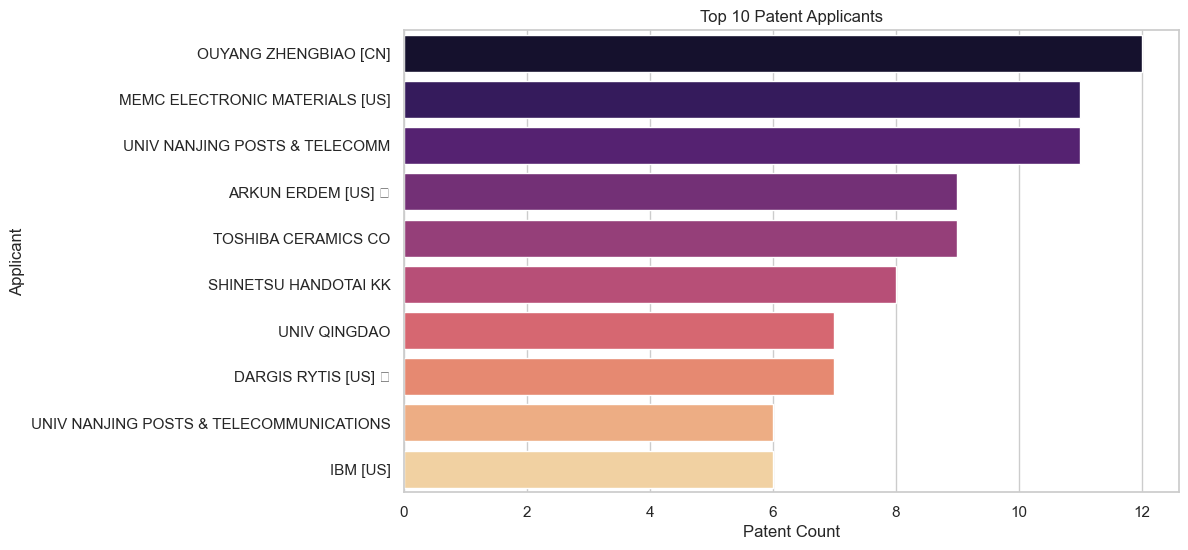

In [ ]:
#top 10 applicants 


plt.figure(figsize=(10, 6))
sns.barplot(x='Patent Count', y='Applicant', data=top_10_applicants_df, palette='magma')
plt.title('Top 10 Patent Applicants')
plt.show()

Network Analysis of Applicants

Creating Collaboration Network Graph...


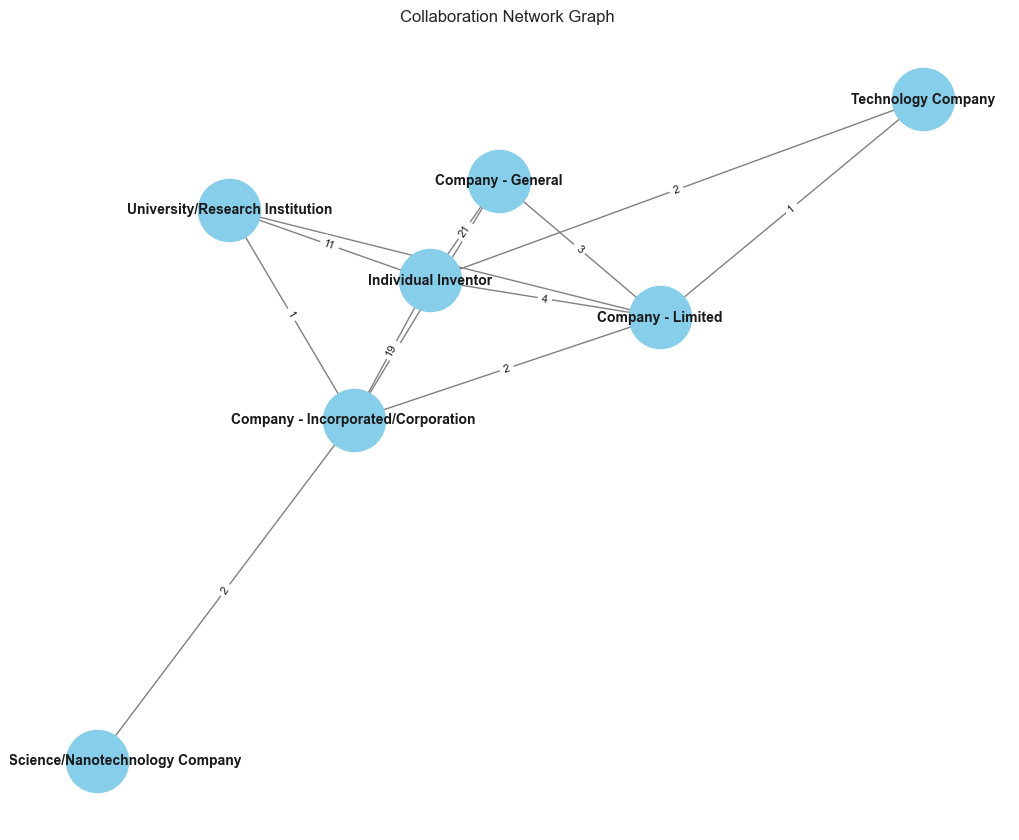

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def create_collaboration_network(df):
    """
    Creates and visualizes a collaboration network graph between 'First Applicant Type' and 'Second Applicant Type',
    after removing rows that contain 'Unknown'.
    """
    print("Creating Collaboration Network Graph...")

    
    df_filtered = df.copy()

    
    df_filtered = df_filtered[
        (df_filtered['first applicant type'] != "Unknown") & 
        (df_filtered['second applicant type'] != "Unknown")
    ]

   
    df_filtered = df_filtered[['first applicant type', 'second applicant type']].dropna()

    
    G = nx.Graph()

    # Add edges (collaborations)
    for _, row in df_filtered.iterrows():
        applicant1, applicant2 = row['first applicant type'], row['second applicant type']
        if applicant1 != applicant2:  
            if G.has_edge(applicant1, applicant2):
                G[applicant1][applicant2]['weight'] += 1 
            else:
                G.add_edge(applicant1, applicant2, weight=1)

    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  

    
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", edge_color="gray", font_size=10, font_weight="bold")

    
    edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Collaboration Network Graph ")
    plt.show()

    return G  

create_collaboration_network(df)


**top IPC codes**

In [ ]:
df['IPC'].head(2)

0                    [H01L29/15, H01L29/66, H10N50/10]
1    [H01L21/84, H01L27/12, H01L21/20, H01L21/205, ...
Name: IPC, dtype: object

In [ ]:
import pandas as pd
from ast import literal_eval

# Convert string representations of lists into actual lists
df['IPC'] = df['IPC'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Explode the IPC lists into individual rows
all_ipc = df['IPC'].explode()

# Count frequencies and extract sorted list of most common IPC classes
most_common_ipc = all_ipc.value_counts().index.tolist()


C:\Users\tasni\AppData\Local\Temp\ipykernel_4736\3970486454.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




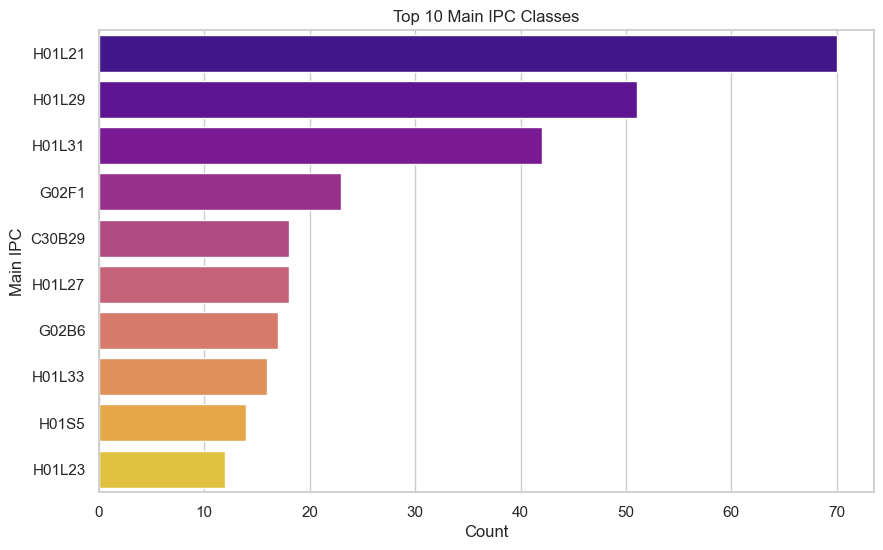

In [ ]:

main_ipc = [code.split('/')[0] for code in most_common_ipc]

# Count main CPC frequencies
main_ipc_counts = Counter(main_ipc).most_common(10)
main_ipc_df = pd.DataFrame(main_ipc_counts, columns=['Main IPC', 'Count'])


plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Main IPC', data=main_ipc_df, palette='plasma')
plt.title('Top 10 Main IPC Classes')
plt.show()

geographical analysis 

In [ ]:
country_counts.head()

Country  Filing Counts
0      US            200
1      CN            159
2      JP             89
3      WO             19
4      KR             12

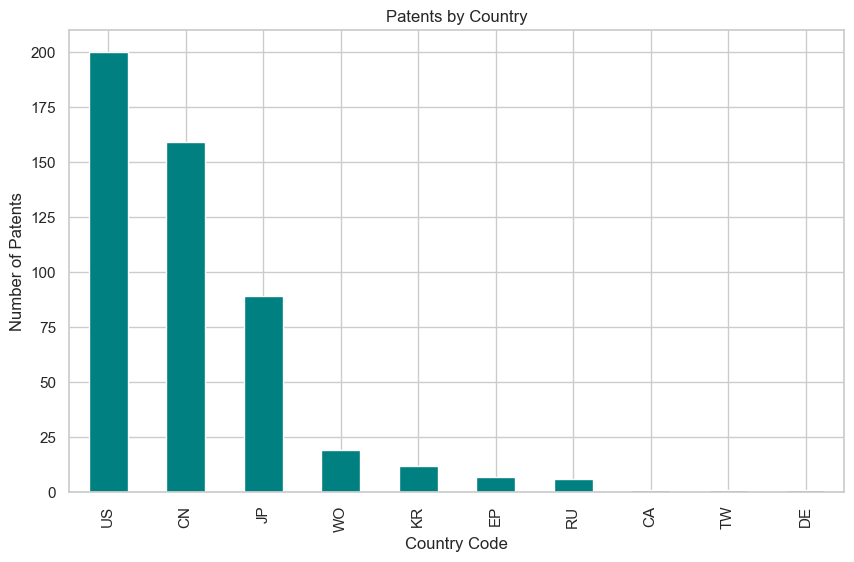

In [ ]:
# Extract country codes
df['Country'] = df['Publication number'].str[:2]

# Count patents by country
pub_country_counts = df['Country'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
pub_country_counts.plot(kind='bar', color='teal')
plt.title('Patents by Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Patents')
plt.show()

**market and R&D**

In [ ]:
df = df.reset_index(drop=True)
family_df_copy = family_df_copy.reset_index(drop=True)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Build a relationship DataFrame that links each origin country to its filing countries.
records = []
for idx, row in family_df_copy.iterrows():
    # Get the origin country for this patent 
    origin = df.loc[idx, 'first publication country']
    # Record an entry for each filing country in the family
    for filing in row['country_codes']:
        records.append({'origin_country': origin, 'filing_country': filing})

relation_df = pd.DataFrame(records)

# Step 3: Group by origin and filing country to count the occurrences
grouped_df = relation_df.groupby(['origin_country', 'filing_country']).size().reset_index(name='count')

# Step 4: Pivot the grouped DataFrame so that each row is an origin country and each column is a filing country
pivot_df = grouped_df.pivot(index='origin_country', columns='filing_country', values='count').fillna(0)

import matplotlib.pyplot as plt

# Sort the pivot table by total filings per origin country 
pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=True).index]





KeyError: 'country_codes'

In [ ]:
grouped_df.head(10)

NameError: name 'grouped_df' is not defined

In [ ]:
pivot_df.head()

NameError: name 'pivot_df' is not defined

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def interactive_patent_filing_plot_sorted(family_df, main_df):
    """
    Creates an interactive stacked bar plot of origin and filing countries using Plotly,
    with stack segments sorted by size (largest on the bottom) and using aesthetic pastel colors.
    """
    # Step 1: Build relationship data
    records = []
    for idx, row in family_df.iterrows():
        origin = main_df.loc[idx, 'first publication country']
        for filing in row['country_codes']:
            records.append({'origin_country': origin, 'filing_country': filing})
    
    relation_df = pd.DataFrame(records)
    grouped_df = relation_df.groupby(['origin_country', 'filing_country']).size().reset_index(name='count')
    
    # Step 2: Pivot and sort filing countries by total count (biggest first)
    pivot_df = grouped_df.pivot(index='origin_country', columns='filing_country', values='count').fillna(0)
    sorted_filing_cols = pivot_df.sum(axis=0).sort_values(ascending=False).index.tolist()
    pivot_df = pivot_df[sorted_filing_cols]
    # Sort origin countries by total filings so the largest bar is at the bottom
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=True).index]


    # Step 3: Use soft color palette
    soft_colors = px.colors.qualitative.Pastel + px.colors.qualitative.Set2
    color_mapping = {country: soft_colors[i % len(soft_colors)] for i, country in enumerate(pivot_df.columns)}

    # Step 4: Create interactive stacked bar plot
    fig = go.Figure()
    for filing_country in pivot_df.columns:
        fig.add_trace(go.Bar(
            y=pivot_df.index,
            x=pivot_df[filing_country],
            name=filing_country,
            orientation='h',
            marker_color=color_mapping[filing_country],
            hovertemplate=(
                "<b>Origin:</b> %{y}<br>"
                "<b>Filing Country:</b> %{meta}<br>"
                "<b>Filings:</b> %{x}<br>"
                "<extra></extra>"
            ),
            meta=[filing_country]*len(pivot_df),
        ))

    # Step 5: Styling and interactivity
    fig.update_layout(
        barmode='stack',
        title={
            'text': "<b>International Patent Protection Strategy</b><br>"
                    "<sub>Origin countries and their international filing patterns</sub>",
            'x': 0.5, 'xanchor': 'center'
        },
        xaxis_title="Total Patent Family Members Filed",
        yaxis_title="Country of First Filing",
        height=800,
        hovermode="closest",
        legend=dict(
            title="Filing Countries",
            orientation="v",
            yanchor="top",
            y=0.5,
            xanchor="right",
            x=1.2
        ),
        margin=dict(l=150, r=200),
        plot_bgcolor='rgba(245,245,245,0.9)'
    )

    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.5, y=-0.15,
        text="Hover to see detailed counts | Click legend items to toggle visibility",
        showarrow=False,
        font=dict(size=12, color="#666")
    )

    fig.update_xaxes(
        gridcolor="white",
        showgrid=True,
        ticksuffix="  "
    )
    
    fig.update_yaxes(
    categoryorder='array',
    categoryarray=pivot_df.index.tolist(),
    ticksuffix="  ",
    tickfont=dict(size=12)
)


    fig.show()
    return fig, pivot_df
fig, sorted_filing_df = interactive_patent_filing_plot_sorted(family_df_copy, df)


KeyError: 'country_codes'

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

def interactive_patent_flow_sorted(family_df, main_df):
    """
    Creates an interactive stacked horizontal bar chart of patent flows
    (which countries receive patents from which), with the largest origin
    segments at the bottom, and uses a pastel color palette for readability.
    Returns the figure and the sorted pivot DataFrame.
    """
    # Build long-form DataFrame of source→receiver relationships
    records = []
    for idx, row in family_df.iterrows():
        source = main_df.loc[idx, 'first publication country']
        for receiver in row['country_codes']:
            records.append({'receiver_country': receiver, 'source_country': source})
    relation_df = pd.DataFrame(records)

    # Aggregate counts
    grouped = (
        relation_df
        .groupby(['receiver_country', 'source_country'])
        .size()
        .reset_index(name='count')
    )

    # Pivot and sort receivers by total received
    pivot_df = grouped.pivot(index='receiver_country', columns='source_country', values='count').fillna(0)
    pivot_df = pivot_df.loc[pivot_df.sum(axis=1).sort_values(ascending=False).index]

    # Sort sources by total sent (descending) so largest at bottom
    # Sort sources so that within each receiver, largest stacks appear first (bottom of bar)
# We compute overall importance of a source by its contribution to the top N receivers
    top_receivers = pivot_df.index[:10]  # focus on top 10 for better visual balance
    source_totals_weighted = pivot_df.loc[top_receivers].sum(axis=0)
    source_order = source_totals_weighted.sort_values(ascending=False).index.tolist()  # ascending = biggest drawn first (bottom)

    pivot_df = pivot_df[source_order]

    # Prepare pastel color palette for sources
    palette = px.colors.qualitative.Pastel + px.colors.qualitative.Set2
    color_map = {src: palette[i % len(palette)] for i, src in enumerate(source_order)}

    # Build Plotly figure
    fig = go.Figure()
    for src in source_order:
        fig.add_trace(go.Bar(
            y=pivot_df.index,
            x=pivot_df[src],
            name=src,
            orientation='h',
            marker_color=color_map[src],
            hovertemplate=(
                "<b>Receiving Country:</b> %{y}<br>"
                "<b>Origin Country:</b> " + src + "<br>"
                "<b>Patents Received:</b> %{x}<extra></extra>"
            )
        ))

    # Layout and aesthetics
    fig.update_layout(
    barmode='stack',
    title={
        'text': "<b>International Patent Flow Analysis</b><br>"
                "<sub>Where countries receive their patents from</sub>",
        'x': 0.5, 'xanchor': 'center'
    },
    xaxis_title="Total Patents Received",
    yaxis_title="Receiving Country",
    height=700,
    hovermode="closest",
    legend_title="Origin Countries",
    legend=dict(
        orientation="v",
        yanchor="middle",
        xanchor="right",
        x=1.25,
        y=0.5
    ),
    margin=dict(l=150, r=200),
    plot_bgcolor='rgba(245,245,245,0.9)',
    hoverlabel=dict(bgcolor="white", font_size=12),
    bargap=0.05,
    bargroupgap=0.0
)


    fig.show()
    return fig, pivot_df

# Example usage:
fig, sorted_receipt_df = interactive_patent_flow_sorted(family_df_copy, df)


KeyError: 'country_codes'

In [ ]:
#pivot_df.to_excel('pivot_table.xlsx')

In [ ]:
family_counts_df.head()

country_code  member_count
0           EP           517
1           US           515
2           WO           400
3           CN           295
4           CA           149

In [ ]:
#family_counts_df.to_csv('family_pub_country_counts.csv')

trend over time

In [ ]:
df['first publication date']

0     2016-12-14
1     2009-01-15
2     2014-03-12
3     2024-04-03
4     2015-11-26
         ...    
491   2010-09-29
492   2015-09-10
493   2016-12-22
494   2012-10-18
495   2012-05-31
Name: first publication date, Length: 496, dtype: datetime64[ns]

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Extract year from publication date (assuming format: 'YYYY-MM-DD')
df['Publication Year'] = pd.to_datetime(df['first publication date'], errors='coerce').dt.year

# Count patents by year
yearly_counts = df['Publication Year'].value_counts().sort_index()

# Create Plotly line chart
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=yearly_counts.index,
        y=yearly_counts.values,
        mode='lines+markers',
        name='Number of Patents',
        line=dict(color='purple', width=3),
        marker=dict(size=6),
        hovertemplate='Year: %{x}<br>Patents: %{y}<extra></extra>'
    )
)

# Update layout with range slider and buttons
fig.update_layout(
    title='Patent Filing Trends Over Time (Publication Year)',
    title_x=0.5,
    title_font_size=22,
    xaxis_title='Year',
    yaxis_title='Number of Patents',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    margin=dict(t=100),
    xaxis=dict(
        dtick=2,
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=5, label='5y', step='year', stepmode='backward'),
                dict(count=10, label='10y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        )
    )
)

fig.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Count patents by earliest priority year
yearly_counts = df['earliest priority year'].value_counts().sort_index()

# Create interactive Plotly line chart
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=yearly_counts.index,
        y=yearly_counts.values,
        mode='lines+markers',
        name='Number of Patents',
        line=dict(color='purple', width=3),
        marker=dict(size=6),
        hovertemplate='Year: %{x}<br>Patents: %{y}<extra></extra>'
    )
)

# Update layout with interactivity
fig.update_layout(
    title='Patent Filing Trends Over Time (Earliest Priority Year)',
    title_x=0.5,
    title_font_size=22,
    xaxis_title='Year',
    yaxis_title='Number of Patents',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    margin=dict(t=100),
    xaxis=dict(
        dtick=2,
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=5, label='5y', step='year', stepmode='backward'),
                dict(count=10, label='10y', step='year', stepmode='backward'),
                dict(step='all')
            ])
        )
    )
)

fig.show()


word cloud for innovation themes

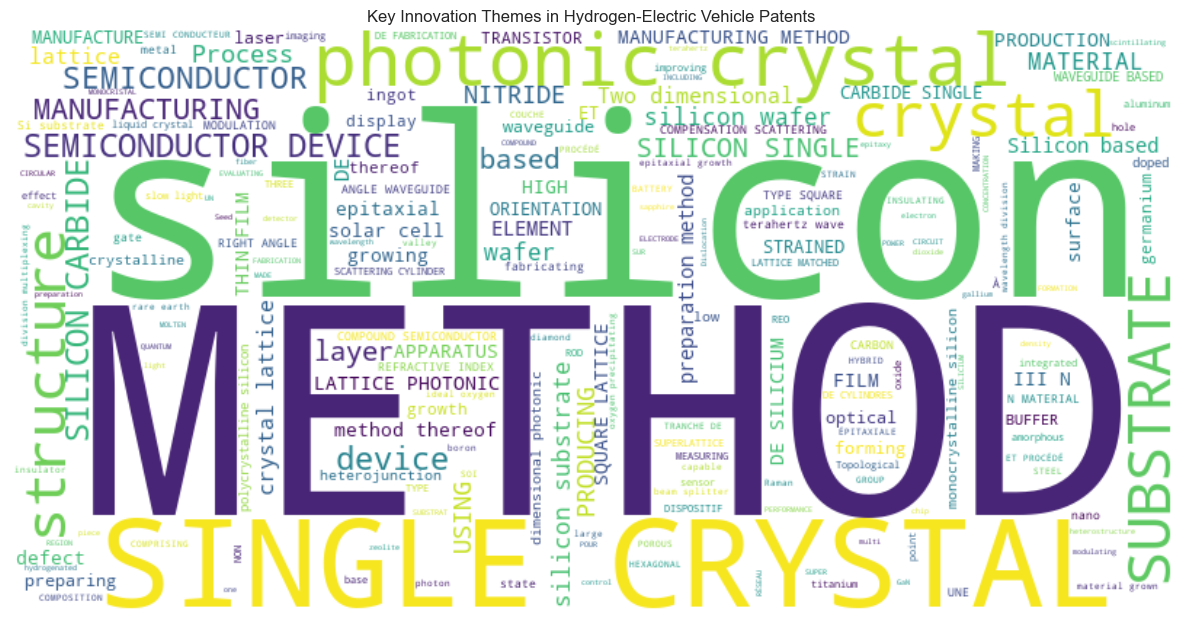

In [ ]:
# Combine all titles
text = ' '.join(df['Title'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Key Innovation Themes in Hydrogen-Electric Vehicle Patents')
plt.show()

In [ ]:
df['Patent Age']=df['Patent Age'].astype('int')

Patent Age Distribution:


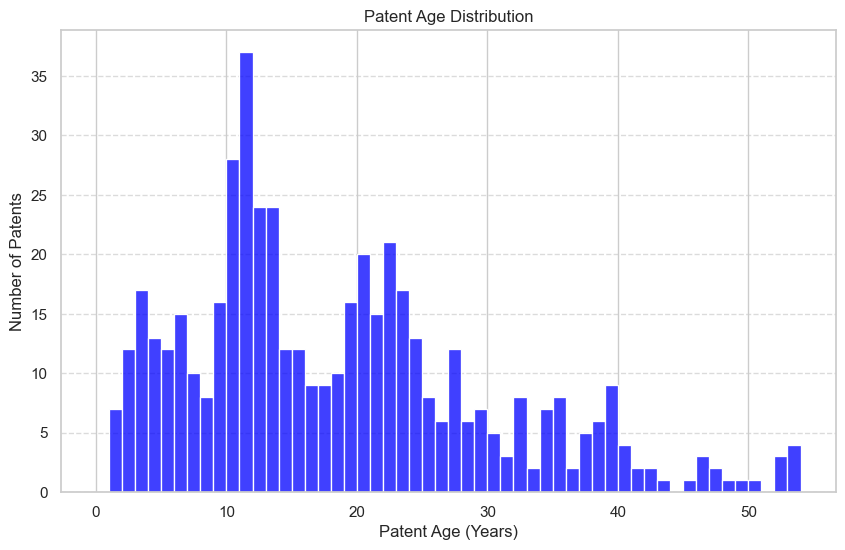

In [ ]:
age_distribution = df['Patent Age'].value_counts().sort_index()

# Display the distribution
print("Patent Age Distribution:")
#print(age_distribution)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Patent Age'], bins=range(0, df['Patent Age'].max() + 1), kde=False, color='blue')
plt.title('Patent Age Distribution')
plt.xlabel('Patent Age (Years)')
plt.ylabel('Number of Patents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
#top 5 emerging keywords in patents and papers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import re
patent_df = df.copy()
paper_df = df_papers.copy()
# ----- 1. (Re)load your DataFrames -----
# patent_df = pd.read_csv('your_patent_data.csv')    # should have 'Title' and 'Publication date'
# paper_df  = pd.read_csv('your_paper_data.csv')     # should have 'Title' and 'Year'

# ----- 2. Preprocess & tokenize -----
def tokenize(text):
    text = re.sub(r'[^a-z0-9\s]', '', str(text).lower())
    return [w for w in text.split() 
            if len(w)>2 and w not in ENGLISH_STOP_WORDS]
# 1. Ensure it’s a string and strip whitespace/newlines:
patent_df['Publication date'] = (
    patent_df['Publication date']
      .astype(str)
      .str.strip()             # removes leading/trailing spaces & newlines
      .str.replace(r'\s+', ' ', regex=True)  # collapse any inner weird whitespace
)

# 2. Parse with flexible inference, coercing errors to NaT:
patent_df['Publication date'] = pd.to_datetime(
    patent_df['Publication date'],
    infer_datetime_format=True,
    errors='coerce'
)

# 3. Now extract year (NaT will become NaN):
patent_df['Year'] = patent_df['Publication date'].dt.year

# 4. (Optional) Drop rows where Year is missing, if you want to ignore unparsed dates:
patent_df = patent_df.dropna(subset=['Year'])
patent_df['Year'] = patent_df['Year'].astype(int)



C:\Users\tasni\AppData\Local\Temp\ipykernel_25100\2479252302.py:28: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



Top 5 emerging in patents: ['method', 'crystal', 'lattice', 'silicon', 'photonic']
Top 5 emerging in papers:  ['silicon', 'photonic', 'crystal', 'based', 'crystals']


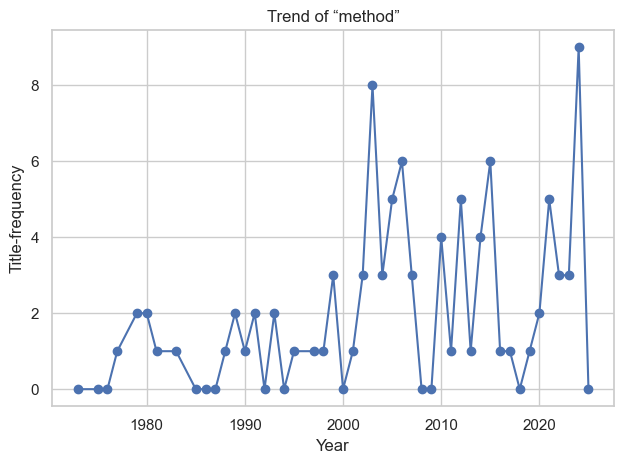

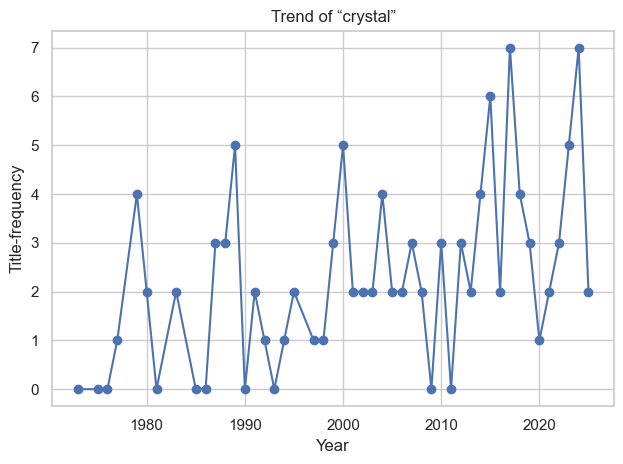

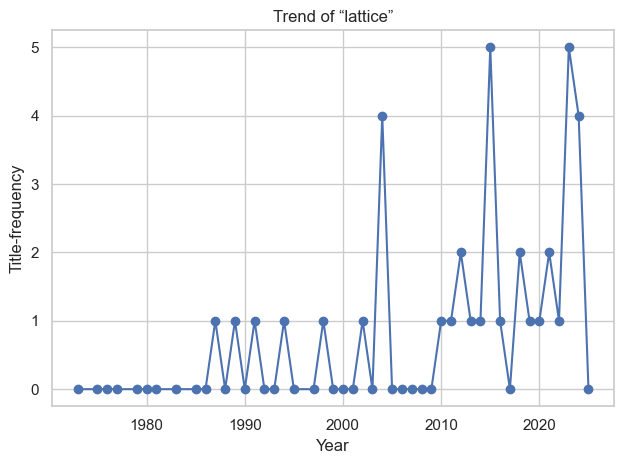

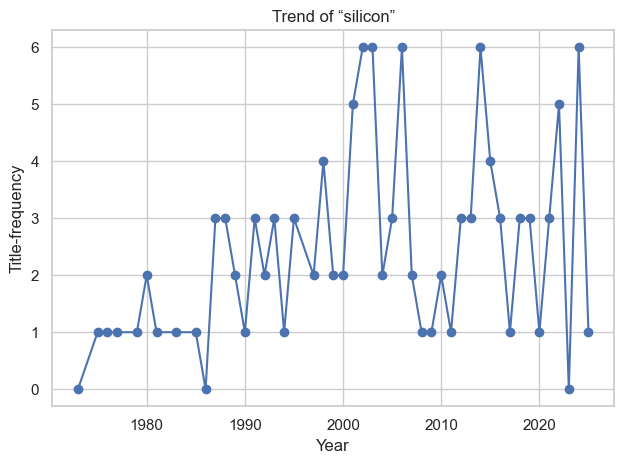

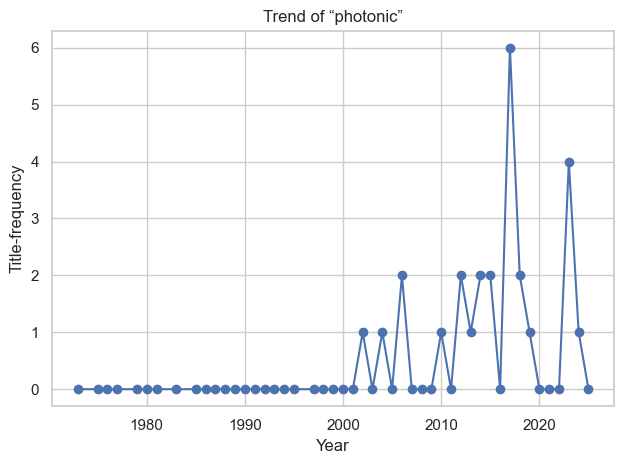

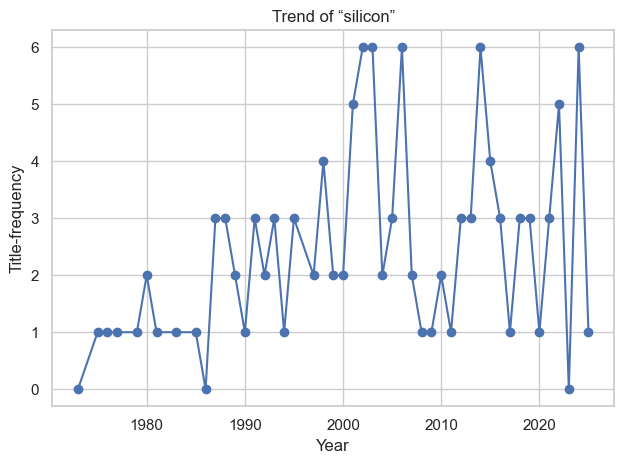

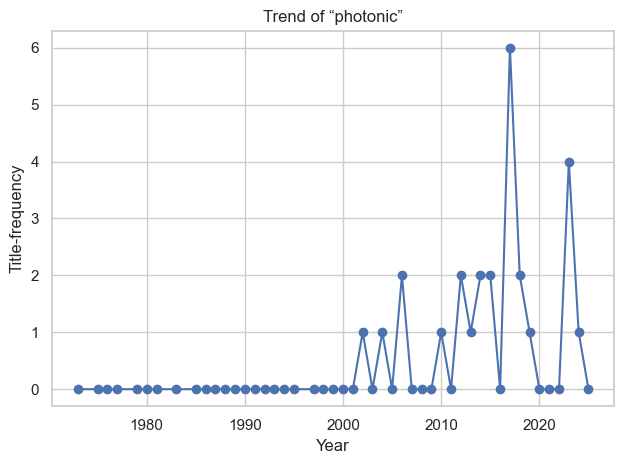

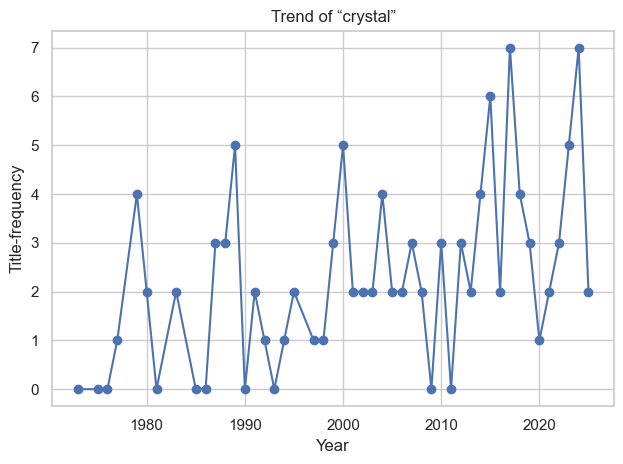

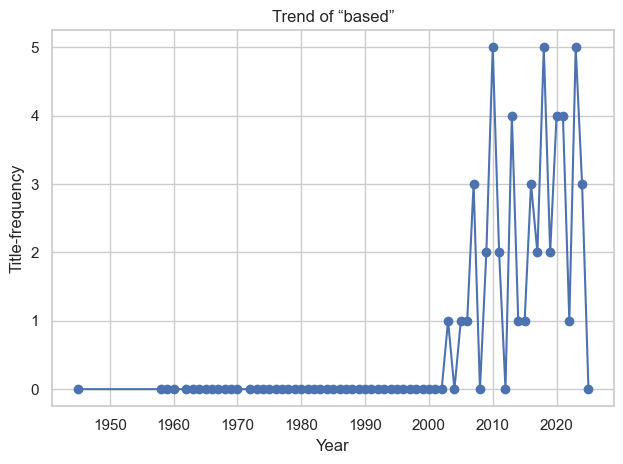

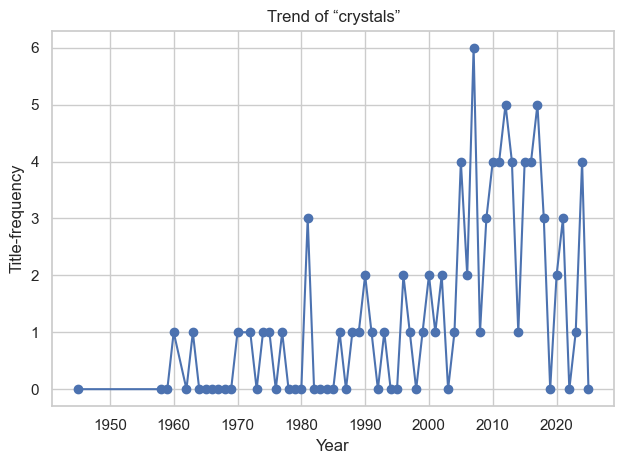

In [ ]:

# ----- 3. Build word×year frequency tables -----
def build_word_counts(df, title_col='Title'):
    year_counts = {}
    for yr, grp in df.groupby('Year'):
        tokens = []
        for t in grp[title_col]:
            tokens += tokenize(t)
        year_counts[yr] = Counter(tokens)
    freq = pd.DataFrame(year_counts).fillna(0).astype(int).T
    return freq

patent_counts = build_word_counts(patent_df)
paper_counts  = build_word_counts(paper_df)

# ----- 4. Identify top-emerging keywords by slope ----- 
def top_emerging_words(freq_df, top_n=5, min_total=10):
    slopes = {}
    years = freq_df.index.values
    for w in freq_df.columns:
        y = freq_df[w].values
        if y.sum() >= min_total:
            slopes[w] = np.polyfit(years, y, 1)[0]
    return sorted(slopes, key=slopes.get, reverse=True)[:top_n]

top5_patents = top_emerging_words(patent_counts, 5)
top5_papers  = top_emerging_words(paper_counts, 5)

print("Top 5 emerging in patents:", top5_patents)
print("Top 5 emerging in papers: ", top5_papers)

# ----- 5. Plot each keyword separately -----
for word in top5_patents + top5_papers:
    df_src = patent_counts if word in top5_patents else paper_counts
    plt.figure()
    plt.plot(df_src.index, df_src[word], marker='o')
    plt.title(f"Trend of “{word}”")
    plt.xlabel("Year")
    plt.ylabel("Title-frequency")
    plt.grid(True)
    plt.tight_layout()

plt.show()


In [ ]:
import plotly.graph_objects as go

# Create an empty Figure
fig = go.Figure()

# Add patent keywords as dashed lines with circle markers
for word in top5_patents:
    if word in patent_counts.columns:
        fig.add_trace(
            go.Scatter(
                x=patent_counts.index,
                y=patent_counts[word],
                mode='lines+markers',
                name=f"{word} (patent)",
                line=dict(dash='dash'),
                marker=dict(symbol='circle')
            )
        )

# Add paper keywords as solid lines with square markers
for word in top5_papers:
    if word in paper_counts.columns:
        fig.add_trace(
            go.Scatter(
                x=paper_counts.index,
                y=paper_counts[word],
                mode='lines+markers',
                name=f"{word} (paper)",
                line=dict(dash='solid'),
                marker=dict(symbol='square')
            )
        )

# Tweak layout
fig.update_layout(
    title="Emerging Keywords in Patents vs. Papers",
    xaxis_title="Year",
    yaxis_title="Frequency in Titles",
    legend=dict(title="Keyword (source)", orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    template="plotly_white"
)

# Display the interactive plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Sum across your top-5 columns to get two series
patent_series = patent_counts[top5_patents].sum(axis=1)
paper_series  = paper_counts[top5_papers].sum(axis=1)

fig = go.Figure()

# Add a single patents trace
fig.add_trace(
    go.Scatter(
        x=patent_series.index,
        y=patent_series.values,
        mode='lines+markers',
        name="Patents (top 5 combined)",
        line=dict(dash='dash'),
        marker=dict(symbol='circle')
    )
)

# Add a single papers trace
fig.add_trace(
    go.Scatter(
        x=paper_series.index,
        y=paper_series.values,
        mode='lines+markers',
        name="Papers (top 5 combined)",
        line=dict(dash='solid'),
        marker=dict(symbol='square')
    )
)

# Tweak layout
fig.update_layout(
    title="Emerging Keywords in Patents vs. Papers (Top 5 Combined)",
    xaxis_title="Year",
    yaxis_title="Total Frequency in Titles",
    legend=dict(
        title="Source",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
    ),
    template="plotly_white",
    # make a little extra bottom margin for our annotations
    margin=dict(b=100)
)

# Add annotations listing the words under the x-axis
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.01, y=-0.15,
    showarrow=False,
    text="<b>Patents top 5:</b> " + ", ".join(top5_patents),
    align="left",
    font=dict(size=12)
)
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.01, y=-0.23,
    showarrow=False,
    text="<b>Papers top 5:</b> " + ", ".join(top5_papers),
    align="left",
    font=dict(size=12)
)

fig.show()


In [ ]:
patent_df.columns

Index(['No', 'Title', 'Inventors', 'Applicants', 'Publication number',
       'Earliest priority', 'IPC', 'CPC', 'Publication date',
       'Earliest publication', 'Family number', 'first publication date',
       'second publication date', 'first publication number',
       'second publication number', 'first publication country',
       'second publication country', 'first filing year',
       'earliest priority year', 'applicant country', 'IPC_Meaning', 'fields',
       'first applicant', 'second applicant', 'first applicant type',
       'second applicant type', 'Patent Age', 'patent cost'],
      dtype='object')

Top 5 emerging in patents: ['photonic', 'based', 'lattice', 'manufacturing', 'light']
Top 5 emerging in papers:  ['photonic', 'crystal', 'based', 'using', 'films']


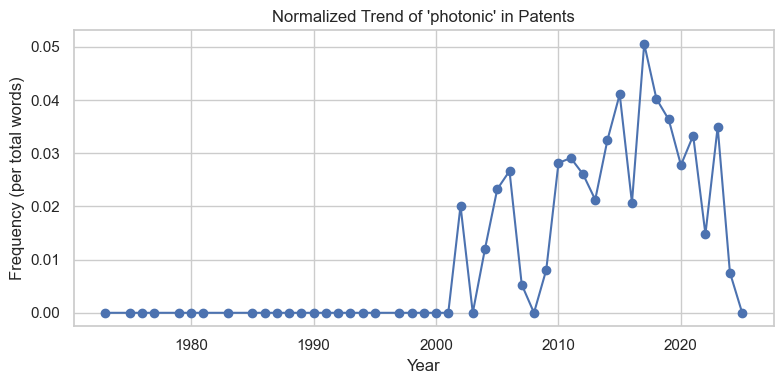

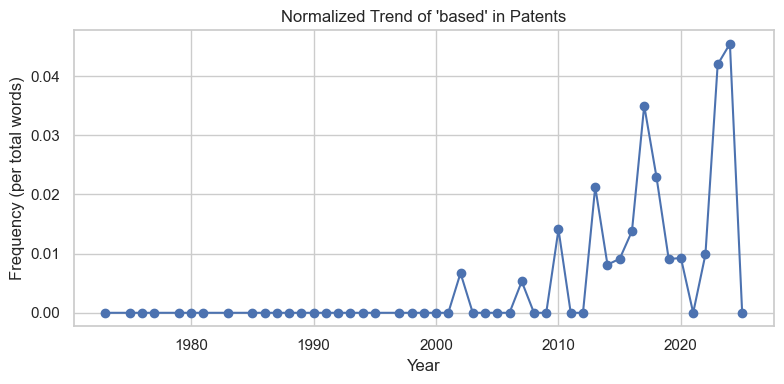

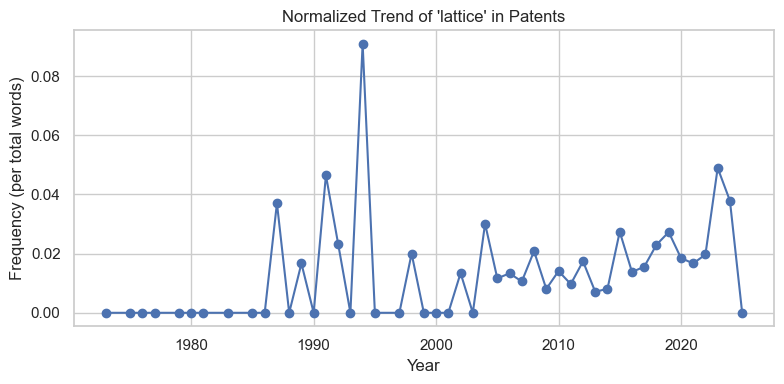

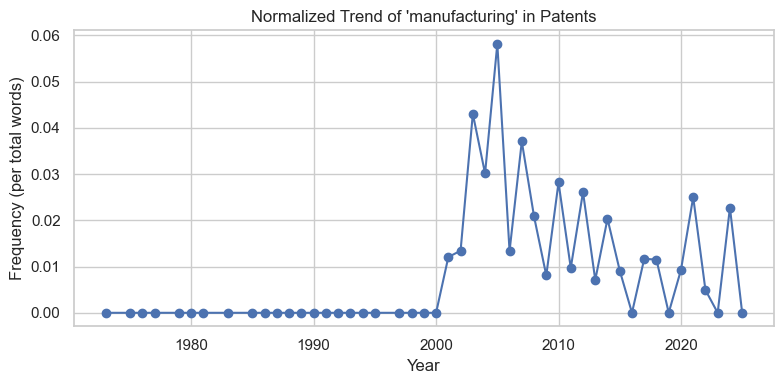

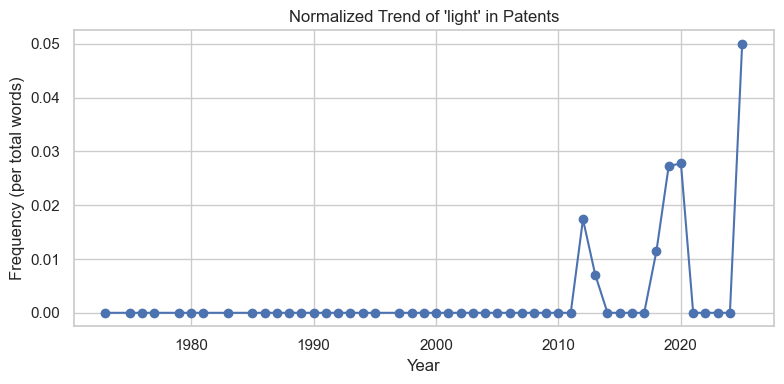

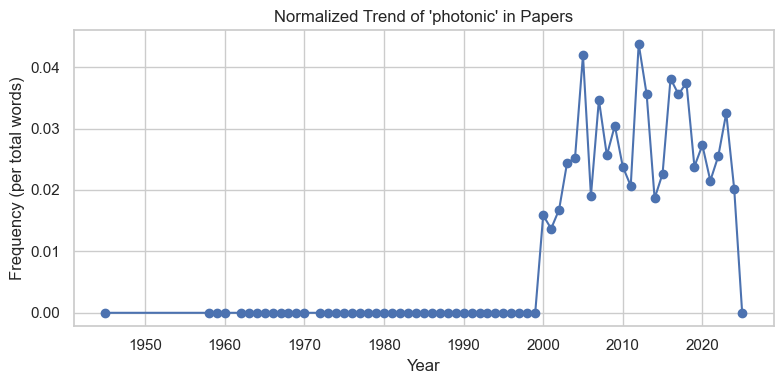

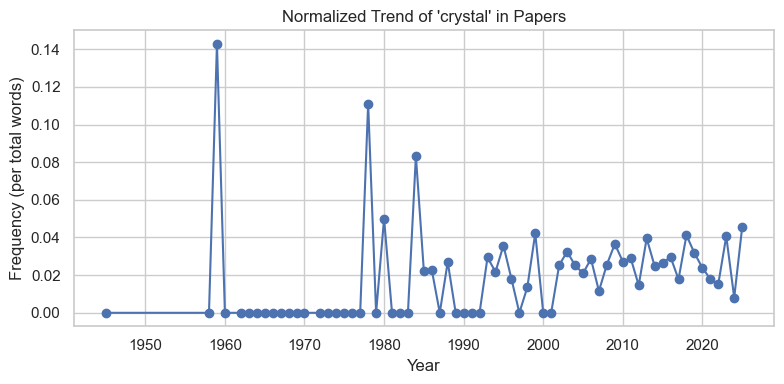

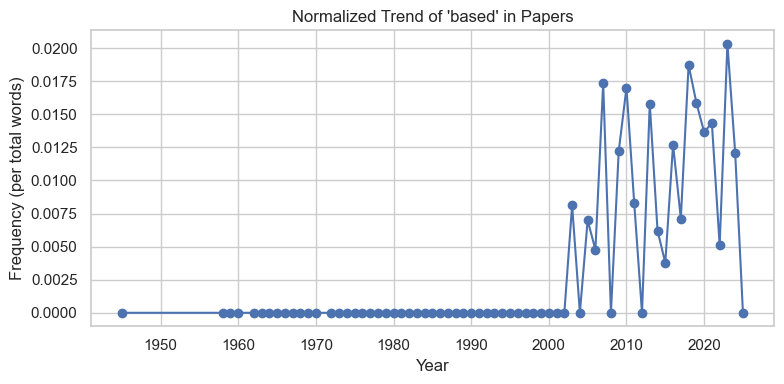

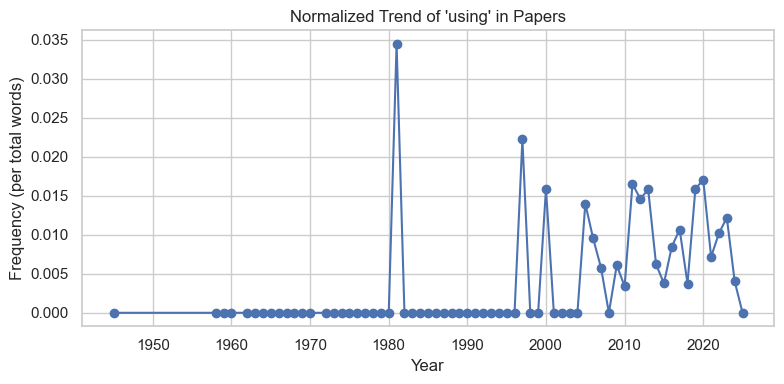

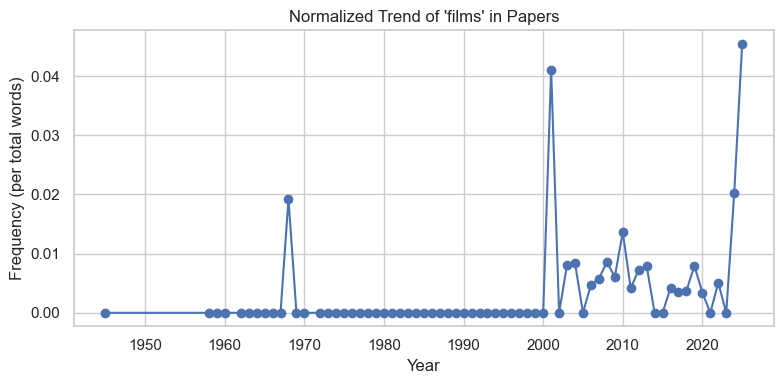

In [ ]:
#top 5 emerging keywords in patents and papers (normalized)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
import re
patent_df = df.copy()
paper_df = df_papers.copy()
patent_df.rename(columns={'first filing year' : 'Year'}, inplace=True)
# ----- 1. Modified build_word_counts function -----
def build_word_counts(df, title_col='Title'):
    """Returns tuple of (word_counts_df, total_words_series)"""
    year_counts = {}
    total_words = {}
    
    for yr, grp in df.groupby('Year'):
        tokens = []
        for t in grp[title_col]:
            tokens += tokenize(t)
        year_counts[yr] = Counter(tokens)
        total_words[yr] = len(tokens)  # Track total words per year
        
    return (
        pd.DataFrame(year_counts).fillna(0).astype(int).T,  # Word counts
        pd.Series(total_words)                              # Total words
    )

# ----- 2. Modified top-emerging function -----
def top_emerging_words(norm_df, raw_df, top_n=5, min_total=10):
    """Uses normalized frequencies for trends but raw counts for filtering"""
    slopes = {}
    years = norm_df.index.values
    
    for w in norm_df.columns:
        # Check raw counts for minimum threshold
        if raw_df[w].sum() >= min_total:
            # Use normalized values for trend calculation
            y = norm_df[w].values
            slopes[w] = np.polyfit(years, y, 1)[0]
            
    return sorted(slopes, key=slopes.get, reverse=True)[:top_n]

# ----- 3. Main analysis flow -----
# Preprocessing (keep your existing date handling code)

# Build counts with normalization
patent_counts_raw, patent_totals = build_word_counts(patent_df)
paper_counts_raw, paper_totals = build_word_counts(paper_df)

# Create normalized frequency DataFrames
patent_norm = patent_counts_raw.div(patent_totals, axis=0).fillna(0)
paper_norm = paper_counts_raw.div(paper_totals, axis=0).fillna(0)

# Find top emerging terms using normalized trends
top5_patents = top_emerging_words(patent_norm, patent_counts_raw)
top5_papers = top_emerging_words(paper_norm, paper_counts_raw)

print("Top 5 emerging in patents:", top5_patents)
print("Top 5 emerging in papers: ", top5_papers)

# ----- 4. Modified plotting -----
def plot_trends(terms, norm_df, source_name):
    for word in terms:
        plt.figure(figsize=(8, 4))
        plt.plot(norm_df.index, norm_df[word], marker='o', linestyle='-')
        plt.title(f"Normalized Trend of '{word}' in {source_name}")
        plt.xlabel("Year")
        plt.ylabel("Frequency (per total words)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_trends(top5_patents, patent_norm, "Patents")
plot_trends(top5_papers, paper_norm, "Papers")

In [ ]:
import plotly.graph_objects as go

# Create an empty Figure
fig = go.Figure()

# Add patent keywords as dashed lines with circle markers
for word in top5_patents:
    if word in patent_counts.columns:
        fig.add_trace(
            go.Scatter(
                x=patent_counts.index,
                y=patent_counts[word],
                mode='lines+markers',
                name=f"{word} (patent)",
                line=dict(dash='dash'),
                marker=dict(symbol='circle')
            )
        )

# Add paper keywords as solid lines with square markers
for word in top5_papers:
    if word in paper_counts.columns:
        fig.add_trace(
            go.Scatter(
                x=paper_counts.index,
                y=paper_counts[word],
                mode='lines+markers',
                name=f"{word} (paper)",
                line=dict(dash='solid'),
                marker=dict(symbol='square')
            )
        )

# Tweak layout
fig.update_layout(
    title="Emerging Keywords in Patents vs. Papers",
    xaxis_title="Year",
    yaxis_title="Frequency in Titles",
    legend=dict(title="Keyword (source)", orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
    template="plotly_white"
)

# Display the interactive plot
fig.show()
